# Imports

In [1]:
from biopandas.pdb import PandasPdb
import scipy as sp
import pandas as pd
import os
import numpy as np
import Bio
from abnumber import Chain
import math
import enum
import torch
import torch.nn.functional as F
from tqdm import trange
# from Bio.PDB import PDBParser
# from Bio.PDB.Selection import unfold_entities
# from Bio.SeqIO import PdbIO
import warnings
import seaborn as sns
from pathlib import Path
from typing import Dict, Tuple, Sequence, List, Optional, Union
# from Levenshtein import distance, ratio
# from Bio.Align.Applications import ClustalwCommandline
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Benchmarking.benchmark.ops.all_funcs import * 
from Benchmarking.benchmark.ops.protein import *
from Benchmarking.benchmark.ops.benchmark_clean_funcs import *
import colorcet as cc
from scipy.stats import mannwhitneyu, ranksums
from scipy import stats
import statsmodels #.api as sm
import shutil

/home/ftalib1/scr4_jgray21/ftalib1/miniconda3/envs/AF3/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/home/ftalib1/scr4_jgray21/ftalib1/miniconda3/envs/AF3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


# Setting up file directory

In [ ]:
filepath = '/Your/FilePath/'

# Data setup

## General Params

In [2]:
h3_len_to_bin_dict = dict(zip(list(range(10)),['short']*len(list(range(10)))))
h3_len_to_bin_dict.update(dict(zip(list(range(10,16)),['medium']*len(list(range(10,16))))))
h3_len_to_bin_dict.update(dict(zip(list(range(16,26)),['long']*len(list(range(16,26))))))

In [3]:
# finalized abs list
abs_seqid_info = pd.read_csv("seq_id_max_ab.csv").drop(columns=['Unnamed: 0'])
nbs_seqid_info = pd.read_csv("nb_seq_id_max.csv").drop(columns=['Unnamed: 0'])
# Seq_ID_Ab_withBUB = pd.read_csv("Ab_Seq_Identities.csv")

# final_abs_pt1 = abs_seqid_info[abs_seqid_info['Bound_Unbound']!=Seq_ID_Ab_withBUB['PDB2_BUB']].PDB1.unique().tolist()+Seq_ID_Ab_withBUB[Seq_ID_Ab_withBUB['PDB1_BUB']!=Seq_ID_Ab_withBUB['PDB2_BUB']].PDB2.unique().tolist()
final_abs = abs_seqid_info[(abs_seqid_info['Max_Seq_H_ID_TrainvBenchmark']<0.95) & (abs_seqid_info['Max_Seq_L_ID_TrainvBenchmark']<0.95)\
                                & (abs_seqid_info['Max_Seq_H_ID_Benchmark_v_Benchmark']<0.99)& (abs_seqid_info['Max_Seq_L_ID_Benchmark_v_Benchmark']<0.99)].PDB1.unique().tolist()
final_nbs = nbs_seqid_info[(nbs_seqid_info['Max_Seq_ID_TrainvBenchmark']<0.95)\
                                & (nbs_seqid_info['Max_Seq_ID_Benchmark_v_Benchmark']<0.99)].PDB.unique().tolist()
igfold_ab_seqs = pd.read_csv("igfold_ab_seq_fullinfo.csv")
all_ab_seq_info_df = pd.read_csv("ALL_abs_info_df.csv")
nb_bound_seq_df = pd.read_csv("bound_filtered_Nb_pdbs.csv").drop(columns=['Unnamed: 0'])
nb_unbound_seq_df = pd.read_csv("unbound_filtered_Nb_pdbs.csv").drop(columns=['Unnamed: 0'])
final_benchmark = pd.read_csv("results/All_info_fullbenchmark_final.csv").drop(columns=['Unnamed: 0'])

abs_seqid_info = pd.read_csv("seq_id_max_ab.csv").drop(columns=['Unnamed: 0'])
nbs_seqid_info = pd.read_csv("nb_seq_id_max.csv").drop(columns=['Unnamed: 0'])
# final_abs_pt2 = abs_seqid_info[(abs_seqid_info['Max_Seq_H_ID_TrainvBenchmark']<0.95) & (abs_seqid_info['Max_Seq_L_ID_TrainvBenchmark']<0.95)\
                                # & (abs_seqid_info['Max_Seq_H_ID_Benchmark_v_Benchmark']<0.99)& (abs_seqid_info['Max_Seq_L_ID_Benchmark_v_Benchmark']<0.99)].PDB1.unique().tolist()
all_nb_seq_info_df = pd.read_csv("ALL_nbs_info_df.csv")
igfold_nb_seqs = pd.read_csv("igfold_nb_seq_fullinfo.csv")

# Loading in dataframes

In [5]:
# AF3 results with aux data

final_af3_benchmark = pd.read_csv("results/round_6/datafiles/af3_withauxdata_results.csv").drop(columns=['Unnamed: 0'])
ranking_df = pd.read_csv("results/round_6/datafiles/af3_withproperranking_results.csv").drop(columns=['Unnamed: 0'])
ranking_df = ranking_df.rename(columns={"Dir":"AF3_Dir","PDB":"AF3_PDB"})
fulldf_fixed = pd.read_csv("results/round_6/datafiles/af3_withauxdata_andproperranking_results_fixeddf.csv").drop(columns=['Unnamed: 0'])

# AF3 v AF2 results with aux data

AF2_v_AF3 = pd.read_csv("results/round_6/datafiles/af3_v_af2_results.csv").drop(columns=['Unnamed: 0'])
AF2_v_AF3['H3_local_RMSD'] = [x if x!='length mismatch' else np.nan for x in AF2_v_AF3['H3_local_RMSD'].tolist()]
melted_AF2_v_AF3 = pd.melt(AF2_v_AF3,id_vars = ['Model_Source','Protein_type', 'Bound_Unbound',
       'Seed', 'Model', 'PDB_short', 'h3_len','h3_length'],value_vars=['ocd', 'frh_rms', 'h1_rms', 'h2_rms', 'h3_rms','H3_local_RMSD','frl_rms',
       'l1_rms', 'l2_rms', 'l3_rms'],var_name = "Fv_Region",value_name = "RMSD (Å)")

# IgFold benchmark
igfold_benchmark = pd.read_csv("results/round_6/datafiles/topranked_inventoried_finalIgFoldFullresults.csv")

In [7]:
final_withranked = final_af3_benchmark.merge(ranking_df,on=["AF3_Dir","AF3_PDB",'Bound_Unbound','Protein_type'])


,AF3_Dir,AF3_PDB,Bound_Unbound,Native_Dir,Native_PDB,H3_local_RMSD,ocd,frh_rms,h1_rms,h2_rms,...,H3_plddt_arrays,iRMS,LRMS,ipTM_HA,ipTM_LA,I_pLDDT,DockQ_Classification,h3_len,h3_length,Rank
0,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_7wog_0_seed2_model_2.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_7wog_0.pdb,2.603683,6.097552,0.792324,1.850435,0.745787,...,"[97.08, 95.75, 91.46, 76.32, 60.44, 46.71, 37.66]",14.174914,61.030603,0.12,0.87,74.739014,Incorrect,15,medium,0.46
1,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_7wog_0_seed2_model_1.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_7wog_0.pdb,1.101932,7.382339,0.793392,1.869264,0.807046,...,"[97.48, 96.36, 92.65, 83.1, 69.7, 54.9, 48.76]",15.213616,63.243040,0.13,0.87,75.060333,Incorrect,15,medium,0.46
2,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_7wog_0_seed2_model_4.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_7wog_0.pdb,3.089512,4.742667,0.804903,1.890414,0.853653,...,"[96.65, 95.55, 91.28, 77.63, 65.52, 45.92, 40.76]",13.471552,56.433804,0.12,0.87,72.970323,Incorrect,15,medium,0.45
3,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_7wog_0_seed2_model_3.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_7wog_0.pdb,1.404354,6.869014,0.783782,1.875364,0.822566,...,"[97.19, 95.98, 92.09, 82.0, 66.6, 50.3, 44.18]",17.702814,66.458701,0.12,0.87,75.514706,Incorrect,15,medium,0.46
4,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_7wog_0_seed2_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_7wog_0.pdb,2.005684,6.661400,0.797478,1.882435,0.844747,...,"[97.25, 96.15, 92.48, 83.02, 70.54, 56.11, 47.66]",13.146236,29.518698,0.13,0.87,79.170781,Incorrect,15,medium,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_7srk_1_seed3_model_3.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7srk_1.pdb,0.102458,0.000000,0.860649,0.959614,0.508325,...,"[94.16, 92.33, 90.08, 86.31, 83.08, 82.29, 83.23]",NaN,NaN,0.74,NaN,89.611356,Acceptable,10,medium,0.70
3236,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_7srk_1_seed3_model_1.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7srk_1.pdb,0.126045,0.000000,0.841316,1.025517,0.511704,...,"[93.66, 92.03, 89.88, 86.61, 83.58, 82.69, 83.13]",NaN,NaN,0.74,NaN,89.531228,Acceptable,10,medium,0.70
3237,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_7srk_1_seed3_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7srk_1.pdb,0.117191,0.000000,0.858129,0.966172,0.540372,...,"[94.26, 92.53, 90.08, 86.31, 82.88, 82.39, 83.23]",NaN,NaN,0.75,NaN,89.669655,Acceptable,10,medium,0.71
3238,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_7srk_1_seed3_model_4.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7srk_1.pdb,0.106344,0.000000,0.858463,1.033971,0.508645,...,"[93.56, 91.33, 87.88, 84.31, 79.98, 79.79, 80.83]",NaN,NaN,0.69,NaN,88.509310,High,10,medium,0.65


In [13]:
top_df = pd.read_csv("results/round_6/datafiles/topranked_benchmark_results.csv").drop(columns=['Unnamed: 0'])

,AF3_Dir,AF3_PDB,Bound_Unbound,Native_Dir,Native_PDB,H3_local_RMSD,ocd,frh_rms,h1_rms,h2_rms,...,H3_plddt_arrays,iRMS,LRMS,ipTM_HA,ipTM_LA,I_pLDDT,DockQ_Classification,h3_len,h3_length,Rank
0,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_7wog_0_seed1_model_3.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_7wog_0.pdb,2.083899,6.088462,0.786839,1.829999,0.843756,...,"[97.25, 96.28, 93.26, 84.22, 72.54, 55.51, 48.78]",10.362904,37.337104,0.11,0.87,78.533571,Incorrect,15,medium,0.46
1,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_7wg3_1_seed1_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_7wg3_1.pdb,0.756339,3.303913,0.437551,0.439854,0.630660,...,"[97.85, 96.46, 90.9, 80.67, 63.15, 54.48, 58.66]",11.811967,58.753692,0.12,0.60,73.003529,Incorrect,10,medium,0.51
2,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_8ath_1_seed1_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_8ath_1.pdb,2.881878,3.348432,0.324405,0.964289,0.720034,...,"[97.84, 97.13, 93.62, 84.09, 68.49, 58.63, 55.58]",2.274379,13.657032,0.59,0.88,85.245294,Acceptable,11,medium,0.74
3,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_8hp9_0_seed1_model_2.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_8hp9_0.pdb,0.672799,12.034881,0.679160,0.658511,0.610475,...,"[97.53, 96.87, 97.03, 96.77, 96.09, 93.8, 93.44]",0.861563,52.223349,0.75,0.77,91.103585,Medium,20,long,0.75
4,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_8sgn_0_seed1_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_8sgn_0.pdb,0.452939,2.997131,0.281419,1.004531,1.380401,...,"[97.13, 95.0, 90.94, 86.59, 79.05, 71.37, 69.02]",2.282587,9.529049,0.26,0.85,73.034535,Acceptable,13,medium,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_fold_7xl0_0_seed1_model_2.pdb,unbound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7xl0_0.pdb,0.677634,0.000000,0.774113,1.198034,1.608753,...,"[94.18, 89.76, 87.38, 83.08, 74.61, 63.7, 56.61]",NaN,NaN,NaN,NaN,NaN,NaN,15,medium,0.86
215,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_fold_7t84_3_seed1_model_0.pdb,unbound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7t84_3.pdb,1.510934,0.000000,0.659061,2.861539,3.105805,...,"[98.42, 97.68, 95.81, 93.49, 89.86, 83.51, 74.92]",NaN,NaN,NaN,NaN,NaN,NaN,12,medium,0.87
216,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_fold_7t84_2_seed1_model_0.pdb,unbound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7t84_2.pdb,1.267219,0.000000,0.565536,2.838805,2.749877,...,"[98.52, 97.65, 95.92, 93.45, 89.39, 84.12, 74.81]",NaN,NaN,NaN,NaN,NaN,NaN,12,medium,0.87
217,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_fold_7q6c_0_seed1_model_0.pdb,unbound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7q6c_0.pdb,1.090789,0.000000,0.401254,0.496171,0.608720,...,"[96.79, 95.35, 92.03, 85.09, 77.5, 68.76, 61.48]",NaN,NaN,NaN,NaN,NaN,NaN,11,medium,0.88


# Aesthetics

In [19]:
# palette = sns.color_palette(['#3187DE','#FF88AC','#02AA9D','#FFDF00'])
# palette = sns.color_palette(['#3187DE','#FFDF00','#02AA9D','#FF88AC'])
palette = sns.color_palette(['#FF88AC','#02AA9D','#FFDF00','#3187DE'])
# pastel_palette = sns.color_palette(['#78b6f5','#f7bacc','#96e0db','#fff18f'])
# pastel_palette = sns.color_palette(['#78b6f5','#fff18f','#96e0db','#f7bacc'])
edgecolor = '0'
pastel_palette = sns.color_palette(['#f7bacc','#96e0db','#fff18f','#78b6f5','#FFC8A2','#c997c6'])
pastel_palette2 = sns.color_palette(['#f7bacc','#96e0db','#FFDF00','#78b6f5','#FFC8A2','#c997c6'])
pastel_palette2


[(0.9686274509803922, 0.7294117647058823, 0.8),
 (0.5882352941176471, 0.8784313725490196, 0.8588235294117647),
 (1.0, 0.8745098039215686, 0.0),
 (0.47058823529411764, 0.7137254901960784, 0.9607843137254902),
 (1.0, 0.7843137254901961, 0.6352941176470588),
 (0.788235294117647, 0.592156862745098, 0.7764705882352941)]

In [20]:
plt.rcParams['svg.fonttype'] = 'none'

In [21]:
extended_pastel_palette = sns.color_palette(['#f7bacc','#96e0db','#FFDF00','#78b6f5','#FFC8A2','#c997c6','#57C288','#D66E5C','#AAD2EC'])
extended_pastel_palette

[(0.9686274509803922, 0.7294117647058823, 0.8),
 (0.5882352941176471, 0.8784313725490196, 0.8588235294117647),
 (1.0, 0.8745098039215686, 0.0),
 (0.47058823529411764, 0.7137254901960784, 0.9607843137254902),
 (1.0, 0.7843137254901961, 0.6352941176470588),
 (0.788235294117647, 0.592156862745098, 0.7764705882352941),
 (0.3411764705882353, 0.7607843137254902, 0.5333333333333333),
 (0.8392156862745098, 0.43137254901960786, 0.3607843137254902),
 (0.6666666666666666, 0.8235294117647058, 0.9254901960784314)]

In [22]:
# sns.set_style("darkgrid")
sns.set_style("whitegrid",{"grid.color":"0.6"})
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="ticks", rc=custom_params,font_scale=3)
sns.set_theme(font_scale=1.5)
linewidth = 2
edgecolor = 'black'

# Processing data for panels

## DockQs

In [23]:
new_dockqs = pd.read_csv("Revised_DockQ_DB5.csv")
new_dockqs = new_dockqs[new_dockqs['Antibody']==1]
af2_rank_incorrect = []
af2_rank_acceptable = []
af2_rank_medium = []
af2_rank_high = []

afred_rank_incorrect = []
afred_rank_acceptable = []
afred_rank_medium = []
afred_rank_high = []

for i in trange(new_dockqs.shape[0]):
    af2_rank = new_dockqs.iloc[i].AF2_CAPRI_rank
    afred_rank = new_dockqs.iloc[i].CAPRI_rank
    if af2_rank == 0:
        af2_rank_incorrect.append(1)
    elif af2_rank == 1:
        af2_rank_acceptable.append(1)
    elif af2_rank == 2:
        af2_rank_medium.append(1)
    elif af2_rank == 3:
        af2_rank_high.append(1)

    if afred_rank == 0:
        afred_rank_incorrect.append(1)
    elif afred_rank == 1:
        afred_rank_acceptable.append(1)
    elif afred_rank == 2:
        afred_rank_medium.append(1)
    elif afred_rank == 3:
        afred_rank_high.append(1)

newdockqs_summary = pd.DataFrame({"Model":['AlphaFold-M','AlphaRED'],"Incorrect":[round(len(af2_rank_incorrect)/67,4)*100,round(len(afred_rank_incorrect)/67,4)*100],\
              "Acceptable":[round(len(af2_rank_acceptable)/67,4)*100,round(len(afred_rank_acceptable)/67,4)*100],"Medium":[round(len(af2_rank_medium)/67,4)*100,round(len(afred_rank_medium)/67,4)*100],\
                "High":[round(len(af2_rank_high)/67,4)*100,round(len(afred_rank_high)/67,4)*100]})
newdockqs_summary

100%|██████████| 67/67 [00:00<00:00, 12083.69it/s]


,Model,Incorrect,Acceptable,Medium,High
0,AlphaFold-M,79.10,8.96,11.94,0.0
1,AlphaRED,56.72,25.37,17.91,0.0


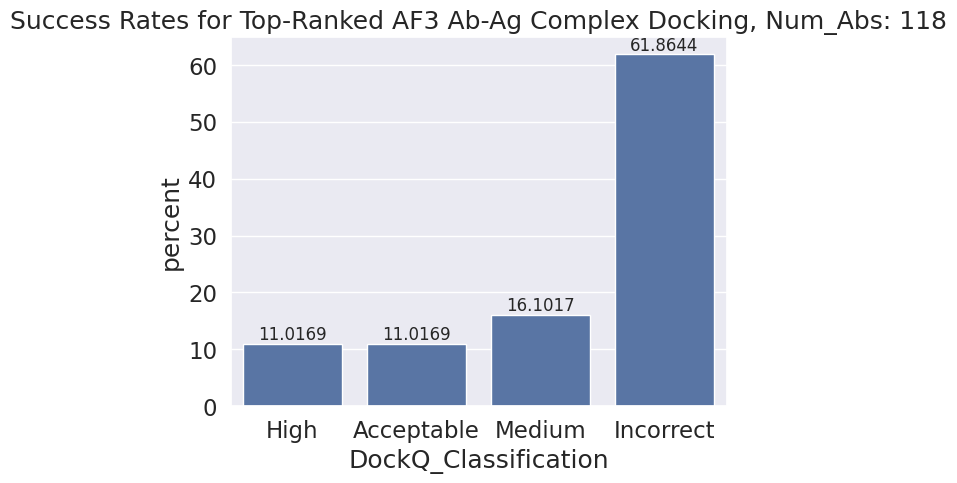

In [24]:
data_df = top_df[(top_df['Bound_Unbound']=='bound')&(top_df['Protein_type']=='antibody')] #.drop_duplicates(subset=['AF3_PDB'])
ax = sns.countplot(data=data_df,x='DockQ_Classification',order=['High','Acceptable','Medium','Incorrect'],stat='percent')
ax.set_title("Success Rates for Top-Ranked AF3 Ab-Ag Complex Docking, Num_Abs: {}".format(data_df.shape[0]))
sns.set(font_scale=1.0)
ax.bar_label(ax.containers[0])
# ax.bar_label(ax.containers[1])
# ax.bar_label(ax.containers[2])
# ax.bar_label(ax.containers[3])
mybenchmark_abs = data_df.PDB_short.unique().tolist()

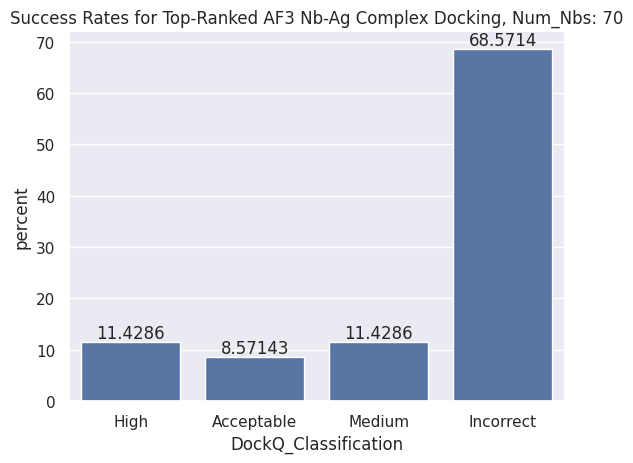

In [25]:
data_df = top_df[(top_df['Bound_Unbound']=='bound')&(top_df['Protein_type']=='nanobody')] #.drop_duplicates(subset=['AF3_PDB'])
ax = sns.countplot(data=data_df,x='DockQ_Classification',order=['High','Acceptable','Medium','Incorrect'],stat='percent')
ax.set_title("Success Rates for Top-Ranked AF3 Nb-Ag Complex Docking, Num_Nbs: {}".format(data_df.shape[0]))
sns.set(font_scale=1.0)
ax.bar_label(ax.containers[0])
# ax.bar_label(ax.containers[1])
# ax.bar_label(ax.containers[2])
# ax.bar_label(ax.containers[3])
mybenchmark_abs = data_df.PDB_short.unique().tolist()

In [44]:
""" OLD: model = 0 is NOT the top-ranked one."""
# data_df = final_af3_benchmark[(final_af3_benchmark['Bound_Unbound']=='bound')&(final_af3_benchmark['Protein_type']=='antibody')&(final_af3_benchmark['Seed']==1)&(final_af3_benchmark['Model']==0)] #.drop_duplicates(subset=['AF3_PDB'])
# ax = sns.countplot(data=data_df,x='DockQ_Classification',order=['High','Acceptable','Medium','Incorrect'],stat='percent')
# ax.set_title("Success Rates for Top-Ranked AF3 Ab-Ag Complex Docking, Num_Abs: {}".format(data_df.shape[0]))
# sns.set(font_scale=1.0)
# ax.bar_label(ax.containers[0])
# # ax.bar_label(ax.containers[1])
# # ax.bar_label(ax.containers[2])
# # ax.bar_label(ax.containers[3])
# mybenchmark_abs = data_df.PDB_short.unique().tolist()

' OLD: model = 0 is NOT the top-ranked one.'

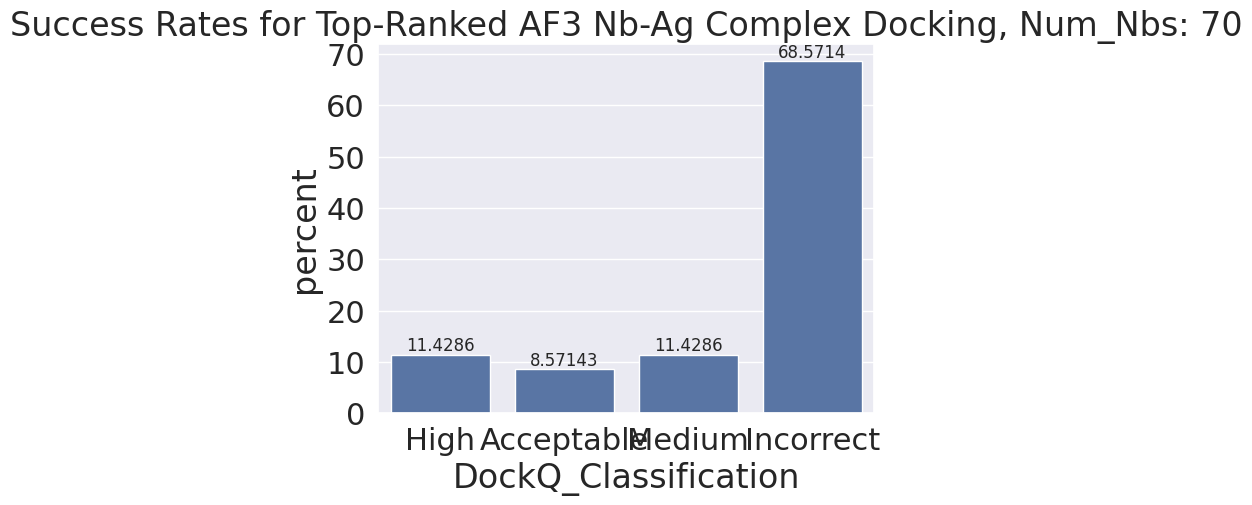

In [ ]:
""" OLD Nb one"""
# data_df = final_af3_benchmark[(final_af3_benchmark['Bound_Unbound']=='bound')&(final_af3_benchmark['Protein_type']=='nanobody')&(final_af3_benchmark['Seed']==1)&(final_af3_benchmark['Model']==0)] #.drop_duplicates(subset=['AF3_PDB'])
# ax = sns.countplot(data=data_df,x='DockQ_Classification',order=['High','Acceptable','Medium','Incorrect'],stat='percent')
# ax.set_title("Success Rates for Top-Ranked AF3 Nb-Ag Complex Docking, Num_Nbs: {}".format(data_df.shape[0]))
# sns.set(font_scale=1.0)
# ax.bar_label(ax.containers[0])
# # ax.bar_label(ax.containers[1])
# # ax.bar_label(ax.containers[2])
# # ax.bar_label(ax.containers[3])
# mybenchmark_nbs = data_df.PDB_short.unique().tolist()

In [27]:
# AF3_ab_results = pd.DataFrame({"Model":['AF3-Server Abs'],"Incorrect":[52.48],"Acceptable":[8.51],"Medium":[16.31],"High":[8.51]})
AF3_ab_results = pd.DataFrame({"Model":['AF3-Server Abs'],"Incorrect":[61.86],"Acceptable":[11.02],"Medium":[16.10],"High":[11.02]})
AF3_nb_results = pd.DataFrame({"Model":['AF3-Server Nbs'],"Incorrect":[68.57],"Acceptable":[8.57],"Medium":[11.43],"High":[11.43]})
newdockqs_summary = pd.concat([newdockqs_summary,AF3_ab_results,AF3_nb_results],axis=0)
melted_dockingcomparison = pd.melt(newdockqs_summary,id_vars=['Model'],value_vars=['Incorrect','Acceptable','Medium','High'],var_name="DockQ Classification",value_name='Success Rate')
newdockqs_summary_cumulative = newdockqs_summary
newdockqs_summary_cumulative
newdockqs_summary_cumulative.loc[:,'Medium'] = [11.94 , 17.91 , 27.12 , 22.86]
newdockqs_summary_cumulative.loc[:,'Acceptable'] = [20.9 , 43.28 , 38.14 , 31.43]
melted_newdockqs_summary_cumulative = pd.melt(newdockqs_summary_cumulative,id_vars=['Model'],value_vars=['Incorrect','Acceptable','Medium','High'],var_name="DockQ Classification",value_name='Success Rate')
# melted_newdockqs_summary_cumulative=melted_newdockqs_summary_cumulative.replace({"Model":{"AF3":"AF3-Server"}})
melted_newdockqs_summary_cumulative

,Model,DockQ Classification,Success Rate
0,AlphaFold-M,Incorrect,79.10
1,AlphaRED,Incorrect,56.72
2,AF3-Server Abs,Incorrect,61.86
3,AF3-Server Nbs,Incorrect,68.57
4,AlphaFold-M,Acceptable,20.90
5,AlphaRED,Acceptable,43.28
6,AF3-Server Abs,Acceptable,38.14
7,AF3-Server Nbs,Acceptable,31.43
8,AlphaFold-M,Medium,11.94
9,AlphaRED,Medium,17.91


In [47]:
""" Old numbers. """
# # AF3_ab_results = pd.DataFrame({"Model":['AF3-Server Abs'],"Incorrect":[52.48],"Acceptable":[8.51],"Medium":[16.31],"High":[8.51]})
# AF3_ab_results = pd.DataFrame({"Model":['AF3-Server Abs'],"Incorrect":[61.02],"Acceptable":[10.17],"Medium":[18.64],"High":[10.17]})
# AF3_nb_results = pd.DataFrame({"Model":['AF3-Server Nbs'],"Incorrect":[68.57],"Acceptable":[8.57],"Medium":[11.43],"High":[11.43]})
# newdockqs_summary = pd.concat([newdockqs_summary,AF3_ab_results,AF3_nb_results],axis=0)
# melted_dockingcomparison = pd.melt(newdockqs_summary,id_vars=['Model'],value_vars=['Incorrect','Acceptable','Medium','High'],var_name="DockQ Classification",value_name='Success Rate')
# newdockqs_summary_cumulative = newdockqs_summary
# newdockqs_summary_cumulative
# newdockqs_summary_cumulative.loc[:,'Medium'] = [11.94 , 17.91 , 28.81 , 22.86]
# newdockqs_summary_cumulative.loc[:,'Acceptable'] = [20.9 , 43.28 , 38.98 , 31.43]
# melted_newdockqs_summary_cumulative = pd.melt(newdockqs_summary_cumulative,id_vars=['Model'],value_vars=['Incorrect','Acceptable','Medium','High'],var_name="DockQ Classification",value_name='Success Rate')
# # melted_newdockqs_summary_cumulative=melted_newdockqs_summary_cumulative.replace({"Model":{"AF3":"AF3-Server"}})
# melted_newdockqs_summary_cumulative

' Old numbers. '

# Panels

## Panel 1: DockQ

/tmp/ipykernel_3821784/3337355186.py:7: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax =sns.barplot(data=melted_newdockqs_summary_cumulative[melted_newdockqs_summary_cumulative['DockQ Classification']!='Incorrect'],\
/tmp/ipykernel_3821784/3337355186.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['AF2-M \nAbs \nN=67','AlphaRED \nAbs \nN=67','AF3-Server \nAbs \nN=118', 'AF3-Server \nNbs \nN=70'])


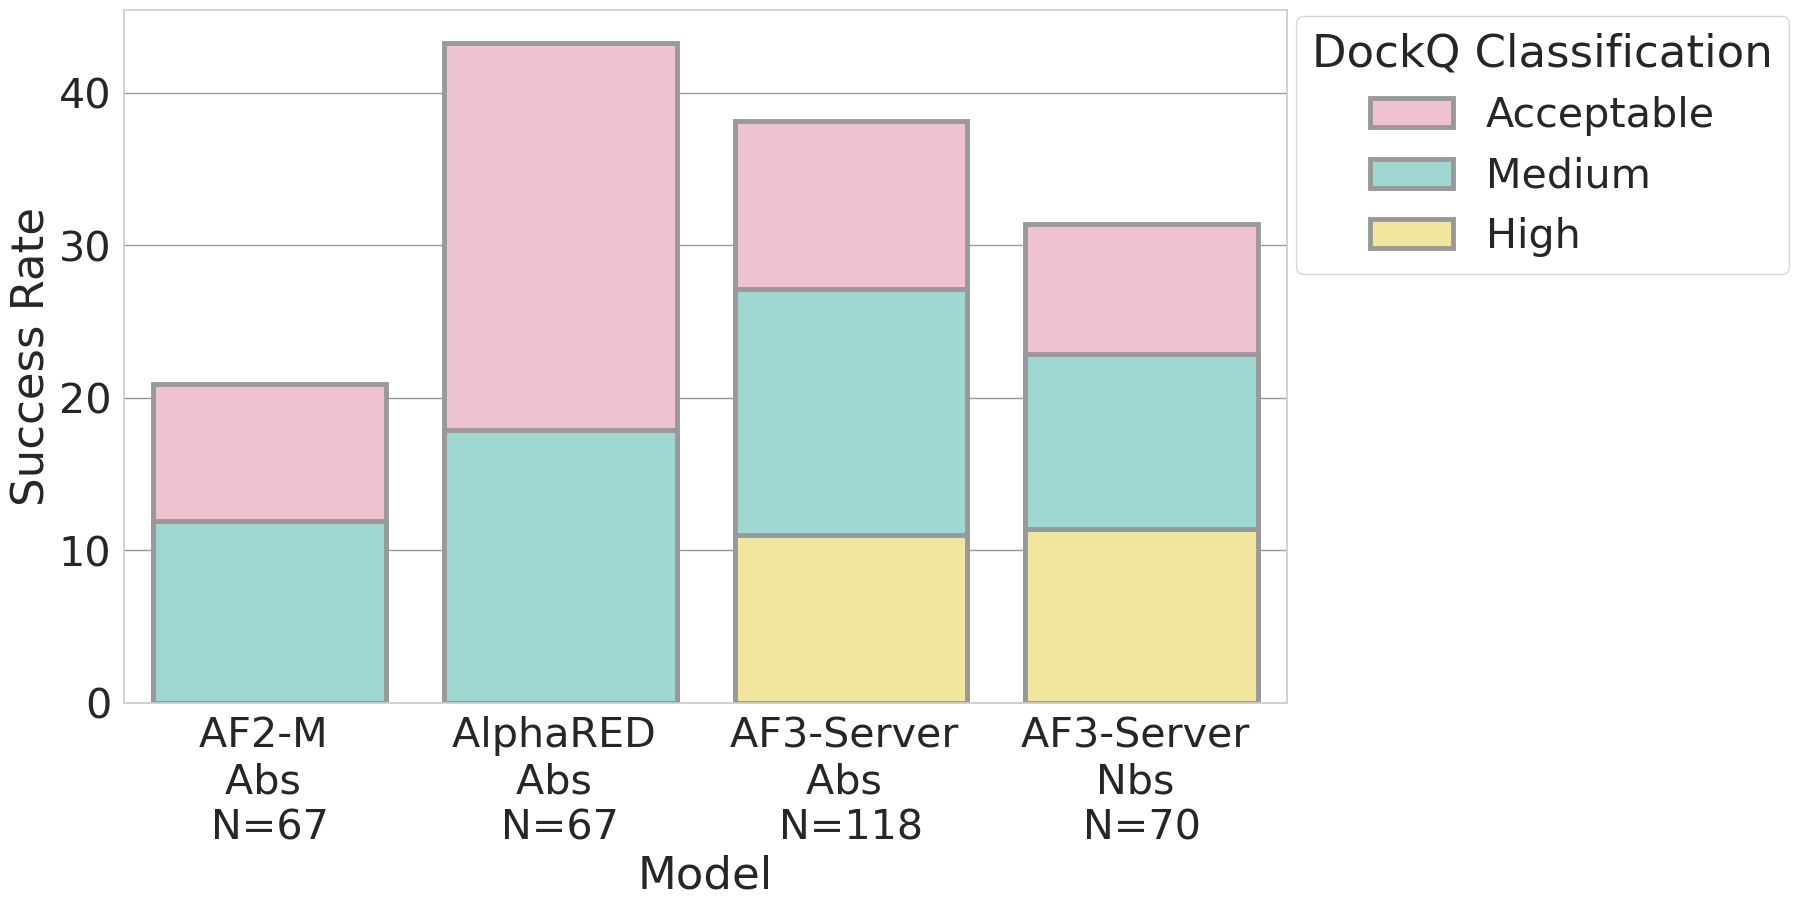

In [32]:
plt.figure(figsize=(15,9))

sns.set_style("whitegrid",{"grid.color":"0.6"})
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="ticks", rc=custom_params,font_scale=2)
# melted_newdockqs_summary_cumulative=melted_newdockqs_summary_cumulative.replace({"Model":{"AF3":"AF3-Server"}})
ax =sns.barplot(data=melted_newdockqs_summary_cumulative[melted_newdockqs_summary_cumulative['DockQ Classification']!='Incorrect'],\
                x='Model',y='Success Rate',hue='DockQ Classification',\
                    # ,facecolor=(0, 0, 0, 0),\
                    # linewidth=5,
                #    edgecolor=palette,\
                    edgecolor=".6",\
                    lw=3.5,
                    order=['AlphaFold-M','AlphaRED','AF3-Server Abs','AF3-Server Nbs']\
                    ,dodge=False,palette=pastel_palette[:-1])
# ax.set_title("Ab Docking Success Rate Comparison Between Models")
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.45, 1.021))
sns.set(font_scale=2.7)
ax.set(xticklabels=['AF2-M \nAbs \nN=67','AlphaRED \nAbs \nN=67','AF3-Server \nAbs \nN=118', 'AF3-Server \nNbs \nN=70']) 
plt.savefig(f"{filepath}top_ranked_DockQ_barplot.svg",format='svg',dpi=500,transparent=True,bbox_inches='tight')

## Panel 2: P(X)

### Abs

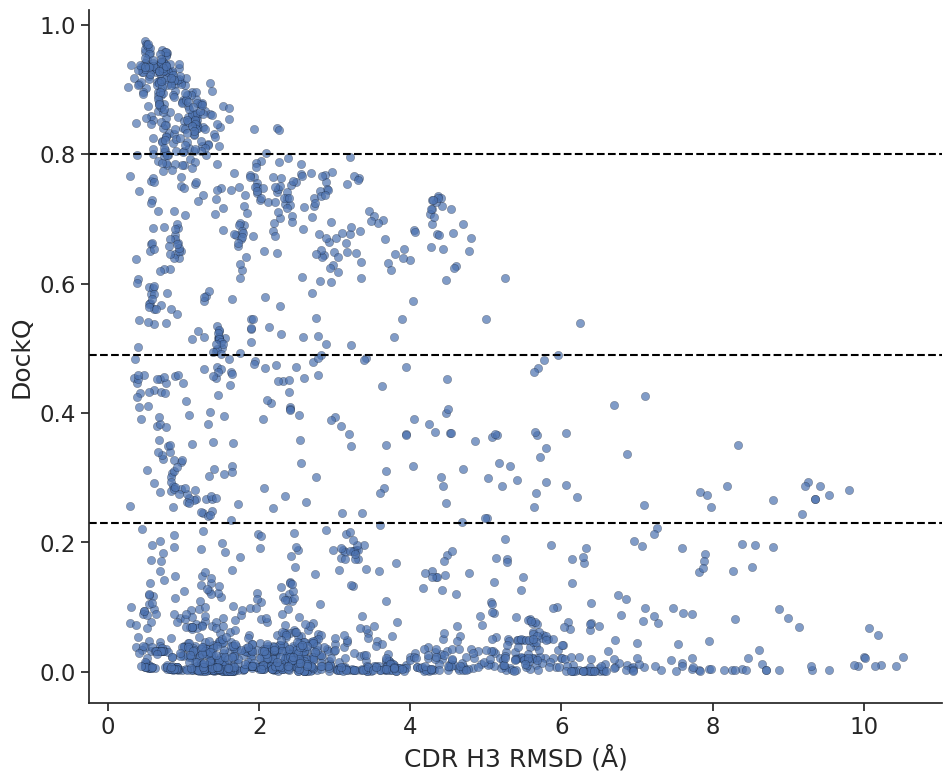

In [34]:
plt.figure(figsize=(11,9))
# sns.set_style('whitegrid',{"grid.color":"0.6"})
data_df = final_af3_benchmark[final_af3_benchmark['Protein_type']=='antibody']
# sns.set_style('whitegrid',{"grid.color":"0.6"})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params,font_scale=1.5)
#data_df[(data_df['Seed']==2)&(data_df['Model']==0)&(data_df['l3_rms']<3)]
# ax = sns.scatterplot(data=data_df[data_df['Protein_type']=='antibody'],x='h3_rms',y='DockQ',\
ax = sns.scatterplot(data=data_df,x='h3_rms',y='DockQ',\
                     alpha=0.7,edgecolor=edgecolor,linewidth=0.2)
# ax = sns.kdeplot(data=full_benchmark_withdockq[full_benchmark_withdockq['Protein_type']=='nanobody'],x='h3_rms',y='DockQ',hue='h3_len') #,size='h3_len')
# ax.set_title("Correlation of DockQ to Antibody H3 Accuracy")
# plt.legend(loc='upper right')
sns.set(font_scale=1.0)
# ax.axvline(x=1,ls='--',color='black')
ax.axhline(y=0.23,ls='--',color='black')
ax.axhline(y=0.49,ls='--',color='black')
ax.axhline(y=0.80,ls='--',color='black')
plt.xlabel('CDR H3 RMSD (Å)')
# sns.move_legend(ax, "upper right", bbox_to_anchor=(1.6, 1.05))
# sns.lmplot(data=full_benchmark_withdockq[full_benchmark_withdockq['Protein_type']=='nanobody'],x='h3_rms',y='DockQ') #.set_title("Correlation of DockQ to H3 Accuracy")
plt.savefig(f"{filepath}DockQ_v_H3RMSD_Abs.svg",format='svg',dpi=700,transparent=True,bbox_inches='tight')

### Sub-1Å Abs

Probability Tables:

In [99]:
data_df = final_af3_benchmark

In [100]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.33710407239819007
probability of high DockQ given high H3: 0.04564820450395617
Enrichment of DockQ score given high H3: 7.384826546003018
Enrichment of H3 RMSD given high DockQ score: 6.227955120101137
p(low h3 rmsd | high DockQ score) is 0.6651785714285714 
p(high DockQ score | low h3 rmsd) is 0.33710407239819007


In [101]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highmeddockq = data_df[(data_df['Protein_type']=='antibody') & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highmeddockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highmeddockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highmeddockq = p_joint_lowh3_highmeddockq/p_highmeddockq
p_highh3_given_highmeddockq = p_joint_highh3_highmeddockq/p_highmeddockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmeddockq_given_highh3 = p_joint_highh3_highmeddockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmeddockq_given_lowh3 = p_joint_lowh3_highmeddockq/p_lowh3
E_dockq_changeinh3 = p_highmeddockq_given_lowh3/p_highmeddockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highmeddockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highmeddockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmeddockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high+med DockQ score) is {p_lowh3_given_highmeddockq} \np(high+med DockQ score | low h3 rmsd) is {p_highmeddockq_given_lowh3}")


probability of high DockQ given Low H3: 0.5
probability of high DockQ given high H3: 0.17954960438222764
Enrichment of DockQ score given high H3: 2.7847457627118644
Enrichment of H3 RMSD given high DockQ score: 4.010050078891404
p(low h3 rmsd | high DockQ score) is 0.42829457364341084 
p(high DockQ score | low h3 rmsd) is 0.5


In [102]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highmedaccptdockq = data_df[(data_df['Protein_type']=='antibody') & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1) & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1) & \
                                                        ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highmedaccptdockq = p_joint_lowh3_highmedaccptdockq/p_highmedaccptdockq
p_highh3_given_highmedaccptdockq = p_joint_highh3_highmedaccptdockq/p_highmedaccptdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmedaccptdockq_given_highh3 = p_joint_highh3_highmedaccptdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmedaccptdockq_given_lowh3 = p_joint_lowh3_highmedaccptdockq/p_lowh3
E_dockq_changeinh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highmedaccptdockq/p_lowh3_given_lowdockq
E_dockq_givenh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq
E_h3_givendockq = p_lowh3_given_highmedaccptdockq/p_lowh3
print(f"probability of high DockQ given Low H3: {p_highmedaccptdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmedaccptdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"Enrichment of DockQ given good H3 vs no H3 specifics: {E_dockq_givenh3}")
print(f"Enrichment of H3 given good DockQ vs no DockQ specifics: {E_h3_givendockq}")
print(f"p(low h3 rmsd | high+med+accept DockQ score) is {p_lowh3_given_highmedaccptdockq} \np(high+med+accept DockQ score | low h3 rmsd) is {p_highmedaccptdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.6176470588235295
probability of high DockQ given high H3: 0.2671941570298235
Enrichment of DockQ score given high H3: 2.3116039126356696
Enrichment of H3 RMSD given high DockQ score: 3.5899622153723776
Enrichment of DockQ given good H3 vs no H3 specifics: 1.8086996034368807
Enrichment of H3 given good DockQ vs no DockQ specifics: 1.8086996034368805
p(low h3 rmsd | high DockQ score) is 0.38342696629213485 
p(high DockQ score | low h3 rmsd) is 0.6176470588235295


In [103]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")
print(f"p(low h3 rmsd | Incorrect DockQ) is {p_lowh3_given_lowdockq} \np(Incorrect DockQ | low h3 rmsd) is {p_lowdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.33710407239819007
probability of high DockQ given high H3: 0.04564820450395617
Enrichment of DockQ score given high H3: 7.384826546003018
Enrichment of H3 RMSD given high DockQ score: 6.227955120101137
p(low h3 rmsd | high DockQ score) is 0.6651785714285714 
p(high DockQ score | low h3 rmsd) is 0.33710407239819007
p(low h3 rmsd | Incorrect DockQ) is 0.10680529300567108 
p(Incorrect DockQ | low h3 rmsd) is 0.25565610859728505


### <1.5 Å Abs

Probability Tables:

In [104]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1.5)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.27784891165172854
probability of high DockQ given high H3: 0.005368098159509203
Enrichment of DockQ score given high H3: 51.75928297055057
Enrichment of H3 RMSD given high DockQ score: 3.713541666666667
p(low h3 rmsd | high DockQ score) is 0.96875 
p(high DockQ score | low h3 rmsd) is 0.27784891165172854


In [105]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highmeddockq = data_df[(data_df['Protein_type']=='antibody') & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highmeddockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1.5) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highmeddockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highmeddockq = p_joint_lowh3_highmeddockq/p_highmeddockq
p_highh3_given_highmeddockq = p_joint_highh3_highmeddockq/p_highmeddockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmeddockq_given_highh3 = p_joint_highh3_highmeddockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmeddockq_given_lowh3 = p_joint_lowh3_highmeddockq/p_lowh3
E_dockq_changeinh3 = p_highmeddockq_given_lowh3/p_highmeddockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highmeddockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highmeddockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmeddockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high+med DockQ score) is {p_lowh3_given_highmeddockq} \np(high+med DockQ score | low h3 rmsd) is {p_highmeddockq_given_lowh3}")


probability of high DockQ given Low H3: 0.4186939820742638
probability of high DockQ given high H3: 0.11503347534996956
Enrichment of DockQ score given high H3: 3.639757738349288
Enrichment of H3 RMSD given high DockQ score: 2.429263565891473
p(low h3 rmsd | high DockQ score) is 0.6337209302325582 
p(high DockQ score | low h3 rmsd) is 0.4186939820742638


In [106]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1.5)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highmedaccptdockq = data_df[(data_df['Protein_type']=='antibody') & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1.5) & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5) & \
                                                        ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highmedaccptdockq = p_joint_lowh3_highmedaccptdockq/p_highmedaccptdockq
p_highh3_given_highmedaccptdockq = p_joint_highh3_highmedaccptdockq/p_highmedaccptdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmedaccptdockq_given_highh3 = p_joint_highh3_highmedaccptdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmedaccptdockq_given_lowh3 = p_joint_lowh3_highmedaccptdockq/p_lowh3
E_dockq_changeinh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highmedaccptdockq/p_lowh3_given_lowdockq
E_dockq_givenh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq
E_h3_givendockq = p_lowh3_given_highmedaccptdockq/p_lowh3
print(f"probability of high DockQ given Low H3: {p_highmedaccptdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmedaccptdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"Enrichment of DockQ given good H3 vs no H3 specifics: {E_dockq_givenh3}")
print(f"Enrichment of H3 given good DockQ vs no DockQ specifics: {E_h3_givendockq}")
print(f"p(low h3 rmsd | high+med+accept DockQ score) is {p_lowh3_given_highmedaccptdockq} \np(high+med+accept DockQ score | low h3 rmsd) is {p_highmedaccptdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.5262483994878362
probability of high DockQ given high H3: 0.23082822085889573
Enrichment of DockQ score given high H3: 2.279826953262918
Enrichment of H3 RMSD given high DockQ score: 2.212780898876405
Enrichment of DockQ given good H3 vs no H3 specifics: 1.5410504395114304
Enrichment of H3 given good DockQ vs no DockQ specifics: 1.5410504395114304
p(low h3 rmsd | high DockQ score) is 0.577247191011236 
p(high DockQ score | low h3 rmsd) is 0.5262483994878362


In [107]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1.5)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")
print(f"p(low h3 rmsd | Incorrect DockQ) is {p_lowh3_given_lowdockq} \np(Incorrect DockQ | low h3 rmsd) is {p_lowdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.27784891165172854
probability of high DockQ given high H3: 0.005368098159509203
Enrichment of DockQ score given high H3: 51.75928297055057
Enrichment of H3 RMSD given high DockQ score: 3.713541666666667
p(low h3 rmsd | high DockQ score) is 0.96875 
p(high DockQ score | low h3 rmsd) is 0.27784891165172854
p(low h3 rmsd | Incorrect DockQ) is 0.2608695652173913 
p(Incorrect DockQ | low h3 rmsd) is 0.353393085787452


### <2 Å Abs

Probability Tables:

In [108]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
# E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
# E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.22413793103448276
probability of high DockQ given high H3: 0.00272975432211101
Enrichment of DockQ score given high H3: 51.75928297055057
Enrichment of H3 RMSD given high DockQ score: 3.713541666666667
p(low h3 rmsd | high DockQ score) is 0.9866071428571429 
p(high DockQ score | low h3 rmsd) is 0.22413793103448276


In [109]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highmeddockq = data_df[(data_df['Protein_type']=='antibody') & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highmeddockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highmeddockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highmeddockq = p_joint_lowh3_highmeddockq/p_highmeddockq
p_highh3_given_highmeddockq = p_joint_highh3_highmeddockq/p_highmeddockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmeddockq_given_highh3 = p_joint_highh3_highmeddockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmeddockq_given_lowh3 = p_joint_lowh3_highmeddockq/p_lowh3
E_dockq_changeinh3 = p_highmeddockq_given_lowh3/p_highmeddockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highmeddockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highmeddockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmeddockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high+med DockQ score) is {p_lowh3_given_highmeddockq} \np(high+med DockQ score | low h3 rmsd) is {p_highmeddockq_given_lowh3}")


probability of high DockQ given Low H3: 0.3803245436105477
probability of high DockQ given high H3: 0.12829845313921748
Enrichment of DockQ score given high H3: 2.96437357041129
Enrichment of H3 RMSD given high DockQ score: 1.956476714598497
p(low h3 rmsd | high DockQ score) is 0.7267441860465116 
p(high DockQ score | low h3 rmsd) is 0.3803245436105477


In [110]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highmedaccptdockq = data_df[(data_df['Protein_type']=='antibody') & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2) & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2) & \
                                                        ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highmedaccptdockq = p_joint_lowh3_highmedaccptdockq/p_highmedaccptdockq
p_highh3_given_highmedaccptdockq = p_joint_highh3_highmedaccptdockq/p_highmedaccptdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmedaccptdockq_given_highh3 = p_joint_highh3_highmedaccptdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmedaccptdockq_given_lowh3 = p_joint_lowh3_highmedaccptdockq/p_lowh3
E_dockq_changeinh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highmedaccptdockq/p_lowh3_given_lowdockq
E_dockq_givenh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq
E_h3_givendockq = p_lowh3_given_highmedaccptdockq/p_lowh3
print(f"probability of high DockQ given Low H3: {p_highmedaccptdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmedaccptdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"Enrichment of DockQ given good H3 vs no H3 specifics: {E_dockq_givenh3}")
print(f"Enrichment of H3 given good DockQ vs no DockQ specifics: {E_h3_givendockq}")
print(f"p(low h3 rmsd | high+med+accept DockQ score) is {p_lowh3_given_highmedaccptdockq} \np(high+med+accept DockQ score | low h3 rmsd) is {p_highmedaccptdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.4787018255578094
probability of high DockQ given high H3: 0.2183803457688808
Enrichment of DockQ score given high H3: 2.192055442866802
Enrichment of H3 RMSD given high DockQ score: 1.7846584898647682
Enrichment of DockQ given good H3 vs no H3 specifics: 1.4018164414157759
Enrichment of H3 given good DockQ vs no DockQ specifics: 1.4018164414157759
p(low h3 rmsd | high DockQ score) is 0.6629213483146067 
p(high DockQ score | low h3 rmsd) is 0.4787018255578094


In [111]:
p_lowh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2)].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='antibody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='antibody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='antibody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
# E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
# E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")
print(f"p(low h3 rmsd | Incorrect DockQ) is {p_lowh3_given_lowdockq} \np(Incorrect DockQ | low h3 rmsd) is {p_lowdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.22413793103448276
probability of high DockQ given high H3: 0.00272975432211101
Enrichment of DockQ score given high H3: 2.192055442866802
Enrichment of H3 RMSD given high DockQ score: 1.7846584898647682
p(low h3 rmsd | high DockQ score) is 0.9866071428571429 
p(high DockQ score | low h3 rmsd) is 0.22413793103448276
p(low h3 rmsd | Incorrect DockQ) is 0.3714555765595463 
p(Incorrect DockQ | low h3 rmsd) is 0.39858012170385393


### Nbs

/tmp/ipykernel_3821784/3516365089.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=data_df,x='h3_rms',y='DockQ',\


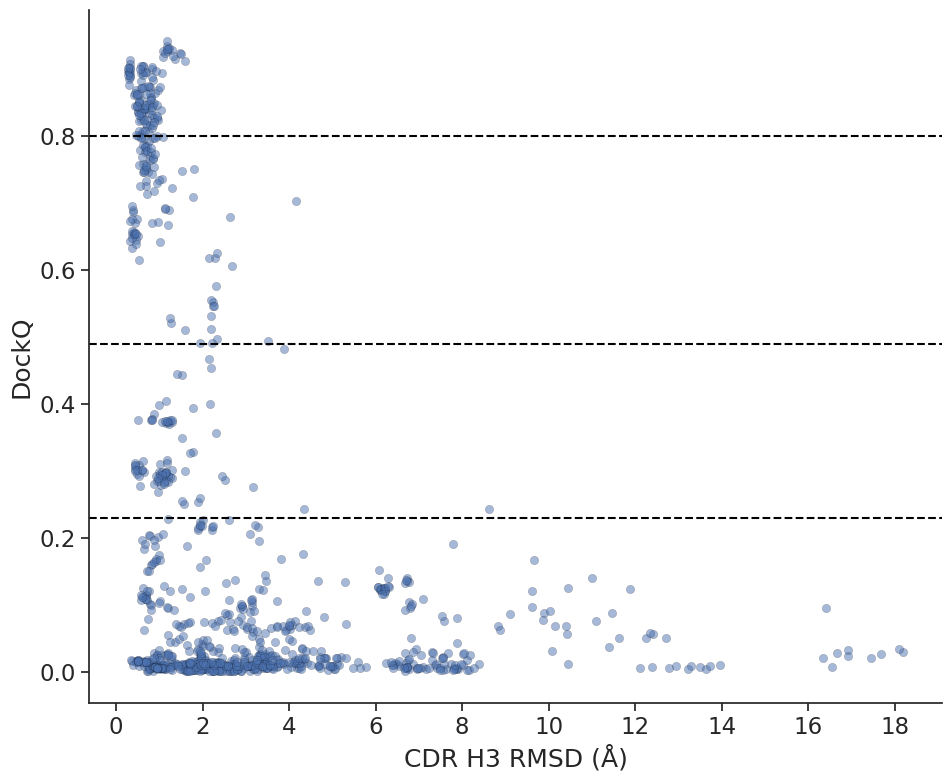

In [33]:
plt.figure(figsize=(11,9))
# sns.set_style('whitegrid',{"grid.color":"0.6"})
data_df = final_af3_benchmark[final_af3_benchmark['Protein_type']=='nanobody']
# sns.set_style('whitegrid',{"grid.color":"0.6"})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params,font_scale=1.5)
# ax = sns.scatterplot(data=data_df[data_df['Protein_type']=='antibody'],x='h3_rms',y='DockQ',\
ax = sns.scatterplot(data=data_df,x='h3_rms',y='DockQ',\
                     alpha=0.5,palette='mako',edgecolor=edgecolor,linewidth=0.2)
# ax = sns.kdeplot(data=full_benchmark_withdockq[full_benchmark_withdockq['Protein_type']=='nanobody'],x='h3_rms',y='DockQ',hue='h3_len') #,size='h3_len')
# ax.set_title("Correlation of DockQ to Antibody H3 Accuracy")
# plt.legend(loc='upper right')
sns.set(font_scale=1.0)
ax.axhline(y=0.23,ls='--',color='black')
ax.axhline(y=0.49,ls='--',color='black')
ax.axhline(y=0.80,ls='--',color='black')
ax.set(xticks=range(0,20,2))
plt.xlabel('CDR H3 RMSD (Å)')
# sns.move_legend(ax, "upper right", bbox_to_anchor=(1.6, 1.05))
# sns.lmplot(data=full_benchmark_withdockq[full_benchmark_withdockq['Protein_type']=='nanobody'],x='h3_rms',y='DockQ') #.set_title("Correlation of DockQ to H3 Accuracy")
plt.savefig(f"{filepath}DockQ_v_H3RMSD_Nbs.svg",format='svg',dpi=700,transparent=True,bbox_inches='tight')

### Sub-1Å Nbs

Probability Tables:

In [113]:
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.3322259136212624
probability of high DockQ given high H3: 0.02107728337236534
Enrichment of DockQ score given high H3: 15.762273901808785
Enrichment of H3 RMSD given high DockQ score: 6.333630686886707
p(low h3 rmsd | high DockQ score) is 0.847457627118644 
p(high DockQ score | low h3 rmsd) is 0.3322259136212624


In [114]:
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highmeddockq = data_df[(data_df['Protein_type']=='nanobody') & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highmeddockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highmeddockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highmeddockq = p_joint_lowh3_highmeddockq/p_highmeddockq
p_highh3_given_highmeddockq = p_joint_highh3_highmeddockq/p_highmeddockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmeddockq_given_highh3 = p_joint_highh3_highmeddockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmeddockq_given_lowh3 = p_joint_lowh3_highmeddockq/p_lowh3
E_dockq_changeinh3 = p_highmeddockq_given_lowh3/p_highmeddockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highmeddockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highmeddockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmeddockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high+med DockQ score) is {p_lowh3_given_highmeddockq} \np(high+med DockQ score | low h3 rmsd) is {p_highmeddockq_given_lowh3}")


probability of high DockQ given Low H3: 0.5448504983388704
probability of high DockQ given high H3: 0.05737704918032787
Enrichment of DockQ score given high H3: 9.495965828191743
Enrichment of H3 RMSD given high DockQ score: 5.75438596491228
p(low h3 rmsd | high DockQ score) is 0.7699530516431925 
p(high DockQ score | low h3 rmsd) is 0.5448504983388704


In [115]:
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highmedaccptdockq = data_df[(data_df['Protein_type']=='nanobody') & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1) & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1) & \
                                                        ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highmedaccptdockq = p_joint_lowh3_highmedaccptdockq/p_highmedaccptdockq
p_highh3_given_highmedaccptdockq = p_joint_highh3_highmedaccptdockq/p_highmedaccptdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmedaccptdockq_given_highh3 = p_joint_highh3_highmedaccptdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmedaccptdockq_given_lowh3 = p_joint_lowh3_highmedaccptdockq/p_lowh3
E_dockq_changeinh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highmedaccptdockq/p_lowh3_given_lowdockq
E_dockq_givenh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq
E_h3_givendockq = p_lowh3_given_highmedaccptdockq/p_lowh3
print(f"probability of high DockQ given Low H3: {p_highmedaccptdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmedaccptdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"Enrichment of DockQ given good H3 vs no H3 specifics: {E_dockq_givenh3}")
print(f"Enrichment of H3 given good DockQ vs no DockQ specifics: {E_h3_givendockq}")
print(f"p(low h3 rmsd | high+med+accept DockQ score) is {p_lowh3_given_highmedaccptdockq} \np(high+med+accept DockQ score | low h3 rmsd) is {p_highmedaccptdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.6345514950166112
probability of high DockQ given high H3: 0.12177985948477753
Enrichment of DockQ score given high H3: 5.210644007155634
Enrichment of H3 RMSD given high DockQ score: 4.838893844781444
Enrichment of DockQ given good H3 vs no H3 specifics: 2.4844304296413084
Enrichment of H3 given good DockQ vs no DockQ specifics: 2.484430429641308
p(low h3 rmsd | high DockQ score) is 0.647457627118644 
p(high DockQ score | low h3 rmsd) is 0.6345514950166112


In [116]:
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_lowdockq} \np(high DockQ score | low h3 rmsd) is {p_lowdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.3322259136212624
probability of high DockQ given high H3: 0.02107728337236534
Enrichment of DockQ score given high H3: 15.762273901808785
Enrichment of H3 RMSD given high DockQ score: 6.333630686886707
p(low h3 rmsd | high DockQ score) is 0.847457627118644 
p(high DockQ score | low h3 rmsd) is 0.3322259136212624
p(low h3 rmsd | high DockQ score) is 0.13380281690140847 
p(high DockQ score | low h3 rmsd) is 0.31561461794019935


### <1.5 Å Nbs

Probability Tables:

In [117]:
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1.5)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1.5)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
# E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
# print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")
print(f"p(low h3 rmsd | low DockQ score) is {p_lowh3_given_lowdockq} \np(low DockQ score | low h3 rmsd) is {p_lowdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.27336448598130847
probability of high DockQ given high H3: 0.001375515818431912
Enrichment of H3 RMSD given high DockQ score: 4.455588929414288
p(low h3 rmsd | high DockQ score) is 0.9915254237288136 
p(high DockQ score | low h3 rmsd) is 0.27336448598130847
p(low h3 rmsd | low DockQ score) is 0.22253521126760567 
p(low DockQ score | low h3 rmsd) is 0.36915887850467294


In [118]:
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1.5)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='antibody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highmeddockq = data_df[(data_df['Protein_type']=='nanobody') & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highmeddockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1.5) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highmeddockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1.5) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highmeddockq = p_joint_lowh3_highmeddockq/p_highmeddockq
p_highh3_given_highmeddockq = p_joint_highh3_highmeddockq/p_highmeddockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmeddockq_given_highh3 = p_joint_highh3_highmeddockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmeddockq_given_lowh3 = p_joint_lowh3_highmeddockq/p_lowh3
E_dockq_changeinh3 = p_highmeddockq_given_lowh3/p_highmeddockq_given_highh3
# E_h3_changeindockq = p_lowh3_given_highmeddockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highmeddockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmeddockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
# print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high+med DockQ score) is {p_lowh3_given_highmeddockq} \np(high+med DockQ score | low h3 rmsd) is {p_highmeddockq_given_lowh3}")


probability of high DockQ given Low H3: 0.4462616822429907
probability of high DockQ given high H3: 0.025761124121779864
Enrichment of DockQ score given high H3: 17.32306711979609
p(low h3 rmsd | high DockQ score) is 0.8967136150234741 
p(high DockQ score | low h3 rmsd) is 0.4462616822429907


In [119]:
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1.5)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1.5)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highmedaccptdockq = data_df[(data_df['Protein_type']=='nanobody') & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1.5) & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1.5) & \
                                                        ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highmedaccptdockq = p_joint_lowh3_highmedaccptdockq/p_highmedaccptdockq
p_highh3_given_highmedaccptdockq = p_joint_highh3_highmedaccptdockq/p_highmedaccptdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmedaccptdockq_given_highh3 = p_joint_highh3_highmedaccptdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmedaccptdockq_given_lowh3 = p_joint_lowh3_highmedaccptdockq/p_lowh3
E_dockq_changeinh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highmedaccptdockq/p_lowh3_given_lowdockq
E_dockq_givenh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq
E_h3_givendockq = p_lowh3_given_highmedaccptdockq/p_lowh3
print(f"probability of high DockQ given Low H3: {p_highmedaccptdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmedaccptdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"Enrichment of DockQ given good H3 vs no H3 specifics: {E_dockq_givenh3}")
print(f"Enrichment of H3 given good DockQ vs no DockQ specifics: {E_h3_givendockq}")
print(f"p(low h3 rmsd | high+med+accept DockQ score) is {p_lowh3_given_highmedaccptdockq} \np(high+med+accept DockQ score | low h3 rmsd) is {p_highmedaccptdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.5911214953271028
probability of high DockQ given high H3: 0.057771664374140295
Enrichment of DockQ score given high H3: 10.232031597685804
Enrichment of H3 RMSD given high DockQ score: 3.8538940141600504
Enrichment of DockQ given good H3 vs no H3 specifics: 2.314390939331538
Enrichment of H3 given good DockQ vs no DockQ specifics: 2.314390939331538
p(low h3 rmsd | high DockQ score) is 0.8576271186440677 
p(high DockQ score | low h3 rmsd) is 0.5911214953271028


In [76]:
# Add incorrect one
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1.5)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1.5)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<1.5) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>1.5) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")
print(f"p(low h3 rmsd | Incorrect DockQ) is {p_lowh3_given_lowdockq} \np(Incorrect DockQ | low h3 rmsd) is {p_lowdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.27336448598130847
probability of high DockQ given high H3: 0.001375515818431912
Enrichment of DockQ score given high H3: 198.73598130841125
Enrichment of H3 RMSD given high DockQ score: 4.455588929414288
p(low h3 rmsd | high DockQ score) is 0.9915254237288136 
p(high DockQ score | low h3 rmsd) is 0.27336448598130847
p(low h3 rmsd | Incorrect DockQ) is 0.22253521126760567 
p(Incorrect DockQ | low h3 rmsd) is 0.36915887850467294


### <2 Å Nbs

Probability Tables:

In [72]:
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
# E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
# E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.20921985815602837
probability of high DockQ given high H3: 0.0
Enrichment of DockQ score given high H3: 10.232031597685804
Enrichment of H3 RMSD given high DockQ score: 3.8538940141600504
p(low h3 rmsd | high DockQ score) is 1.0 
p(high DockQ score | low h3 rmsd) is 0.20921985815602837


In [73]:
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highmeddockq = data_df[(data_df['Protein_type']=='nanobody') & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highmeddockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highmeddockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2) & ((data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highmeddockq = p_joint_lowh3_highmeddockq/p_highmeddockq
p_highh3_given_highmeddockq = p_joint_highh3_highmeddockq/p_highmeddockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmeddockq_given_highh3 = p_joint_highh3_highmeddockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmeddockq_given_lowh3 = p_joint_lowh3_highmeddockq/p_lowh3
E_dockq_changeinh3 = p_highmeddockq_given_lowh3/p_highmeddockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highmeddockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highmeddockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmeddockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high+med DockQ score) is {p_lowh3_given_highmeddockq} \np(high+med DockQ score | low h3 rmsd) is {p_highmeddockq_given_lowh3}")


probability of high DockQ given Low H3: 0.34929078014184395
probability of high DockQ given high H3: 0.027072758037225045
Enrichment of DockQ score given high H3: 12.90192819148936
Enrichment of H3 RMSD given high DockQ score: 2.713498622589531
p(low h3 rmsd | high DockQ score) is 0.9248826291079811 
p(high DockQ score | low h3 rmsd) is 0.34929078014184395


In [74]:
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highmedaccptdockq = data_df[(data_df['Protein_type']=='nanobody') & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2) & ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highmedaccptdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2) & \
                                                        ((data_df['DockQ_Classification']=='Acceptable')|(data_df['DockQ_Classification']=='Medium')|(data_df['DockQ_Classification']=='High'))].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highmedaccptdockq = p_joint_lowh3_highmedaccptdockq/p_highmedaccptdockq
p_highh3_given_highmedaccptdockq = p_joint_highh3_highmedaccptdockq/p_highmedaccptdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highmedaccptdockq_given_highh3 = p_joint_highh3_highmedaccptdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highmedaccptdockq_given_lowh3 = p_joint_lowh3_highmedaccptdockq/p_lowh3
E_dockq_changeinh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq_given_highh3
E_h3_changeindockq = p_lowh3_given_highmedaccptdockq/p_lowh3_given_lowdockq
E_dockq_givenh3 = p_highmedaccptdockq_given_lowh3/p_highmedaccptdockq
E_h3_givendockq = p_lowh3_given_highmedaccptdockq/p_lowh3
print(f"probability of high DockQ given Low H3: {p_highmedaccptdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highmedaccptdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"Enrichment of DockQ given good H3 vs no H3 specifics: {E_dockq_givenh3}")
print(f"Enrichment of H3 given good DockQ vs no DockQ specifics: {E_h3_givendockq}")
print(f"p(low h3 rmsd | high+med+accept DockQ score) is {p_lowh3_given_highmedaccptdockq} \np(high+med+accept DockQ score | low h3 rmsd) is {p_highmedaccptdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.47695035460992913
probability of high DockQ given high H3: 0.0439932318104907
Enrichment of DockQ score given high H3: 10.841448445171848
Enrichment of H3 RMSD given high DockQ score: 2.67530466451884
Enrichment of DockQ given good H3 vs no H3 specifics: 1.8673818968626037
Enrichment of H3 given good DockQ vs no DockQ specifics: 1.867381896862604
p(low h3 rmsd | high DockQ score) is 0.9118644067796611 
p(high DockQ score | low h3 rmsd) is 0.47695035460992913


In [75]:
p_lowh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_lowdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='Incorrect')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_lowh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_highh3 = data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2)].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_highdockq = data_df[(data_df['Protein_type']=='nanobody') & (data_df['DockQ_Classification']=='High')].shape[0]/data_df[data_df['Protein_type']=='nanobody'].shape[0]
p_joint_highh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_lowh3_highdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']<2) & (data_df['DockQ_Classification']=='High')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_joint_highh3_lowdockq = (data_df[(data_df['Protein_type']=='nanobody') & (data_df['h3_rms']>2) & (data_df['DockQ_Classification']=='Incorrect')].shape[0]) / data_df[data_df['Protein_type']=='nanobody'].shape[0]

p_lowh3_given_highdockq = p_joint_lowh3_highdockq/p_highdockq
p_highh3_given_highdockq = p_joint_highh3_highdockq/p_highdockq

p_lowh3_given_lowdockq = p_joint_lowh3_lowdockq/p_lowdockq
p_highh3_given_lowdockq = p_joint_highh3_lowdockq/p_lowdockq

p_lowdockq_given_highh3 = p_joint_highh3_lowdockq/p_highh3
p_highdockq_given_highh3 = p_joint_highh3_highdockq/p_highh3

p_lowdockq_given_lowh3 = p_joint_lowh3_lowdockq/p_lowh3
p_highdockq_given_lowh3 = p_joint_lowh3_highdockq/p_lowh3
# E_dockq_changeinh3 = p_highdockq_given_lowh3/p_highdockq_given_highh3
# E_h3_changeindockq = p_lowh3_given_highdockq/p_lowh3_given_lowdockq
print(f"probability of high DockQ given Low H3: {p_highdockq_given_lowh3}")
print(f"probability of high DockQ given high H3: {p_highdockq_given_highh3}")
print(f"Enrichment of DockQ score given high H3: {E_dockq_changeinh3}")
print(f"Enrichment of H3 RMSD given high DockQ score: {E_h3_changeindockq}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_highdockq} \np(high DockQ score | low h3 rmsd) is {p_highdockq_given_lowh3}")
print(f"p(low h3 rmsd | high DockQ score) is {p_lowh3_given_lowdockq} \np(high DockQ score | low h3 rmsd) is {p_lowdockq_given_lowh3}")


probability of high DockQ given Low H3: 0.20921985815602837
probability of high DockQ given high H3: 0.0
Enrichment of DockQ score given high H3: 10.841448445171848
Enrichment of H3 RMSD given high DockQ score: 2.67530466451884
p(low h3 rmsd | high DockQ score) is 1.0 
p(high DockQ score | low h3 rmsd) is 0.20921985815602837
p(low h3 rmsd | high DockQ score) is 0.34084507042253526 
p(high DockQ score | low h3 rmsd) is 0.42907801418439717


## Panel 3: Unbound IgFold

In [23]:
def melt_igfold_benchmark_old(df):
    melted_df = pd.melt(df, id_vars=['PDB','Runtime','PDB_short','Model','h3_len','Protein_type'], \
                        value_vars=['ocd','frh_rms','h1_rms','h2_rms','h3_rms',\
                            'frl_rms','l1_rms','l2_rms','l3_rms'],\
                            var_name='Fv_Region', value_name='RMSD')
    return melted_df

def melt_igfold_benchmark(df):
    melted_df = pd.melt(df,id_vars=['Protein_type', 'Model', 'PDB','Runtime', 'Pred_Dir',
       'Pred_PDB', 'Bound_Unbound', 'Native_Dir', 'Native_PDB'],value_vars=['OCD', 'H Fr', 'CDRH1', 'CDRH2',
       'CDRH3', 'L Fr', 'CDRL1', 'CDRL2', 'CDRL3'],var_name = 'Fv_Region',value_name='RMSD (Å)')
    return melted_df
def melt_nb_igfold_benchmark(df):
    melted_df = pd.melt(df, id_vars=['PDB','Runtime','PDB_short','Model'], \
                        value_vars=['frh_rms','h1_rms','h2_rms','h3_rms'],\
                            var_name='Fv_Region', value_name='RMSD')
    return melted_df


In [32]:
igfold_benchmark[(igfold_benchmark['Model']=='IgFold')&(igfold_benchmark['Protein_type']=='nanobody')].describe()

,Unnamed: 0,Rank,OCD,H Fr,CDRH1,CDRH2,CDRH3,L Fr,CDRL1,CDRL2,CDRL3,Runtime
count,71.000000,0.0,0.0,71.000000,71.000000,71.000000,71.000000,0.0,0.0,0.0,0.0,71.000000
mean,429.000000,NaN,NaN,0.577012,1.729923,0.976869,4.246146,NaN,NaN,NaN,NaN,14.961187
std,20.639767,NaN,NaN,0.229839,0.920107,0.574948,2.211427,NaN,NaN,NaN,NaN,0.633642
min,394.000000,NaN,NaN,0.295307,0.367067,0.275786,1.074320,NaN,NaN,NaN,NaN,11.858623
25%,411.500000,NaN,NaN,0.409098,0.927393,0.622319,2.575656,NaN,NaN,NaN,NaN,14.746018
50%,429.000000,NaN,NaN,0.498694,1.559197,0.796135,3.574773,NaN,NaN,NaN,NaN,14.999214
75%,446.500000,NaN,NaN,0.677749,2.423904,1.215931,5.781419,NaN,NaN,NaN,NaN,15.327520
max,464.000000,NaN,NaN,1.267541,4.346224,4.227454,9.917106,NaN,NaN,NaN,NaN,15.948571


In [40]:
melted_ig_benchmark = melt_igfold_benchmark(igfold_benchmark)
melted_ig_benchmark = melted_ig_benchmark.rename(columns={"Fv_Region":"CDR"})

,Protein_type,Model,PDB,Runtime,Pred_Dir,Pred_PDB,Bound_Unbound,Native_Dir,Native_PDB,CDR,RMSD (Å)
0,antibody,AF3,7u0b,NaN,/home/ftalib1/scr4_jgray21/ftalib1/AF3_Benchma...,renum_renamed_fold_7u0b_model_2.pdb,unbound,/home/ftalib1/scr4_jgray21/ftalib1/AF3_Benchma...,renum_7u0b.pdb,OCD,3.047098
1,antibody,AF3,7ams,NaN,/home/ftalib1/scr4_jgray21/ftalib1/AF3_Benchma...,renum_renamed_fold_7ams_model_1.pdb,unbound,/home/ftalib1/scr4_jgray21/ftalib1/AF3_Benchma...,renum_7ams.pdb,OCD,2.060295
2,antibody,AF3,7qez,NaN,/home/ftalib1/scr4_jgray21/ftalib1/AF3_Benchma...,renum_renamed_fold_7qez_model_4.pdb,unbound,/home/ftalib1/scr4_jgray21/ftalib1/AF3_Benchma...,renum_7qez.pdb,OCD,3.204187
3,antibody,AF3,7t0k,NaN,/home/ftalib1/scr4_jgray21/ftalib1/AF3_Benchma...,renum_renamed_fold_7t0k_model_3.pdb,unbound,/home/ftalib1/scr4_jgray21/ftalib1/AF3_Benchma...,renum_7t0k.pdb,OCD,1.632921
4,antibody,AF3,7s5q,NaN,/home/ftalib1/scr4_jgray21/ftalib1/AF3_Benchma...,renum_renamed_fold_7s5q_model_1.pdb,unbound,/home/ftalib1/scr4_jgray21/ftalib1/AF3_Benchma...,renum_7s5q.pdb,OCD,2.825927
...,...,...,...,...,...,...,...,...,...,...,...
9616,nanobody,AF2-M,7zmq,382.495446,NaN,NaN,NaN,NaN,NaN,CDRL3,NaN
9617,nanobody,AF2-M,7zms,398.114132,NaN,NaN,NaN,NaN,NaN,CDRL3,NaN
9618,nanobody,AF2-M,7zmv,350.135145,NaN,NaN,NaN,NaN,NaN,CDRL3,NaN
9619,nanobody,AF2-M,7zxu,327.644053,NaN,NaN,NaN,NaN,NaN,CDRL3,NaN


6288


/tmp/ipykernel_1543431/525432306.py:7: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.boxplot(data=dataset_df,\


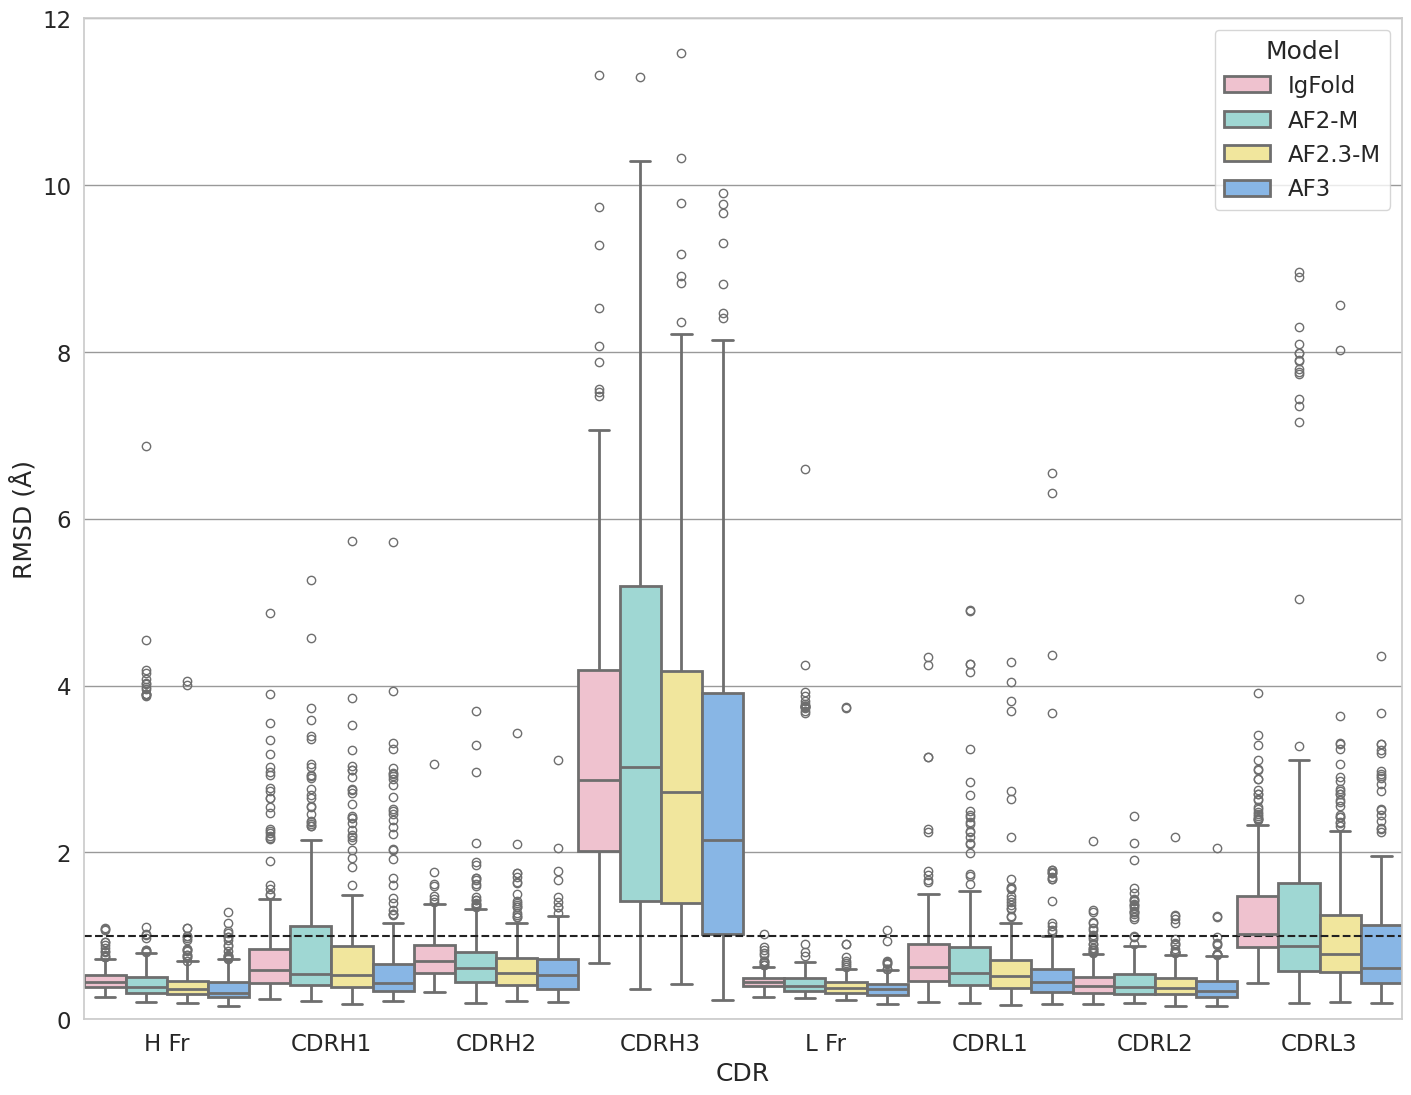

In [52]:
sns.set_style("whitegrid", {"grid.color": ".6"}) 
plt.figure(figsize = (17,13))
dataset_df = melted_ig_benchmark[(melted_ig_benchmark['Protein_type']=='antibody')&(melted_ig_benchmark['CDR']!='OCD')]
print(dataset_df.shape[0])
ax = sns.boxplot(data=dataset_df,\
                 x='CDR',y="RMSD (Å)",hue='Model',\
                 palette=pastel_palette,hue_order=['IgFold','AF2-M','AF2.3-M','AF3'],linewidth=linewidth,width=1.0)
sns.set(font_scale=2)
ax.set(ylim=(0, 12),ylabel='RMSD (Å)')
ax.axhline(y=1.0,ls='--',color='#222222')
plt.savefig(f"{filepath}allregions_Ab_top_ranked_unbound_igfold_benchmark.svg",format='svg',dpi=700,transparent=True,bbox_inches='tight')

/tmp/ipykernel_3821784/658077293.py:5: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.catplot(data=dataset_df,\


<Figure size 900x900 with 0 Axes>

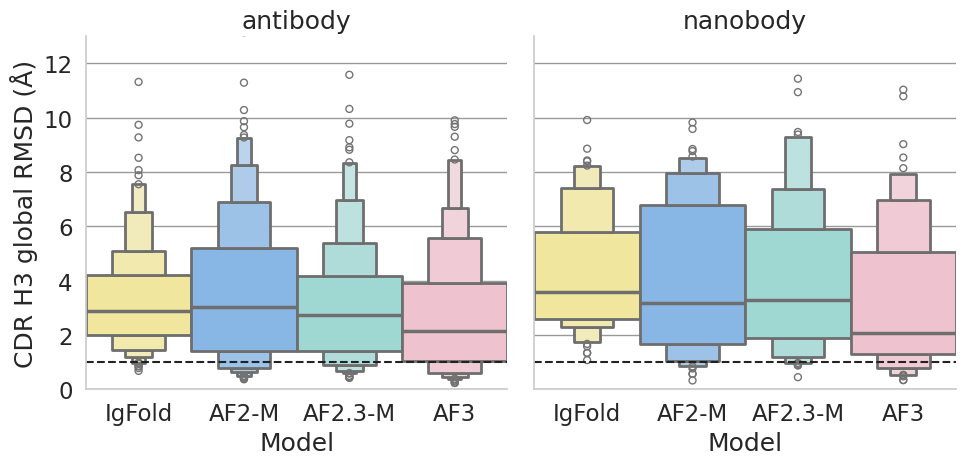

In [42]:
sns.set_style("whitegrid", {"grid.color": ".6"}) 
plt.figure(figsize = (9,9))
dataset_df = melted_ig_benchmark[(melted_ig_benchmark['CDR'].str.contains('H3'))]
ax = sns.catplot(data=dataset_df,\
                 x='Model',y="RMSD (Å)",hue='Model',\
                 palette=pastel_palette,col='Protein_type',order=['IgFold','AF2-M','AF2.3-M','AF3'],linewidth=linewidth,kind='boxen',width=1.0)
sns.set(font_scale=1.5)
ax.set(ylim=(0, 13),ylabel='CDR H3 global RMSD (Å)')
ax.set_titles(col_template="{col_name}")
ax.refline(y=1.0,ls='--',color='#222222')
plt.savefig(f"{filepath}top_ranked_unbound_igfold_benchmark.svg",format='svg',dpi=700,transparent=True,bbox_inches='tight')

In [32]:
#mannwhitney between models for ab
ptype1 = 'antibody'
ptype2 = 'nanobody'
cdr = 'CDRH3'
model1 = 'AF2.3-M'
model2 = 'AF3'

rmsds1 = igfold_benchmark[(igfold_benchmark['Model']==model1)&(igfold_benchmark['Protein_type']==ptype1)][cdr].tolist()
rmsds2 = igfold_benchmark[(igfold_benchmark['Model']==model2)&(igfold_benchmark['Protein_type']==ptype1)][cdr].tolist()
print(f"{ptype1} p-val: {mannwhitneyu(rmsds1,rmsds2)[1]}")
rmsds1 = igfold_benchmark[(igfold_benchmark['Model']==model1)&(igfold_benchmark['Protein_type']==ptype2)][cdr].tolist()
rmsds2 = igfold_benchmark[(igfold_benchmark['Model']==model2)&(igfold_benchmark['Protein_type']==ptype2)][cdr].tolist()
print(f"{ptype2} p-val: {mannwhitneyu(rmsds1,rmsds2)[1]}")

antibody p-val: 0.03557139708144339
nanobody p-val: 0.03318822606111728


## Panel 4: Ag context

Reasoning: Since AF3 produces such high quality complexes, how much does Ag context improve the H3 structure? Is this effect seen in AF2 as it is here?

### Abs

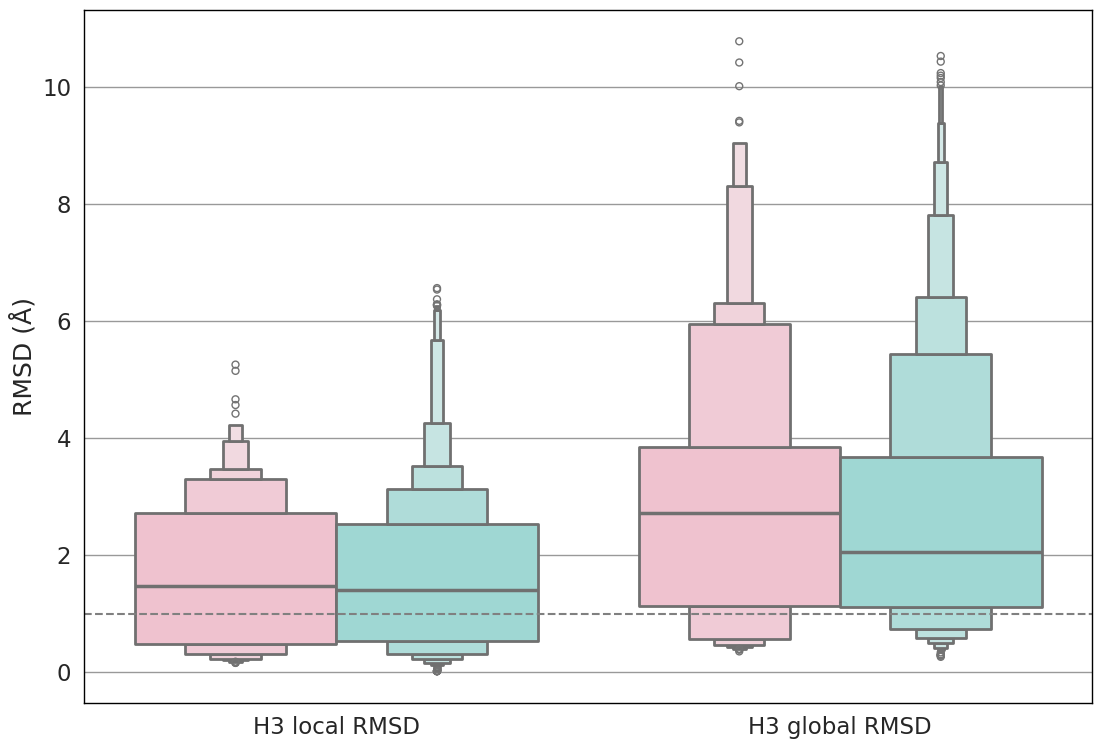

In [73]:
# Given antigen context
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="ticks", rc=custom_params,font_scale=1.5)
sns.set_style("whitegrid",{"grid.color":"0.6"})
plt.figure(figsize=(13,9))
# data_df=melted_AF2_v_AF3[(melted_AF2_v_AF3['Model_Source']=='AF3')\
                #  &(melted_AF2_v_AF3['Model']==0)&(melted_AF2_v_AF3['Protein_type']=='antibody') & ((melted_AF2_v_AF3['Fv_Region'].str.contains('H3'))|(melted_AF2_v_AF3['Fv_Region'].str.contains('h3')))].dropna(subset=['RMSD (Å)'])
data_df=melted_AF2_v_AF3[(melted_AF2_v_AF3['Model_Source']=='AF3')\
                 &(melted_AF2_v_AF3['Protein_type']=='antibody') & ((melted_AF2_v_AF3['Fv_Region'].str.contains('H3'))|(melted_AF2_v_AF3['Fv_Region'].str.contains('h3')))].dropna(subset=['RMSD (Å)'])
data_df = data_df[data_df['PDB_short'].isin(final_abs)]
data_df['RMSD (Å)']=data_df['RMSD (Å)'].astype('float')
data_df=data_df.replace({"Fv_Region":{"h3_rms":"H3 global RMSD"}})
data_df=data_df.replace({"Fv_Region":{"H3_local_RMSD":"H3 local RMSD"}})
g = sns.boxenplot(data=data_df[data_df['PDB_short'].isin(final_abs)].sort_values(by=['Bound_Unbound'],ascending=False),\
                 x='Fv_Region',y='RMSD (Å)',hue='Bound_Unbound',palette=pastel_palette[:2],linewidth=linewidth,legend=False)
g.ylim=((0,10))
# g.set(ylim=g.axes.get_ylim()[::-1])
g.axhline(y=1.0,ls='--',color='gray')
g.set(xlabel=None)
sns.set(font_scale=2)
for spine in g.spines.values():
    spine.set_linewidth(1)
    spine.set_color('black')
# g.fig.suptitle("Difference in Predictive Accuracy of Ab H3 loops between AF3 and AF2.3-M",y=1.05)
plt.savefig(f"{filepath}AF3_h3andloop_Abs.svg",format='svg',dpi=700,transparent=True,bbox_inches='tight')

In [36]:
data_df=melted_AF2_v_AF3[(melted_AF2_v_AF3['Model_Source']=='AF3')\
                 &(melted_AF2_v_AF3['Protein_type']=='nanobody') & ((melted_AF2_v_AF3['Fv_Region'].str.contains('H3'))|(melted_AF2_v_AF3['Fv_Region'].str.contains('h3')))].dropna(subset=['RMSD (Å)'])
unbound_rmsds = data_df[(data_df['Bound_Unbound']=='unbound')&(data_df['Fv_Region']=='h3_rms')]['RMSD (Å)']
bound_rmsds = data_df[(data_df['Bound_Unbound']=='bound')&(data_df['Fv_Region']=='h3_rms')]['RMSD (Å)']
print(mannwhitneyu(unbound_rmsds.tolist(),bound_rmsds.tolist()))
print(unbound_rmsds.describe()['50%'])
print(bound_rmsds.describe()['50%'])

MannwhitneyuResult(statistic=85419.0, pvalue=0.008400575113011578)
2.300032594410355
1.96666244538016


In [126]:
unbound_rmsds = data_df[(data_df['Bound_Unbound']=='unbound')&(data_df['Fv_Region']=='H3 global RMSD')]['RMSD (Å)']
bound_rmsds = data_df[(data_df['Bound_Unbound']=='bound')&(data_df['Fv_Region']=='H3 global RMSD')]['RMSD (Å)']
print(mannwhitneyu(unbound_rmsds.tolist(),bound_rmsds.tolist()))
print(unbound_rmsds.describe()['50%'])
print(bound_rmsds.describe()['50%'])

MannwhitneyuResult(statistic=11511.0, pvalue=0.29879617480394893)
2.90351018890183
2.026499700751246


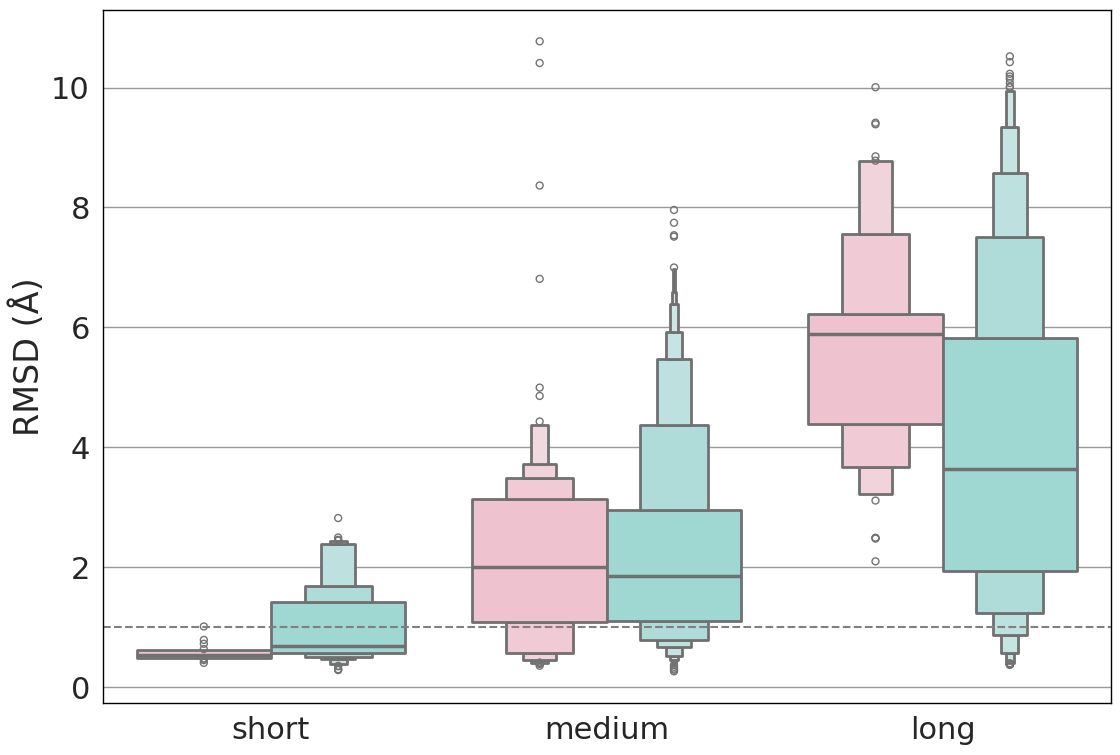

In [74]:
# Given antigen context
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="ticks", rc=custom_params,font_scale=1.5)
sns.set_style("whitegrid",{"grid.color":"0.6"})
plt.figure(figsize=(13,9))
# data_df=melted_AF2_v_AF3[(melted_AF2_v_AF3['Model']==0)&(melted_AF2_v_AF3['Model_Source']=='AF3')&(melted_AF2_v_AF3['Protein_type']=='antibody') & ((melted_AF2_v_AF3['Fv_Region'].str.contains('h3')))].dropna(subset=['RMSD (Å)'])
data_df=melted_AF2_v_AF3[(melted_AF2_v_AF3['Model_Source']=='AF3')&(melted_AF2_v_AF3['Protein_type']=='antibody') & ((melted_AF2_v_AF3['Fv_Region'].str.contains('h3')))].dropna(subset=['RMSD (Å)'])
data_df = data_df[data_df['PDB_short'].isin(final_abs)]
data_df['RMSD (Å)']=data_df['RMSD (Å)'].astype('float')
data_df=data_df.replace({"Fv_Region":{"h3_rms":"H3 global RMSD"}})
g = sns.boxenplot(data=data_df[data_df['PDB_short'].isin(final_abs)].sort_values(by=['Bound_Unbound'],ascending=False),\
                 x='h3_length',y='RMSD (Å)',order=['short','medium','long'],hue='Bound_Unbound',hue_order=['unbound','bound'],palette=pastel_palette[:2],linewidth=linewidth,legend=False)
g.ylim=((0,10))
# g.set(ylim=g.axes.get_ylim()[::-1])
g.axhline(y=1.0,ls='--',color='gray')
# g.refline(y=1.0,ls='--',color='gray')
g.set(xlabel=None)
sns.set(font_scale=2)
for spine in g.spines.values():
    spine.set_linewidth(1)
    spine.set_color('black')
# g.fig.suptitle("Difference in Predictive Accuracy of Ab H3 loops between AF3 and AF2.3-M",y=1.05)
plt.savefig(f"{filepath}AF3_h3bylength_Abs.svg",format='svg',dpi=700,transparent=True,bbox_inches='tight')

In [38]:
data_df=melted_AF2_v_AF3[(melted_AF2_v_AF3['Model_Source']=='AF3')&(melted_AF2_v_AF3['Protein_type']=='nanobody') & ((melted_AF2_v_AF3['Fv_Region'].str.contains('h3')))].dropna(subset=['RMSD (Å)'])
# data_df = data_df[data_df['PDB_short'].isin(final_abs)]
data_df['RMSD (Å)']=data_df['RMSD (Å)'].astype('float')
data_df=data_df.replace({"Fv_Region":{"h3_rms":"H3 global RMSD"}})
data_df=data_df.replace({"Fv_Region":{"H3_local_RMSD":"H3 local RMSD"}})
data_df

,Model_Source,Protein_type,Bound_Unbound,Seed,Model,PDB_short,h3_len,h3_length,Fv_Region,RMSD (Å)
15838,AF3,nanobody,unbound,1.0,3.0,7xl1_1.pdb,17,long,H3 global RMSD,11.925721
15839,AF3,nanobody,unbound,1.0,0.0,7xl1_1.pdb,17,long,H3 global RMSD,12.138373
15840,AF3,nanobody,unbound,1.0,2.0,7xl1_1.pdb,17,long,H3 global RMSD,12.315085
15841,AF3,nanobody,unbound,1.0,4.0,7xl1_1.pdb,17,long,H3 global RMSD,12.683690
15842,AF3,nanobody,unbound,1.0,1.0,7xl1_1.pdb,17,long,H3 global RMSD,12.225099
...,...,...,...,...,...,...,...,...,...,...
16988,AF3,nanobody,bound,3.0,3.0,7srk_1.pdb,10,medium,H3 global RMSD,0.442513
16989,AF3,nanobody,bound,3.0,1.0,7srk_1.pdb,10,medium,H3 global RMSD,0.485007
16990,AF3,nanobody,bound,3.0,0.0,7srk_1.pdb,10,medium,H3 global RMSD,0.436724
16991,AF3,nanobody,bound,3.0,4.0,7srk_1.pdb,10,medium,H3 global RMSD,0.466898


In [39]:
bound_rmsds = data_df[(data_df['Bound_Unbound']=='bound')&(data_df['Fv_Region']=='H3 global RMSD')]['RMSD (Å)']
unbound_rmsds = data_df[(data_df['Bound_Unbound']=='unbound')&(data_df['Fv_Region']=='H3 global RMSD')]['RMSD (Å)']
U1, p = mannwhitneyu(bound_rmsds.tolist(),unbound_rmsds.tolist())
# r, p = sp.stats.pearsonr(data_df['ipTM_HA'].tolist(),data_df['DockQ'].tolist())
print(f"Significance of AF3's Ab bound vs unbound: {p}")
print(f"U1: {U1}")
num_bound= len(bound_rmsds)
num_unbound= len(unbound_rmsds)
print(f"num bound: {num_bound}")
print(f"num unbound: {num_unbound}")
print(unbound_rmsds.describe()['50%']-bound_rmsds.describe()['50%'])
print(unbound_rmsds.describe()['50%'])
print(bound_rmsds.describe()['50%'])

Significance of AF3's Ab bound vs unbound: 0.008400575113011578
U1: 65331.0
num bound: 1005
num unbound: 150
0.333370149030195
2.300032594410355
1.96666244538016


In [156]:
bound_rmsds = data_df[(data_df['Bound_Unbound']=='bound')&(data_df['h3_length']=='long')&(data_df['Fv_Region']=='H3 global RMSD')]['RMSD (Å)']
unbound_rmsds = data_df[(data_df['Bound_Unbound']=='unbound')&(data_df['h3_length']=='long')&(data_df['Fv_Region']=='H3 global RMSD')]['RMSD (Å)']
U1, p = mannwhitneyu(bound_rmsds.tolist(),unbound_rmsds.tolist())
# r, p = sp.stats.pearsonr(data_df['ipTM_HA'].tolist(),data_df['DockQ'].tolist())
print(f"Significance of AF3's Ab bound vs unbound: {p}")
print(f"U1: {U1}")
num_bound= len(bound_rmsds)
num_unbound= len(unbound_rmsds)
print(f"num bound: {num_bound}")
print(f"num unbound: {num_unbound}")
print(unbound_rmsds.describe()['50%']-bound_rmsds.describe()['50%'])
print(unbound_rmsds.describe()['50%'])
print(bound_rmsds.describe()['50%'])

Significance of AF3's Ab bound vs unbound: 4.120006624124209e-08
U1: 11271.0
num bound: 495
num unbound: 75
2.247547670155915
5.891569446475155
3.64402177631924


/tmp/ipykernel_3821784/3226740941.py:7: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.boxenplot(data=data_df,x='Fv_Region',y='RMSD (Å)',order=['H3 local RMSD','H3 global RMSD'],hue='Bound_Unbound',palette=pastel_palette,linewidth=linewidth,legend=False)


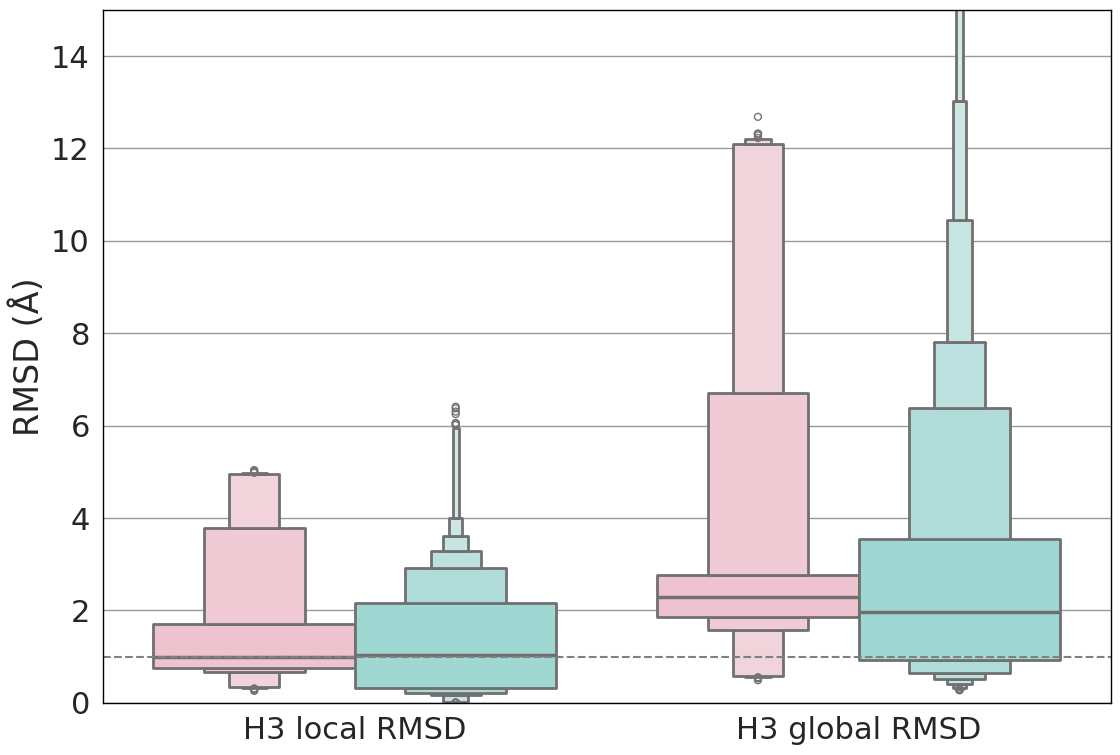

In [75]:
sns.set_style("whitegrid",{"grid.color":"0.6"})
plt.figure(figsize=(13,9))
# data_df=melted_AF2_v_AF3[(melted_AF2_v_AF3['Model']==0)&(melted_AF2_v_AF3['Model_Source']=='AF3')&(melted_AF2_v_AF3['Protein_type']=='nanobody') & ((melted_AF2_v_AF3['Fv_Region'].str.contains('h3')|(melted_AF2_v_AF3['Fv_Region'].str.contains('H3'))))].dropna(subset=['RMSD (Å)'])
data_df=melted_AF2_v_AF3[(melted_AF2_v_AF3['Model_Source']=='AF3')&(melted_AF2_v_AF3['Protein_type']=='nanobody') & ((melted_AF2_v_AF3['Fv_Region'].str.contains('h3')|(melted_AF2_v_AF3['Fv_Region'].str.contains('H3'))))].dropna(subset=['RMSD (Å)'])
data_df=data_df.replace({"Fv_Region":{"h3_rms":"H3 global RMSD"}})
data_df=data_df.replace({"Fv_Region":{"H3_local_RMSD":"H3 local RMSD"}})
g = sns.boxenplot(data=data_df,x='Fv_Region',y='RMSD (Å)',order=['H3 local RMSD','H3 global RMSD'],hue='Bound_Unbound',palette=pastel_palette,linewidth=linewidth,legend=False)
g.axhline(y=1.0,ls='--',color='gray')
g.set(xlabel=None,ylim=(0,15))
sns.set(font_scale=2)
for spine in g.spines.values():
    spine.set_linewidth(1)
    spine.set_color('black')
plt.savefig(f"{filepath}AF3_agcontext_Nbs.svg",format='svg',dpi=700,transparent=True,bbox_inches='tight')

In [219]:
bound_ones = melted_AF2_v_AF3[(melted_AF2_v_AF3['Protein_type']=='nanobody')&(melted_AF2_v_AF3['Model_Source']=='AF3')&(melted_AF2_v_AF3['Fv_Region']=='h3_rms') & (melted_AF2_v_AF3['Bound_Unbound']=='bound')&(melted_AF2_v_AF3['RMSD (Å)']==melted_AF2_v_AF3['RMSD (Å)'])]['RMSD (Å)'].tolist()
unbound_ones = melted_AF2_v_AF3[(melted_AF2_v_AF3['Protein_type']=='nanobody')&(melted_AF2_v_AF3['Model_Source']=='AF3')&(melted_AF2_v_AF3['Fv_Region']=='h3_rms') & (melted_AF2_v_AF3['Bound_Unbound']=='unbound')&(melted_AF2_v_AF3['RMSD (Å)']==melted_AF2_v_AF3['RMSD (Å)'])]['RMSD (Å)'].tolist()
U1, p = mannwhitneyu(bound_ones,unbound_ones)
print(f'num bound: {len(bound_ones)}')
print(f'num unbound: {len(unbound_ones)}')
print(f"Significance of AF3's h3_rms bound vs unbound for Nbs: {p}")

num bound: 1005
num unbound: 150
Significance of AF3's h3_rms bound vs unbound for Nbs: 0.008400575113011578


## Panel 5: Scoring Optimization

In [23]:
# binding_es = pd.read_csv("results/round_6/datafiles/renum_fv_all_bindingenergies.csv").drop(columns=['Unnamed: 0']).drop_duplicates(subset=['PDB'])
# # binding_es['PDB_short']= ["_".join(x.split("_")[-5:-3])+'.pdb' for x in binding_es.PDB.tolist()]
# # binding_es['Seed']= [int(x.split("_")[-3].split('d')[-1]) if 'bound' not in x else int(x.split("_")[-4].split('d')[-1]) for x in binding_es.PDB.tolist()]
# # binding_es['Model']= [int(x.split("_")[-1].split(".")[0]) for x in binding_es.PDB.tolist()]
# binding_es
fulldelgb_df = pd.read_csv("results/round_6/datafiles/top_ranked_renum_fv_all_bindingenergies.csv").drop(columns=['Unnamed: 0'])
# fulldelgb_df = pd.read_csv("results/round_6/datafiles/renum_fv_all_bindingenergies.csv").drop(columns=['Unnamed: 0'])
fulldelgb_df['Bound_Unbound'] = ['bound']*fulldelgb_df.shape[0]
fulldelgb_df['PDB_short']= ["_".join(x.split("_")[-5:-3])+'.pdb' if 'bound' not in x else "_".join(x.split("_")[-6:-4])+'.pdb' for x in fulldelgb_df.PDB.tolist()]
fulldelgb_df['Seed']= [int(x.split("_")[-3].split('d')[-1]) if 'bound' not in x else int(x.split("_")[-4].split('d')[-1]) for x in fulldelgb_df.PDB.tolist()]
fulldelgb_df['Model']= [int(x.split("_")[-1].split(".")[0]) for x in fulldelgb_df.PDB.tolist()]
fulldelgb_df

,PDB,del_G_B,Protein_type,Bound_Unbound,PDB_short,Seed,Model
0,renum_fv_fold_7wog_0_seed1_model_3.pdb,18.744175,antibody,bound,7wog_0.pdb,1,3
1,renum_fv_fold_7wg3_1_seed1_model_0.pdb,57.675197,antibody,bound,7wg3_1.pdb,1,0
2,renum_fv_fold_8ath_1_seed1_model_0.pdb,6.112339,antibody,bound,8ath_1.pdb,1,0
3,renum_fv_fold_8hp9_0_seed1_model_2.pdb,-78.321379,antibody,bound,8hp9_0.pdb,1,2
4,renum_fv_fold_8sgn_0_seed1_model_0.pdb,40.704204,antibody,bound,8sgn_0.pdb,1,0
...,...,...,...,...,...,...,...
183,renum_renamed_fold_7tpr_1_seed1_model_0.pdb,45.367333,nanobody,bound,7tpr_1.pdb,1,0
184,renum_renamed_fold_8emz_0_seed1_model_0.pdb,106.173977,nanobody,bound,8emz_0.pdb,1,0
185,renum_renamed_fold_7q6c_0_seed1_bound_model_0.pdb,35.049829,nanobody,bound,7q6c_0.pdb,1,0
186,renum_renamed_fold_8cxq_0_seed1_model_0.pdb,-36.906251,nanobody,bound,8cxq_0.pdb,1,0


In [24]:
relaxed_delgb_df = pd.read_csv("results/round_6/datafiles/topranked_renum_fv_all_RELAXEDbindingenergies.csv").drop(columns=['Unnamed: 0'])
relaxed_delgb_df['Bound_Unbound'] = ['bound']*relaxed_delgb_df.shape[0]
relaxed_delgb_df['PDB_short']= ["_".join(x.split("_")[-5:-3])+'.pdb'\
    if '7q6c_0' not in x else "_".join(x.split("_")[-6:-4])+'.pdb'\
          for x in relaxed_delgb_df.Pred_PDB.tolist()]
relaxed_delgb_df['Seed']= [int(x.split("_")[-3].split('d')[-1]) if 'bound' not in x else int(x.split("_")[-4].split('d')[-1]) for x in relaxed_delgb_df.Pred_PDB.tolist()]
relaxed_delgb_df['Model']= [int(x.split("_")[-1].split(".")[0]) for x in relaxed_delgb_df.Pred_PDB.tolist()]
relaxed_delgb_df = relaxed_delgb_df.rename(columns={"Pred_PDB":"Relaxed_PDB","Pred_Dir":"Relaxed_Dir"})
# relaxed_delgb_df.to_csv("results/round_6/datafiles/polished_renum_fv_all_RELAXEDbindingenergies.csv")
relaxed_delgb_df

,Relaxed_Dir,Relaxed_PDB,del_G_B,Protein_type,Bound_Unbound,PDB_short,Seed,Model
0,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,overall_renum_fv_fold_7wog_0_seed1_model_3.pdb,-71.713244,antibody,bound,7wog_0.pdb,1,3
1,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,overall_renum_fv_fold_7wg3_1_seed1_model_0.pdb,-58.685492,antibody,bound,7wg3_1.pdb,1,0
2,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,overall_renum_fv_fold_8ath_1_seed1_model_0.pdb,-77.933328,antibody,bound,8ath_1.pdb,1,0
3,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,overall_renum_fv_fold_8hp9_0_seed1_model_2.pdb,-85.054073,antibody,bound,8hp9_0.pdb,1,2
4,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,overall_renum_fv_fold_8sgn_0_seed1_model_0.pdb,-94.556164,antibody,bound,8sgn_0.pdb,1,0
...,...,...,...,...,...,...,...,...
183,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,overall_renum_renamed_fold_7tpr_1_seed1_model_...,-26.176384,nanobody,bound,7tpr_1.pdb,1,0
184,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,overall_renum_renamed_fold_8emz_0_seed1_model_...,-24.334845,nanobody,bound,8emz_0.pdb,1,0
185,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,overall_renum_renamed_fold_7q6c_0_seed1_bound_...,-29.346845,nanobody,bound,7q6c_0.pdb,1,0
186,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,overall_renum_renamed_fold_8cxq_0_seed1_model_...,-64.743206,nanobody,bound,8cxq_0.pdb,1,0


In [26]:
be_withothermetrics = final_af3_benchmark.merge(fulldelgb_df,on=['PDB_short','Seed','Model','Protein_type','Bound_Unbound'])
be_withothermetrics

,AF3_Dir,AF3_PDB,Bound_Unbound,Native_Dir,Native_PDB,H3_local_RMSD,ocd,frh_rms,h1_rms,h2_rms,...,iRMS,LRMS,ipTM_HA,ipTM_LA,I_pLDDT,DockQ_Classification,h3_len,h3_length,PDB,del_G_B
0,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_8sgn_0_seed1_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_8sgn_0.pdb,0.452939,2.997131,0.281419,1.004531,1.380401,...,2.282587,9.529049,0.26,0.85,73.034535,Acceptable,13,medium,renum_fv_fold_8sgn_0_seed1_model_0.pdb,40.704204
1,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_8cz5_0_seed1_model_1.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_8cz5_0.pdb,1.350175,2.115326,0.279931,0.244049,0.614460,...,11.002850,30.880808,0.18,0.91,77.205641,Incorrect,15,medium,renum_fv_fold_8cz5_0_seed1_model_1.pdb,87.915029
2,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_8c3v_1_seed1_model_1.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_8c3v_1.pdb,1.258274,2.734840,0.245242,0.303706,0.383155,...,0.681465,3.453563,0.78,0.86,93.143667,High,17,long,renum_fv_fold_8c3v_1_seed1_model_1.pdb,-66.630617
3,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_8g2m_0_seed1_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_8g2m_0.pdb,0.154128,1.865152,0.352407,0.236211,0.966382,...,2.643704,6.544861,0.71,0.02,86.797917,Acceptable,12,medium,renum_fv_fold_8g2m_0_seed1_model_0.pdb,-41.868087
4,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_7wcp_0_seed1_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_7wcp_0.pdb,0.530290,8.488689,0.956950,0.853411,1.250742,...,46.571449,134.665299,0.17,0.69,81.821507,Incorrect,11,medium,renum_fv_fold_7wcp_0_seed1_model_0.pdb,44.458919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_8emz_0_seed1_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_8emz_0.pdb,2.978257,0.000000,0.337500,1.902148,0.405577,...,NaN,NaN,0.13,NaN,68.597241,Incorrect,21,long,renum_renamed_fold_8emz_0_seed1_model_0.pdb,106.173977
184,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_7q6c_0_seed1_bound_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7q6c_0.pdb,0.897443,0.000000,0.525125,0.417970,0.442514,...,11.844630,47.824423,0.16,NaN,76.839487,Incorrect,11,medium,renum_renamed_fold_7q6c_0_seed1_bound_model_0.pdb,35.049829
185,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_7tpr_0_seed1_model_2.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7tpr_0.pdb,2.061164,0.000000,0.584365,2.900495,1.625220,...,NaN,NaN,0.20,NaN,67.967164,Incorrect,15,medium,renum_renamed_fold_7tpr_0_seed1_model_2.pdb,54.643010
186,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_7zmm_0_seed1_model_1.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7zmm_0.pdb,0.273251,0.000000,0.488461,0.489970,0.583585,...,NaN,NaN,0.68,NaN,90.360385,High,19,long,renum_renamed_fold_7zmm_0_seed1_model_1.pdb,-26.708163


In [27]:
relaxbe_withothermetrics = final_af3_benchmark.merge(relaxed_delgb_df.rename(columns={"Pred_PDB":"Relaxed_PDB","Pred_Dir":"Relaxed_Dir"}),on=['PDB_short','Seed','Model','Protein_type','Bound_Unbound'])
relaxbe_withothermetrics

,AF3_Dir,AF3_PDB,Bound_Unbound,Native_Dir,Native_PDB,H3_local_RMSD,ocd,frh_rms,h1_rms,h2_rms,...,LRMS,ipTM_HA,ipTM_LA,I_pLDDT,DockQ_Classification,h3_len,h3_length,Relaxed_Dir,Relaxed_PDB,del_G_B
0,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_8sgn_0_seed1_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_8sgn_0.pdb,0.452939,2.997131,0.281419,1.004531,1.380401,...,9.529049,0.26,0.85,73.034535,Acceptable,13,medium,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,overall_renum_fv_fold_8sgn_0_seed1_model_0.pdb,-94.556164
1,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_8cz5_0_seed1_model_1.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_8cz5_0.pdb,1.350175,2.115326,0.279931,0.244049,0.614460,...,30.880808,0.18,0.91,77.205641,Incorrect,15,medium,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,overall_renum_fv_fold_8cz5_0_seed1_model_1.pdb,-73.709607
2,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_8c3v_1_seed1_model_1.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_8c3v_1.pdb,1.258274,2.734840,0.245242,0.303706,0.383155,...,3.453563,0.78,0.86,93.143667,High,17,long,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,overall_renum_fv_fold_8c3v_1_seed1_model_1.pdb,-91.809764
3,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_8g2m_0_seed1_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_8g2m_0.pdb,0.154128,1.865152,0.352407,0.236211,0.966382,...,6.544861,0.71,0.02,86.797917,Acceptable,12,medium,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,overall_renum_fv_fold_8g2m_0_seed1_model_0.pdb,-75.012093
4,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,renum_fv_fold_7wcp_0_seed1_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_fv_7wcp_0.pdb,0.530290,8.488689,0.956950,0.853411,1.250742,...,134.665299,0.17,0.69,81.821507,Incorrect,11,medium,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/so...,overall_renum_fv_fold_7wcp_0_seed1_model_0.pdb,-67.155610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_8emz_0_seed1_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_8emz_0.pdb,2.978257,0.000000,0.337500,1.902148,0.405577,...,NaN,0.13,NaN,68.597241,Incorrect,21,long,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,overall_renum_renamed_fold_8emz_0_seed1_model_...,-24.334845
183,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_7q6c_0_seed1_bound_model_0.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7q6c_0.pdb,0.897443,0.000000,0.525125,0.417970,0.442514,...,47.824423,0.16,NaN,76.839487,Incorrect,11,medium,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,overall_renum_renamed_fold_7q6c_0_seed1_bound_...,-29.346845
184,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_7tpr_0_seed1_model_2.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7tpr_0.pdb,2.061164,0.000000,0.584365,2.900495,1.625220,...,NaN,0.20,NaN,67.967164,Incorrect,15,medium,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,overall_renum_renamed_fold_7tpr_0_seed1_model_...,-26.655366
185,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,renum_renamed_fold_7zmm_0_seed1_model_1.pdb,bound,/scratch4/jgray21/ftalib1/AF3_Benchmark/New_AF...,renum_7zmm_0.pdb,0.273251,0.000000,0.488461,0.489970,0.583585,...,NaN,0.68,NaN,90.360385,High,19,long,/scratch4/jgray21/ftalib1/AF3_Benchmark/AF3/ex...,overall_renum_renamed_fold_7zmm_0_seed1_model_...,-53.051841


In [86]:
# single metric px functions (CUMULATIVE)

def p_dockq_iptm_cumul(df,protein,dockq,iptm):
    p_joint = (df[(df['DockQ']>dockq)&(df['ipTM_HA']<=iptm)&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    p_denom = (df[(df['ipTM_HA']<=iptm)&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    p_conditional = p_joint/p_denom
    return p_conditional

def p_dockq_iplddt_cumul(df,protein,dockq,iplddt):
    p_joint = df[(df['DockQ']>dockq)&(df['I_pLDDT']<=iplddt)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['I_pLDDT']<=iplddt)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_conditional = p_joint/p_denom
    return p_conditional

def p_dockq_bE_cumul(df,protein,dockq,bE):
    p_joint = df[(df['DockQ']>dockq)&(df['del_G_B']>bE)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['del_G_B']>bE)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_conditional = p_joint/p_denom
    return p_conditional


def p_dockq_h3plddt_cumul(df,protein,dockq,h3_plddt):
    p_joint = df[(df['DockQ']>dockq)&(df['Avg_H3_pLDDT']<=h3_plddt)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['Avg_H3_pLDDT']<=h3_plddt)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_conditional = p_joint/p_denom
    return p_conditional


def p_dockq_l3plddt_cumul(df,protein,dockq,l3_plddt):
    p_joint = df[(df['DockQ']>dockq)&(df['Avg_L3_pLDDT']<=l3_plddt)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['Avg_L3_pLDDT']<=l3_plddt)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_conditional = p_joint/p_denom
    return p_conditional

def p_dock_all_cumul(df,protein,dockq,iptm,bE,h3_plddt,l3_plddt):
    p_joint = df[(df['DockQ']>dockq)&(df['ipTM_HA']<=iptm)&(df['del_G_B']>bE)&(df['Avg_H3_pLDDT']<=h3_plddt)&(df['Avg_L3_pLDDT']<=l3_plddt)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['ipTM_HA']<=iptm)&(df['del_G_B']>bE)&(df['Avg_H3_pLDDT']<=h3_plddt)&(df['Avg_L3_pLDDT']<=l3_plddt)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_conditional = p_joint/p_denom
    return p_conditional


# Functions for full joint conditionals
def p_dockqx_cumul(df,protein,dockq,iptm,bE,h3_plddt):
    p_joint = df[(df['DockQ']>dockq)&(df['ipTM_HA']<=iptm)&(df['Avg_H3_pLDDT']<=h3_plddt)&(df['del_G_B']>bE)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['ipTM_HA']<=iptm)&(df['del_G_B']>bE)&(df['Avg_H3_pLDDT']<=h3_plddt)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_conditional = p_joint/p_denom
    return p_conditional

def p_h3x_cumul(df,protein,h3_rms,iptm,bE):
    p_joint = df[(df['h3_rms']<=h3_rms)&(df['ipTM_HA']<=iptm)&(df['del_G_B']>bE)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['ipTM_HA']<=iptm)&(df['del_G_B']>bE)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_conditional = p_joint/p_denom
    return p_conditional


    


In [109]:
# single metric px functions (CUMULATIVE)

def p_inc_iptm(df,protein,null_val,iptm):
    p_joint = (df[(df['DockQ']<=0.23)&(df['ipTM_HA']>iptm[0])&(df['ipTM_HA']<=iptm[1])&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    p_denom = (df[(df['ipTM_HA']>iptm[0])&(df['ipTM_HA']<=iptm[1])&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional = 0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional
def p_inc_iplddt(df,protein,null_val,iplddt):
    p_joint = (df[(df['DockQ']<=0.23)&(df['I_pLDDT']>iplddt[0])&(df['I_pLDDT']<=iplddt[1])&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    p_denom = (df[(df['I_pLDDT']>iplddt[0])&(df['I_pLDDT']<=iplddt[1])&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional = 0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional

def p_inc_bE(df,protein,null_val,bE):
    p_joint = (df[(df['DockQ']<=0.23)&(df['del_G_B']<=bE[1])&(df['del_G_B']>bE[0])&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    p_denom = (df[(df['del_G_B']<=bE[1])&(df['del_G_B']>bE[0])&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional = 0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional

def p_inc_h3plddt(df,protein,null_val,h3_plddt):
    p_joint = (df[(df['DockQ']<=0.23)&(df['Avg_H3_pLDDT']>h3_plddt[0])&(df['Avg_H3_pLDDT']<=h3_plddt[1])&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    p_denom = (df[(df['Avg_H3_pLDDT']>h3_plddt[0])&(df['Avg_H3_pLDDT']<=h3_plddt[1])&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional = 0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional

def p_dockq_iptm(df,protein,dockq,iptm):
    p_joint = (df[(df['DockQ']>dockq)&(df['ipTM_HA']>iptm[0])&(df['ipTM_HA']<=iptm[1])&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    p_denom = (df[(df['ipTM_HA']>iptm[0])&(df['ipTM_HA']<=iptm[1])&(df['Protein_type']==protein)].shape[0])/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional = 0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional

def p_dockq_iplddt(df,protein,dockq,iplddt):
    p_joint = df[(df['DockQ']>dockq)&(df['I_pLDDT']>iplddt[0])&(df['I_pLDDT']<=iplddt[1])&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['I_pLDDT']>iplddt[0])&(df['I_pLDDT']<=iplddt[1])&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional =0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional

def p_dockq_bE(df,protein,dockq,bE):
    p_joint = df[(df['DockQ']>dockq)&(df['del_G_B']<=bE[1])&(df['del_G_B']>bE[0])&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['del_G_B']<=bE[1])&(df['del_G_B']>bE[0])&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional =0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional


def p_dockq_h3plddt(df,protein,dockq,h3_plddt):
    p_joint = df[(df['DockQ']>dockq)&(df['Avg_H3_pLDDT']>h3_plddt[0])&(df['Avg_H3_pLDDT']<=h3_plddt[1])&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['Avg_H3_pLDDT']>h3_plddt[0])&(df['Avg_H3_pLDDT']<=h3_plddt[1])&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional =0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional


def p_dockq_l3plddt(df,protein,dockq,l3_plddt):
    p_joint = df[(df['DockQ']>dockq)&(df['Avg_L3_pLDDT']>l3_plddt[0])&(df['Avg_L3_pLDDT']<=l3_plddt[1])&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['Avg_L3_pLDDT']>l3_plddt[0])&(df['Avg_L3_pLDDT']<=l3_plddt[1])&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional =0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional

def p_dock_all(df,protein,dockq,iptm,bE,h3_plddt,l3_plddt):
    p_joint = df[(df['DockQ']>dockq)&\
                 (df['ipTM_HA']>iptm[0])&(df['ipTM_HA']<=iptm[1])\
                    &(df['del_G_B']<=bE[1])&(df['del_G_B']>bE[0])\
                        &(df['Avg_H3_pLDDT']>h3_plddt[0])&(df['Avg_H3_pLDDT']<=h3_plddt[1])\
                            &(df['Avg_L3_pLDDT']>l3_plddt[0])&(df['Avg_L3_pLDDT']<=l3_plddt[1])\
                                &(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['ipTM_HA']>iptm[0])&(df['ipTM_HA']<=iptm[1])\
                    &(df['del_G_B']<=bE[1])&(df['del_G_B']>bE[0])\
                        &(df['Avg_H3_pLDDT']>h3_plddt[0])&(df['Avg_H3_pLDDT']<=h3_plddt[1])\
                            &(df['Avg_L3_pLDDT']>l3_plddt[0])&(df['Avg_L3_pLDDT']<=l3_plddt[1])\
                            &(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional =0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional


# Functions for full joint conditionals
def p_dockqx(df,protein,dockq,iptm,bE,h3_plddt):
    p_joint = df[(df['DockQ']>dockq)&\
                 (df['ipTM_HA']>iptm[0])&(df['ipTM_HA']<=iptm[1])&\
                     (df['Avg_H3_pLDDT']>h3_plddt[0])&(df['Avg_H3_pLDDT']<=h3_plddt[1])&\
                        (df['del_G_B']<=bE[1])&(df['del_G_B']>bE[0])\
                            &(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['ipTM_HA']>iptm[0])&(df['ipTM_HA']<=iptm[1])&\
                     (df['Avg_H3_pLDDT']>h3_plddt[0])&(df['Avg_H3_pLDDT']<=h3_plddt[1])&\
                        (df['del_G_B']<=bE[1])&(df['del_G_B']>bE[0])\
                        &(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional =0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional

def p_h3x(df,protein,h3_rms,iptm,bE):
    p_joint = df[(df['h3_rms']<=h3_rms)&(df['ipTM_HA']<=iptm)&(df['del_G_B']>bE)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    p_denom = df[(df['ipTM_HA']<=iptm)&(df['del_G_B']>bE)&(df['Protein_type']==protein)].shape[0]/df[(df['Protein_type']==protein)].shape[0]
    if (p_denom == 0):
        p_conditional =0
    else:
        p_conditional = p_joint/p_denom
    return p_conditional

In [28]:
def p_x_wrapper(p_func,df,protein,y_var_ranges,x_var_ranges):
    p_xs = []
    ind_vars = []
    dep_vars = []
    for i in y_var_ranges:
        for j in x_var_ranges:
            p_xs.append(p_func(df,protein,i,j))
            dep_vars.append(i)
            ind_vars.append(j)
    return ind_vars,dep_vars,p_xs

def p_x_joint_wrapper(p_func,df,protein,y_var_ranges,x1_var_ranges,x2_var_ranges,x3_var_ranges):
    p_xs = []
    ind1_vars = []
    ind2_vars = []
    ind3_vars = []
    dep_vars = []
    for i in y_var_ranges:
        for j in x1_var_ranges:
            for k in x2_var_ranges:
                for l in x3_var_ranges:
                    p_xs.append(p_func(df,protein,i,j,k,l))
                    dep_vars.append(i)
                    ind1_vars.append(j)
                    ind2_vars.append(k)
                    ind3_vars.append(l)
    return ind1_vars,ind2_vars,ind3_vars,dep_vars,p_xs
    


### N cases + metric ranges

In [102]:
def n_cases(df,metric,metric_range,protein):
    correct_cases = df[(df['DockQ']>=0.23)&(df[metric]>=metric_range[0])&(df[metric]<metric_range[1])&(df['Protein_type']==protein)].shape[0]
    incorrect_cases = df[(df['DockQ']<0.23)&(df[metric]>=metric_range[0])&(df[metric]<metric_range[1])&(df['Protein_type']==protein)].shape[0]
    return correct_cases, incorrect_cases

def n_cases_wrapper(df,metric,metric_ranges,n_cases,protein):
    all_metric_ranges_correct = []
    all_metric_ranges_incorrect = []
    for i in metric_ranges:
        correct_cases, incorrect_cases = n_cases(df,metric,i,protein)
        all_metric_ranges_correct.append(correct_cases)
        all_metric_ranges_incorrect.append(incorrect_cases)
    return all_metric_ranges_correct, all_metric_ranges_incorrect
    

0


/tmp/ipykernel_654915/441917158.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Ab-Ag complexes',hue='Success',\


1


/tmp/ipykernel_654915/441917158.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Ab-Ag complexes',hue='Success',\


2


/tmp/ipykernel_654915/441917158.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Ab-Ag complexes',hue='Success',\


3


/tmp/ipykernel_654915/441917158.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Ab-Ag complexes',hue='Success',\
/tmp/ipykernel_654915/441917158.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(['[0.1, \n0.2]','[0.2, \n0.3]','[0.3, \n0.4]',\
/tmp/ipykernel_654915/441917158.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(['[-100, \n-80]','[-80, \n-60]','[-60, \n-40]',\


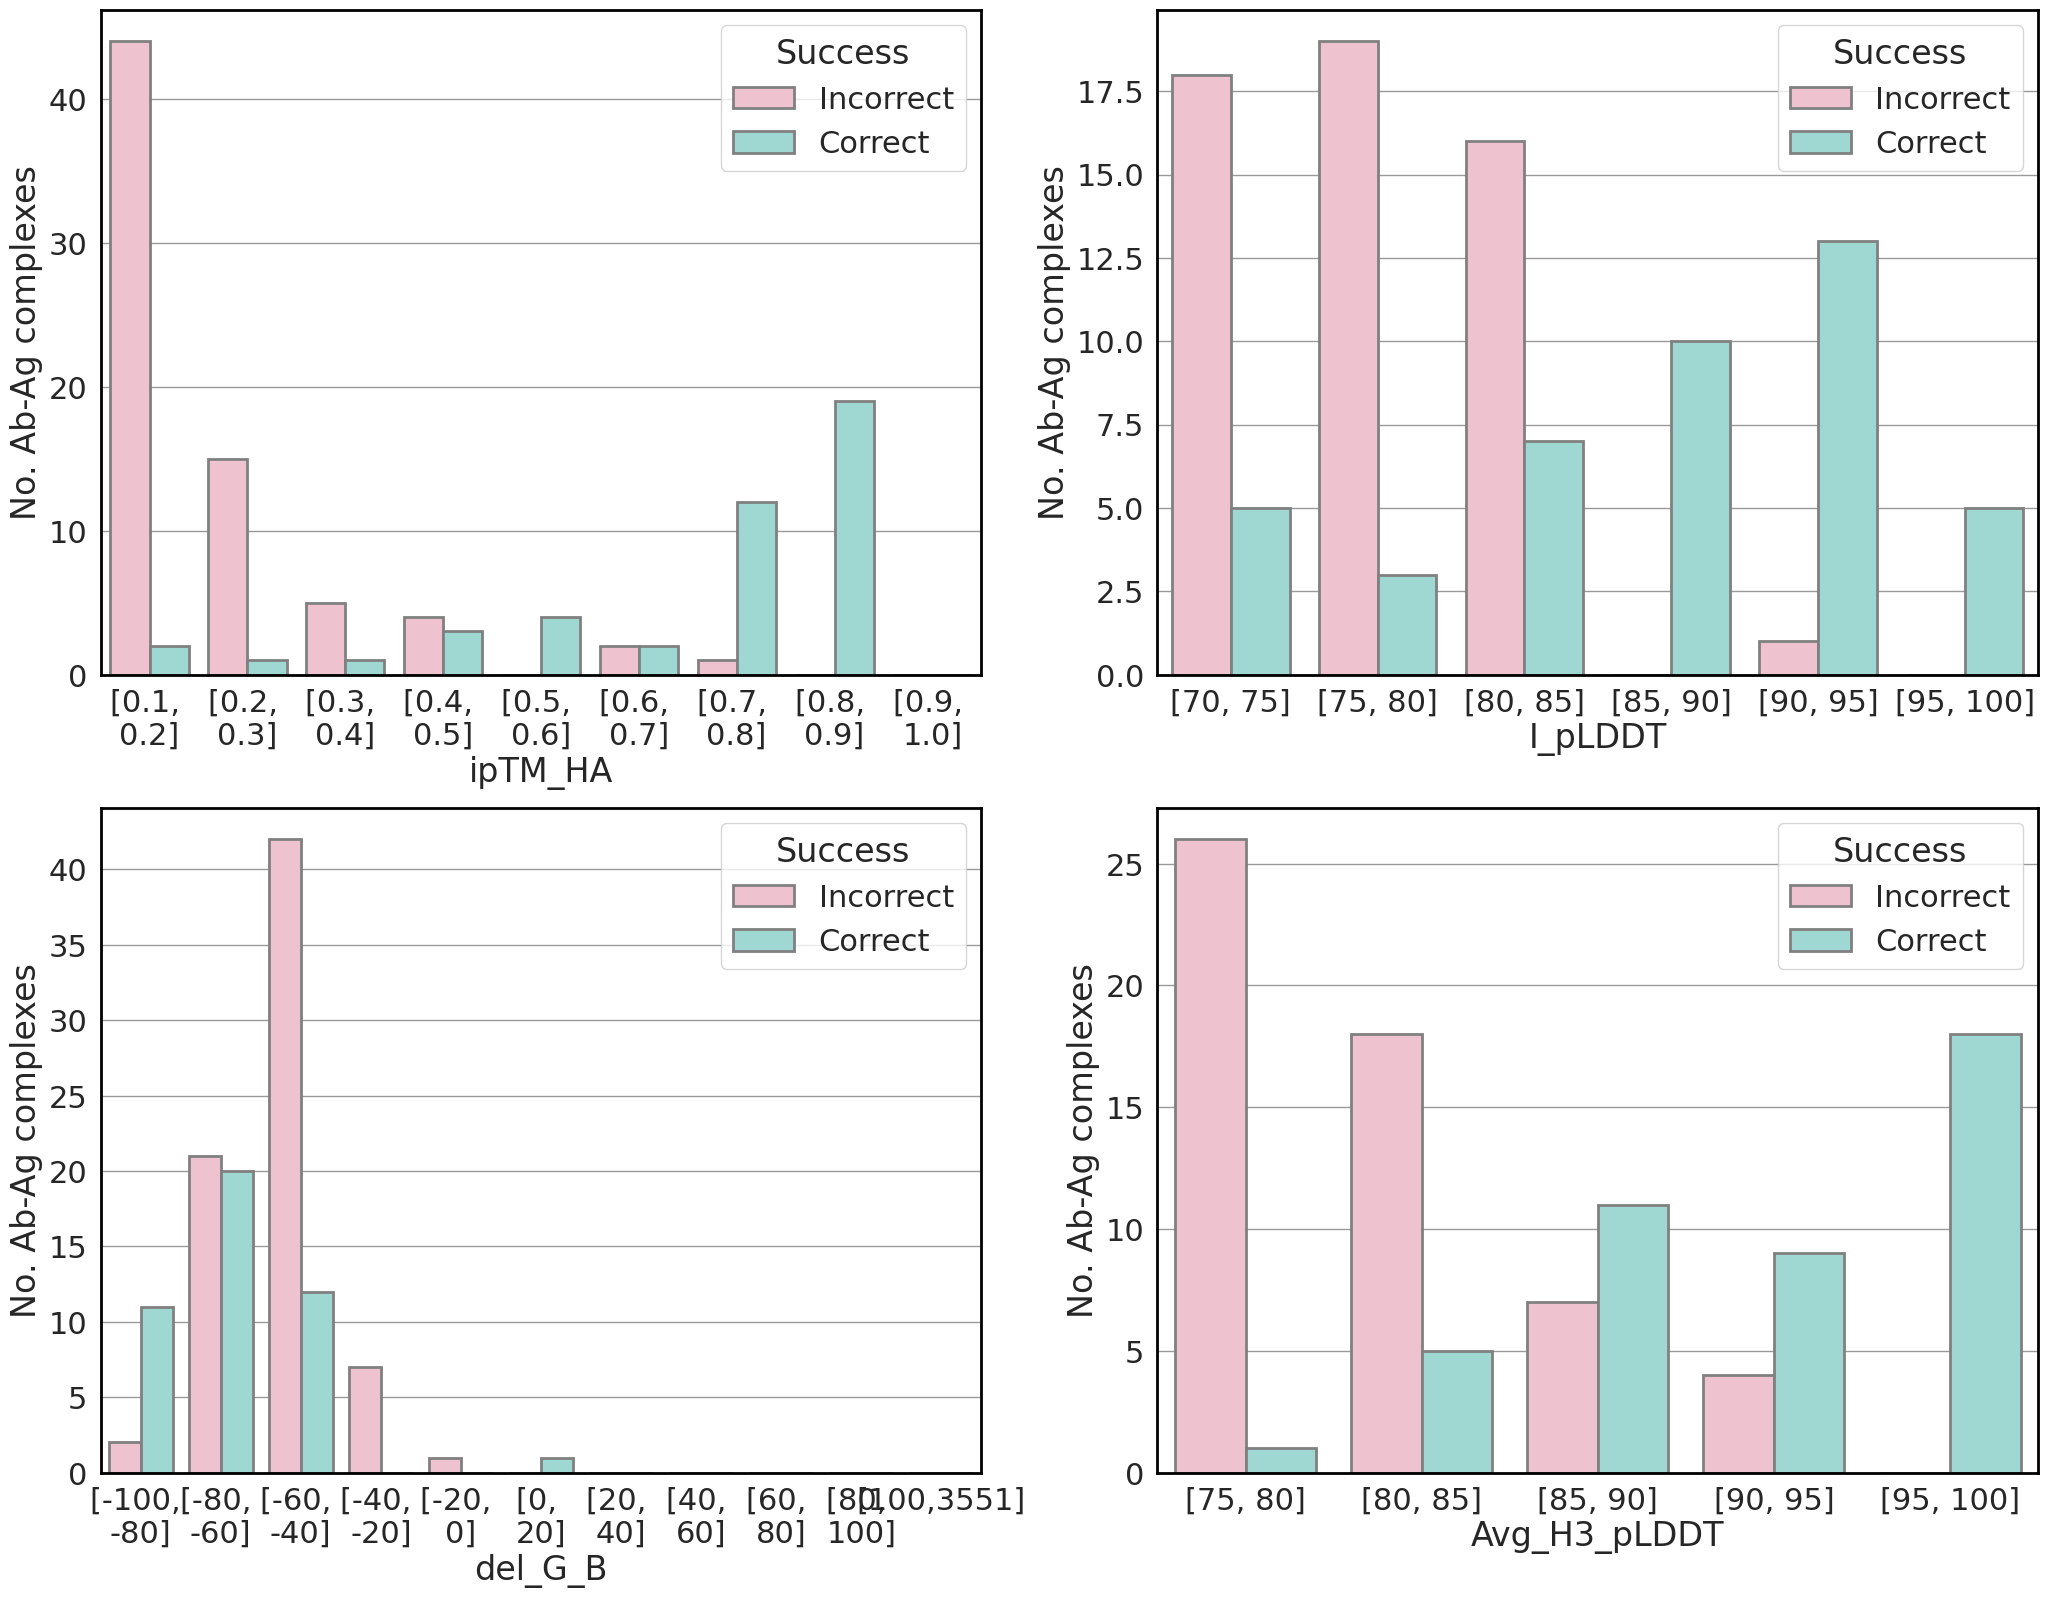

In [130]:

iptm_range = [list(np.array(list(range(i,i+2)))/10) for i in list(range(1,10))]
# iplddt_range = list(np.array(range(70,105,5)))
iplddt_range = [list(range(i,i+6,5)) for i in list(range(70,100,5))]
# be_range_nbs = sorted(list(np.array(range(-100,100,20))),reverse=True)
# be_range_abs = sorted(list(np.array(range(-100,100,20))),reverse=True)
max_Ab_delGB = round(be_withothermetrics[be_withothermetrics['Protein_type']=='antibody'].del_G_B.max())
be_range = [[-120,-100],[-100,-80],[-80,-60],[-60,-40],[-40,-20],[-20,0],[0,20],[40,60],[60,80],[80,100],[100,max_Ab_delGB]]
dockQ_range = [0.8,0.49,0.23]
h3_rms_range = [1,1.5,2]
h3plddt_range = [[75,80],[80,85],[85,90],[90,95],[95,100]]
l3plddt_range = [75,85,95]
sns.set_style("whitegrid",{"grid.color":"0.6"})
fig, axes = plt.subplots(2, 2, figsize=(25,19), sharey=False)

ranges_all = [iptm_range,iplddt_range,be_range,h3plddt_range]
metric_correct_functions = [p_dockq_iptm,p_dockq_iplddt,p_dockq_bE,p_dockq_h3plddt]
metric_incorrect_functions = [p_inc_iptm,p_inc_iplddt,p_inc_bE,p_inc_h3plddt]
all_metric_names = ['ipTM_HA','I_pLDDT','del_G_B','Avg_H3_pLDDT']
metric_dfs = []
counter = 0
for i in all_metric_names:
    print(counter)
    if counter <2:
        k =int(0)
    else:
        k = int(1)
    if counter%2 ==0:
        j = int(0)
    else:
        j = int(1)
    
    ab_iptm_metric_ranges_correct,ab_iptm_metric_ranges_incorrect = n_cases_wrapper(relaxbe_withothermetrics,i,ranges_all[counter],n_cases,'antibody')
    inciptms_, incdockqs_,inciptm_dockq_ps = p_x_wrapper(metric_incorrect_functions[counter],relaxbe_withothermetrics,'antibody',[0.23],ranges_all[counter])
    iptms_, dockqs_,iptm_dockq_ps = p_x_wrapper(metric_correct_functions[counter],relaxbe_withothermetrics,'antibody',[0.23],ranges_all[counter])
    iptm_ab_dockq_df = pd.DataFrame({f"p(DockQ|{i})":iptm_dockq_ps,'DockQ':dockqs_,f'{i}':iptms_,'Correct':ab_iptm_metric_ranges_correct})
    inciptm_ab_dockq_df = pd.DataFrame({f"p(DockQ|{i})":inciptm_dockq_ps,'DockQ':incdockqs_,f'{i}':inciptms_,'Incorrect':ab_iptm_metric_ranges_incorrect})
    inciptm_ab_dockq_df[f'{i}']=inciptm_ab_dockq_df[f'{i}'].astype('string')
    iptm_ab_dockq_df[f'{i}']=iptm_ab_dockq_df[f'{i}'].astype('string')
    # iptm_ab_dockq = pd.concat([iptm_ab_dockq_df,inciptm_ab_dockq_df],axis=1)
    iptm_ab_dockq = iptm_ab_dockq_df.merge(inciptm_ab_dockq_df,on=['DockQ',f'{i}'],suffixes=('_correct','_incorrect'))
    iptm_ab_dockq = pd.melt(iptm_ab_dockq,id_vars=['DockQ',i],value_vars = ['Correct','Incorrect'],var_name = 'Success',value_name='No. Ab-Ag complexes')
    iptm_ab_dockq[f'p(DockQ|{i})'] = iptm_dockq_ps+inciptm_dockq_ps
    ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Ab-Ag complexes',hue='Success',\
                     hue_order=['Incorrect','Correct'],edgecolor='gray',dodge=True,palette=pastel_palette2,linewidth=2)
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    counter+=1
    metric_dfs.append(iptm_ab_dockq)
all_metrics_dfwithall = pd.concat(metric_dfs)
sns.set(font_scale=2)
axes[0,0].set_xticklabels(['[0.1, \n0.2]','[0.2, \n0.3]','[0.3, \n0.4]',\
                              '[0.4, \n0.5]','[0.5, \n0.6]','[0.6, \n0.7]',\
                                '[0.7, \n0.8]','[0.8, \n0.9]','[0.9, \n1.0]'])
axes[1,0].set_xticklabels(['[-100, \n-80]','[-80, \n-60]','[-60, \n-40]',\
                              '[-40, \n-20]','[-20, \n0]','[0, \n20]',\
                                '[20, \n40]','[40, \n60]','[60, \n80]',\
                                    '[80, \n100]',f'[100,{str(max_Ab_delGB)}]'])
plt.savefig(f"{filepath}Top_ranked_Ab_confidencemetricopt_relaxed.svg",format='svg',dpi=700,transparent=True)

0


/tmp/ipykernel_654915/73313290.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Ab-Ag complexes',hue='Success',\


1


/tmp/ipykernel_654915/73313290.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Ab-Ag complexes',hue='Success',\


2


/tmp/ipykernel_654915/73313290.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Ab-Ag complexes',hue='Success',\


3


/tmp/ipykernel_654915/73313290.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Ab-Ag complexes',hue='Success',\
/tmp/ipykernel_654915/73313290.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(['[0.1, \n0.2]','[0.2, \n0.3]','[0.3, \n0.4]',\
/tmp/ipykernel_654915/73313290.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(['[-100, \n-80]','[-80, \n-60]','[-60, \n-40]',\


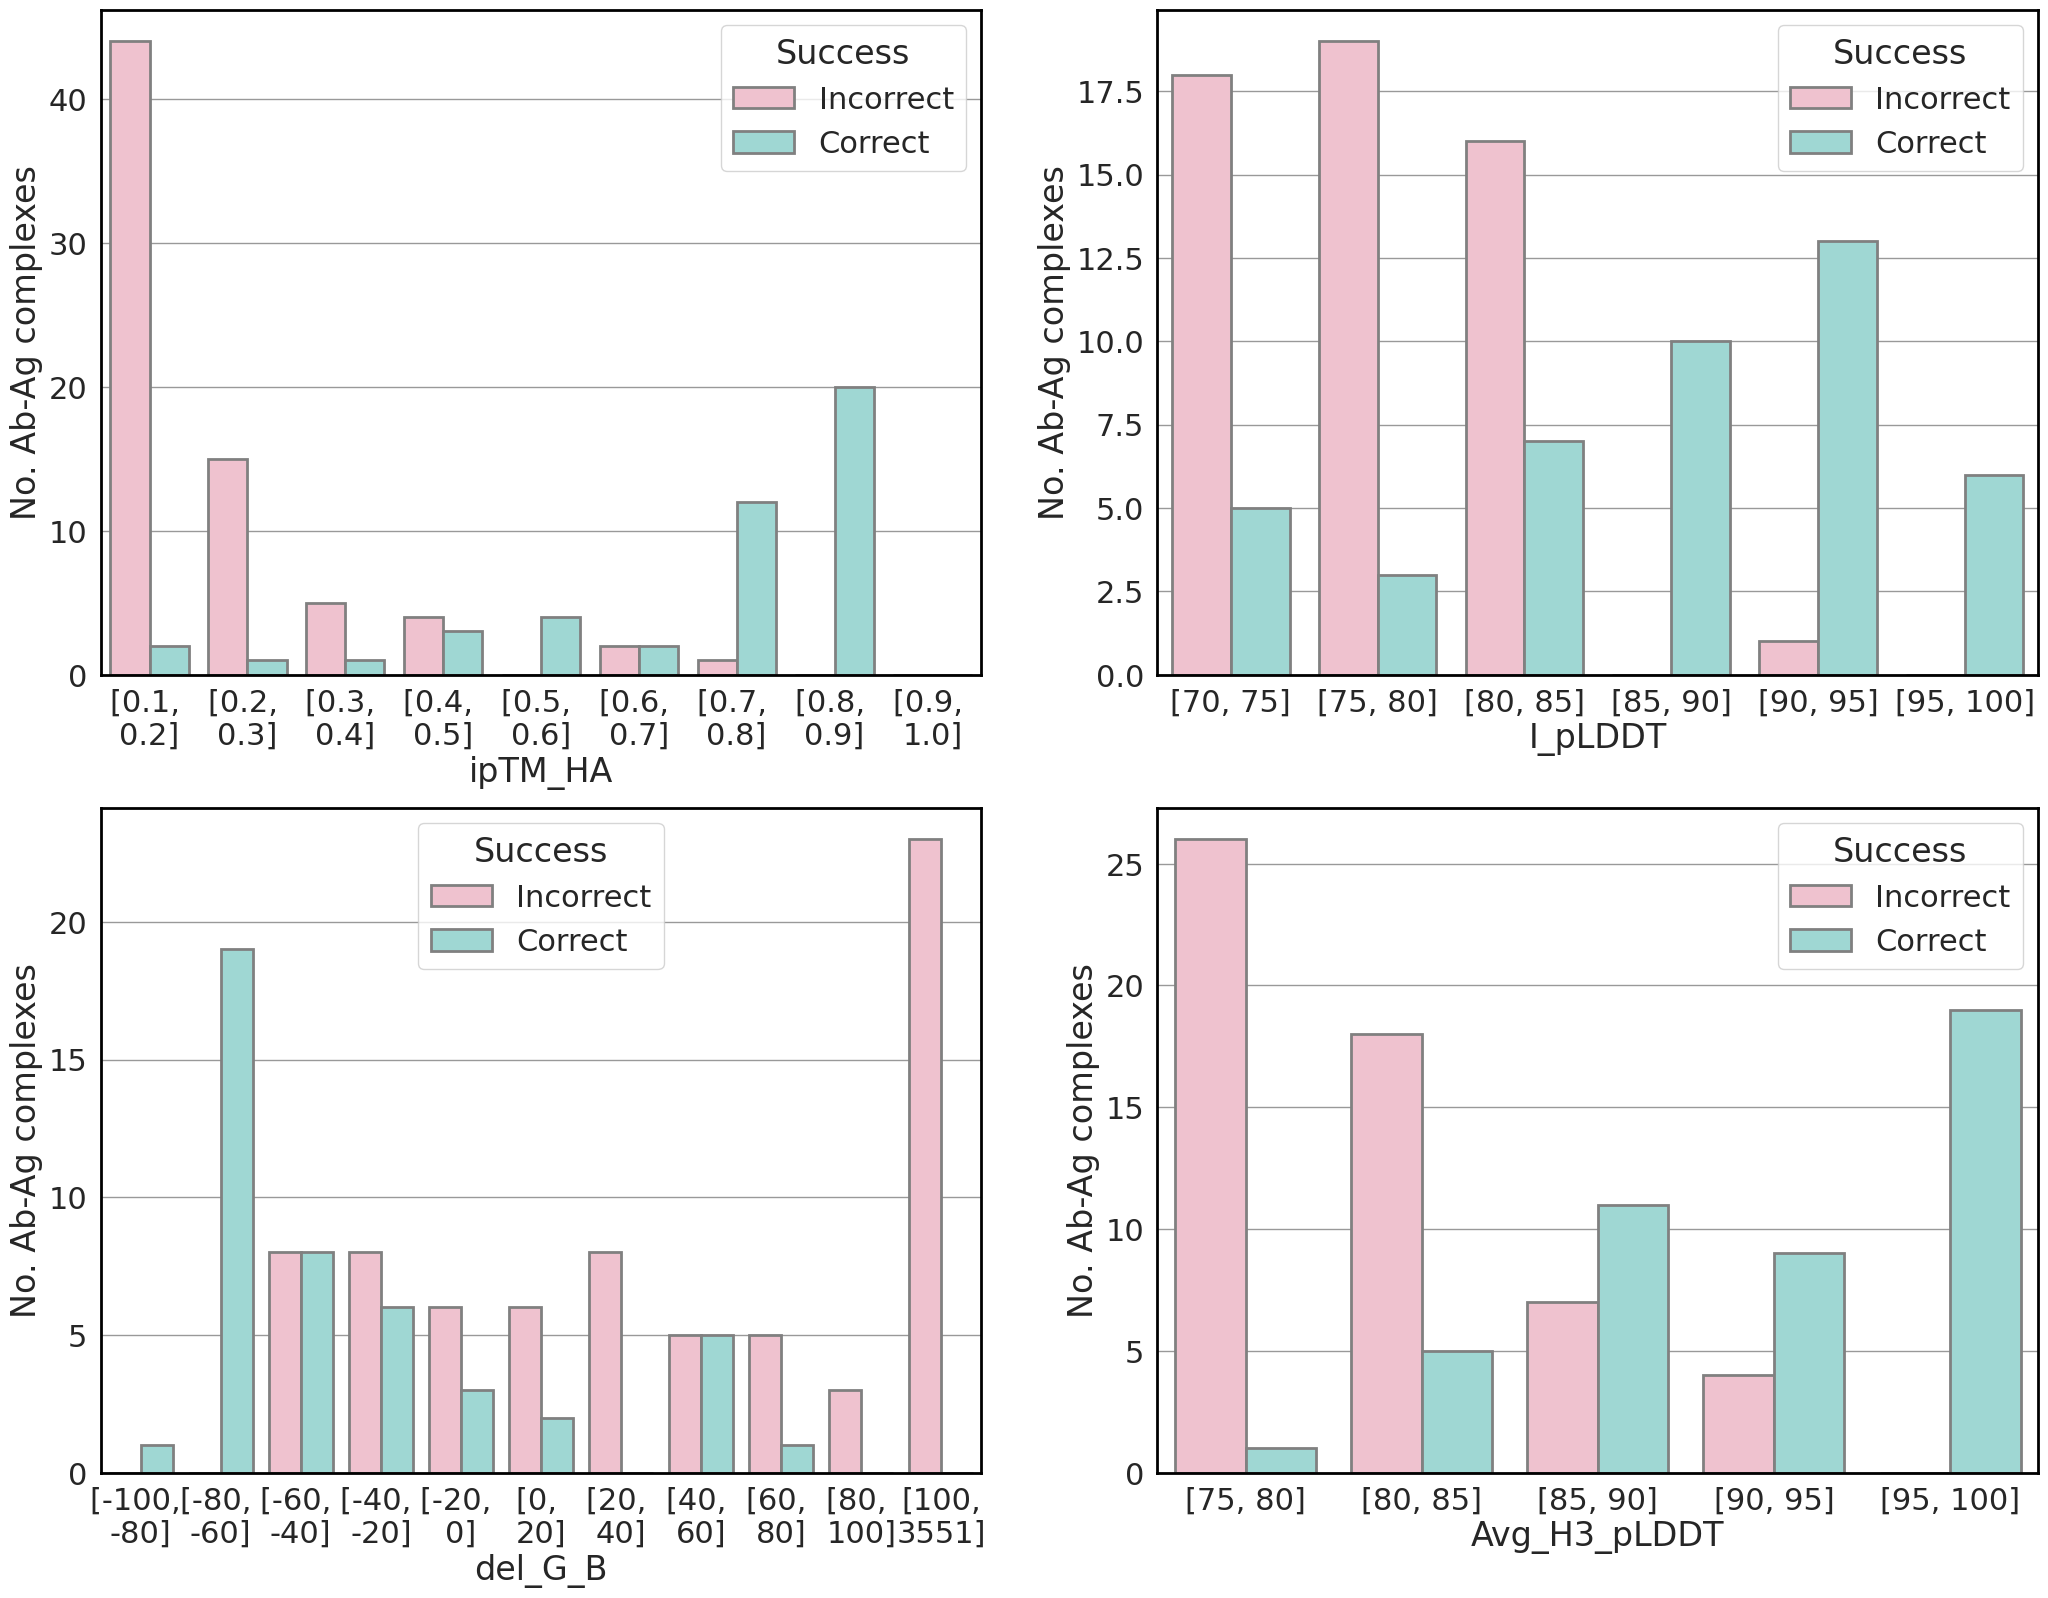

In [129]:
iptm_range = [list(np.array(list(range(i,i+2)))/10) for i in list(range(1,10))]
iplddt_range = [list(range(i,i+6,5)) for i in list(range(70,100,5))]
max_Ab_delGB = round(be_withothermetrics[be_withothermetrics['Protein_type']=='antibody'].del_G_B.max())
be_range = [[-100,-80],[-80,-60],[-60,-40],[-40,-20],[-20,0],[0,20],[20,40],[40,60],[60,80],[80,100],[100,max_Ab_delGB]]
dockQ_range = [0.8,0.49,0.23]
h3_rms_range = [1,1.5,2]
h3plddt_range = [[75,80],[80,85],[85,90],[90,95],[95,100]]
l3plddt_range = [75,85,95]
sns.set_style("whitegrid",{"grid.color":"0.6"})
fig, axes = plt.subplots(2, 2, figsize=(25,19), sharey=False)

ranges_all = [iptm_range,iplddt_range,be_range,h3plddt_range]
metric_correct_functions = [p_dockq_iptm,p_dockq_iplddt,p_dockq_bE,p_dockq_h3plddt]
metric_incorrect_functions = [p_inc_iptm,p_inc_iplddt,p_inc_bE,p_inc_h3plddt]
all_metric_names = ['ipTM_HA','I_pLDDT','del_G_B','Avg_H3_pLDDT']
metric_dfs = []
counter = 0
for i in all_metric_names:
    print(counter)
    if counter <2:
        k =int(0)
    else:
        k = int(1)
    if counter%2 ==0:
        j = int(0)
    else:
        j = int(1)
    
    ab_iptm_metric_ranges_correct,ab_iptm_metric_ranges_incorrect = n_cases_wrapper(be_withothermetrics,i,ranges_all[counter],n_cases,'antibody')
    inciptms_, incdockqs_,inciptm_dockq_ps = p_x_wrapper(metric_incorrect_functions[counter],be_withothermetrics,'antibody',[0.23],ranges_all[counter])
    iptms_, dockqs_,iptm_dockq_ps = p_x_wrapper(metric_correct_functions[counter],be_withothermetrics,'antibody',[0.23],ranges_all[counter])
    iptm_ab_dockq_df = pd.DataFrame({f"p(DockQ|{i})":iptm_dockq_ps,'DockQ':dockqs_,f'{i}':iptms_,'Correct':ab_iptm_metric_ranges_correct})
    inciptm_ab_dockq_df = pd.DataFrame({f"p(DockQ|{i})":inciptm_dockq_ps,'DockQ':incdockqs_,f'{i}':inciptms_,'Incorrect':ab_iptm_metric_ranges_incorrect})
    inciptm_ab_dockq_df[f'{i}']=inciptm_ab_dockq_df[f'{i}'].astype('string')
    iptm_ab_dockq_df[f'{i}']=iptm_ab_dockq_df[f'{i}'].astype('string')
    iptm_ab_dockq = iptm_ab_dockq_df.merge(inciptm_ab_dockq_df,on=['DockQ',f'{i}'],suffixes=('_correct','_incorrect'))
    iptm_ab_dockq = pd.melt(iptm_ab_dockq,id_vars=['DockQ',i],value_vars = ['Correct','Incorrect'],var_name = 'Success',value_name='No. Ab-Ag complexes')
    iptm_ab_dockq[f'p(DockQ|{i})'] = iptm_dockq_ps+inciptm_dockq_ps
    ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Ab-Ag complexes',hue='Success',\
                     hue_order=['Incorrect','Correct'],edgecolor='gray',dodge=True,palette=pastel_palette2,linewidth=2)
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    counter+=1
    metric_dfs.append(iptm_ab_dockq)
all_metrics_dfwithall = pd.concat(metric_dfs)
sns.set(font_scale=2)
axes[0,0].set_xticklabels(['[0.1, \n0.2]','[0.2, \n0.3]','[0.3, \n0.4]',\
                              '[0.4, \n0.5]','[0.5, \n0.6]','[0.6, \n0.7]',\
                                '[0.7, \n0.8]','[0.8, \n0.9]','[0.9, \n1.0]'])
axes[1,0].set_xticklabels(['[-100, \n-80]','[-80, \n-60]','[-60, \n-40]',\
                              '[-40, \n-20]','[-20, \n0]','[0, \n20]',\
                                '[20, \n40]','[40, \n60]','[60, \n80]',\
                                    '[80, \n100]',f'[100,\n{str(max_Ab_delGB)}]'])
plt.savefig(f"{filepath}Top_ranked_Ab_confidencemetricopt_barplots.svg",format='svg',dpi=700,transparent=True)

0


/tmp/ipykernel_654915/3372790797.py:44: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Nb-Ag complexes',hue='Success',\


1


/tmp/ipykernel_654915/3372790797.py:44: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Nb-Ag complexes',hue='Success',\


2


/tmp/ipykernel_654915/3372790797.py:44: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Nb-Ag complexes',hue='Success',\


3


/tmp/ipykernel_654915/3372790797.py:44: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Nb-Ag complexes',hue='Success',\
/tmp/ipykernel_654915/3372790797.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(['[0.1, \n0.2]','[0.2, \n0.3]','[0.3, \n0.4]',\
/tmp/ipykernel_654915/3372790797.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(['[-100, \n-80]','[-80, \n-60]','[-60, \n-40]',\


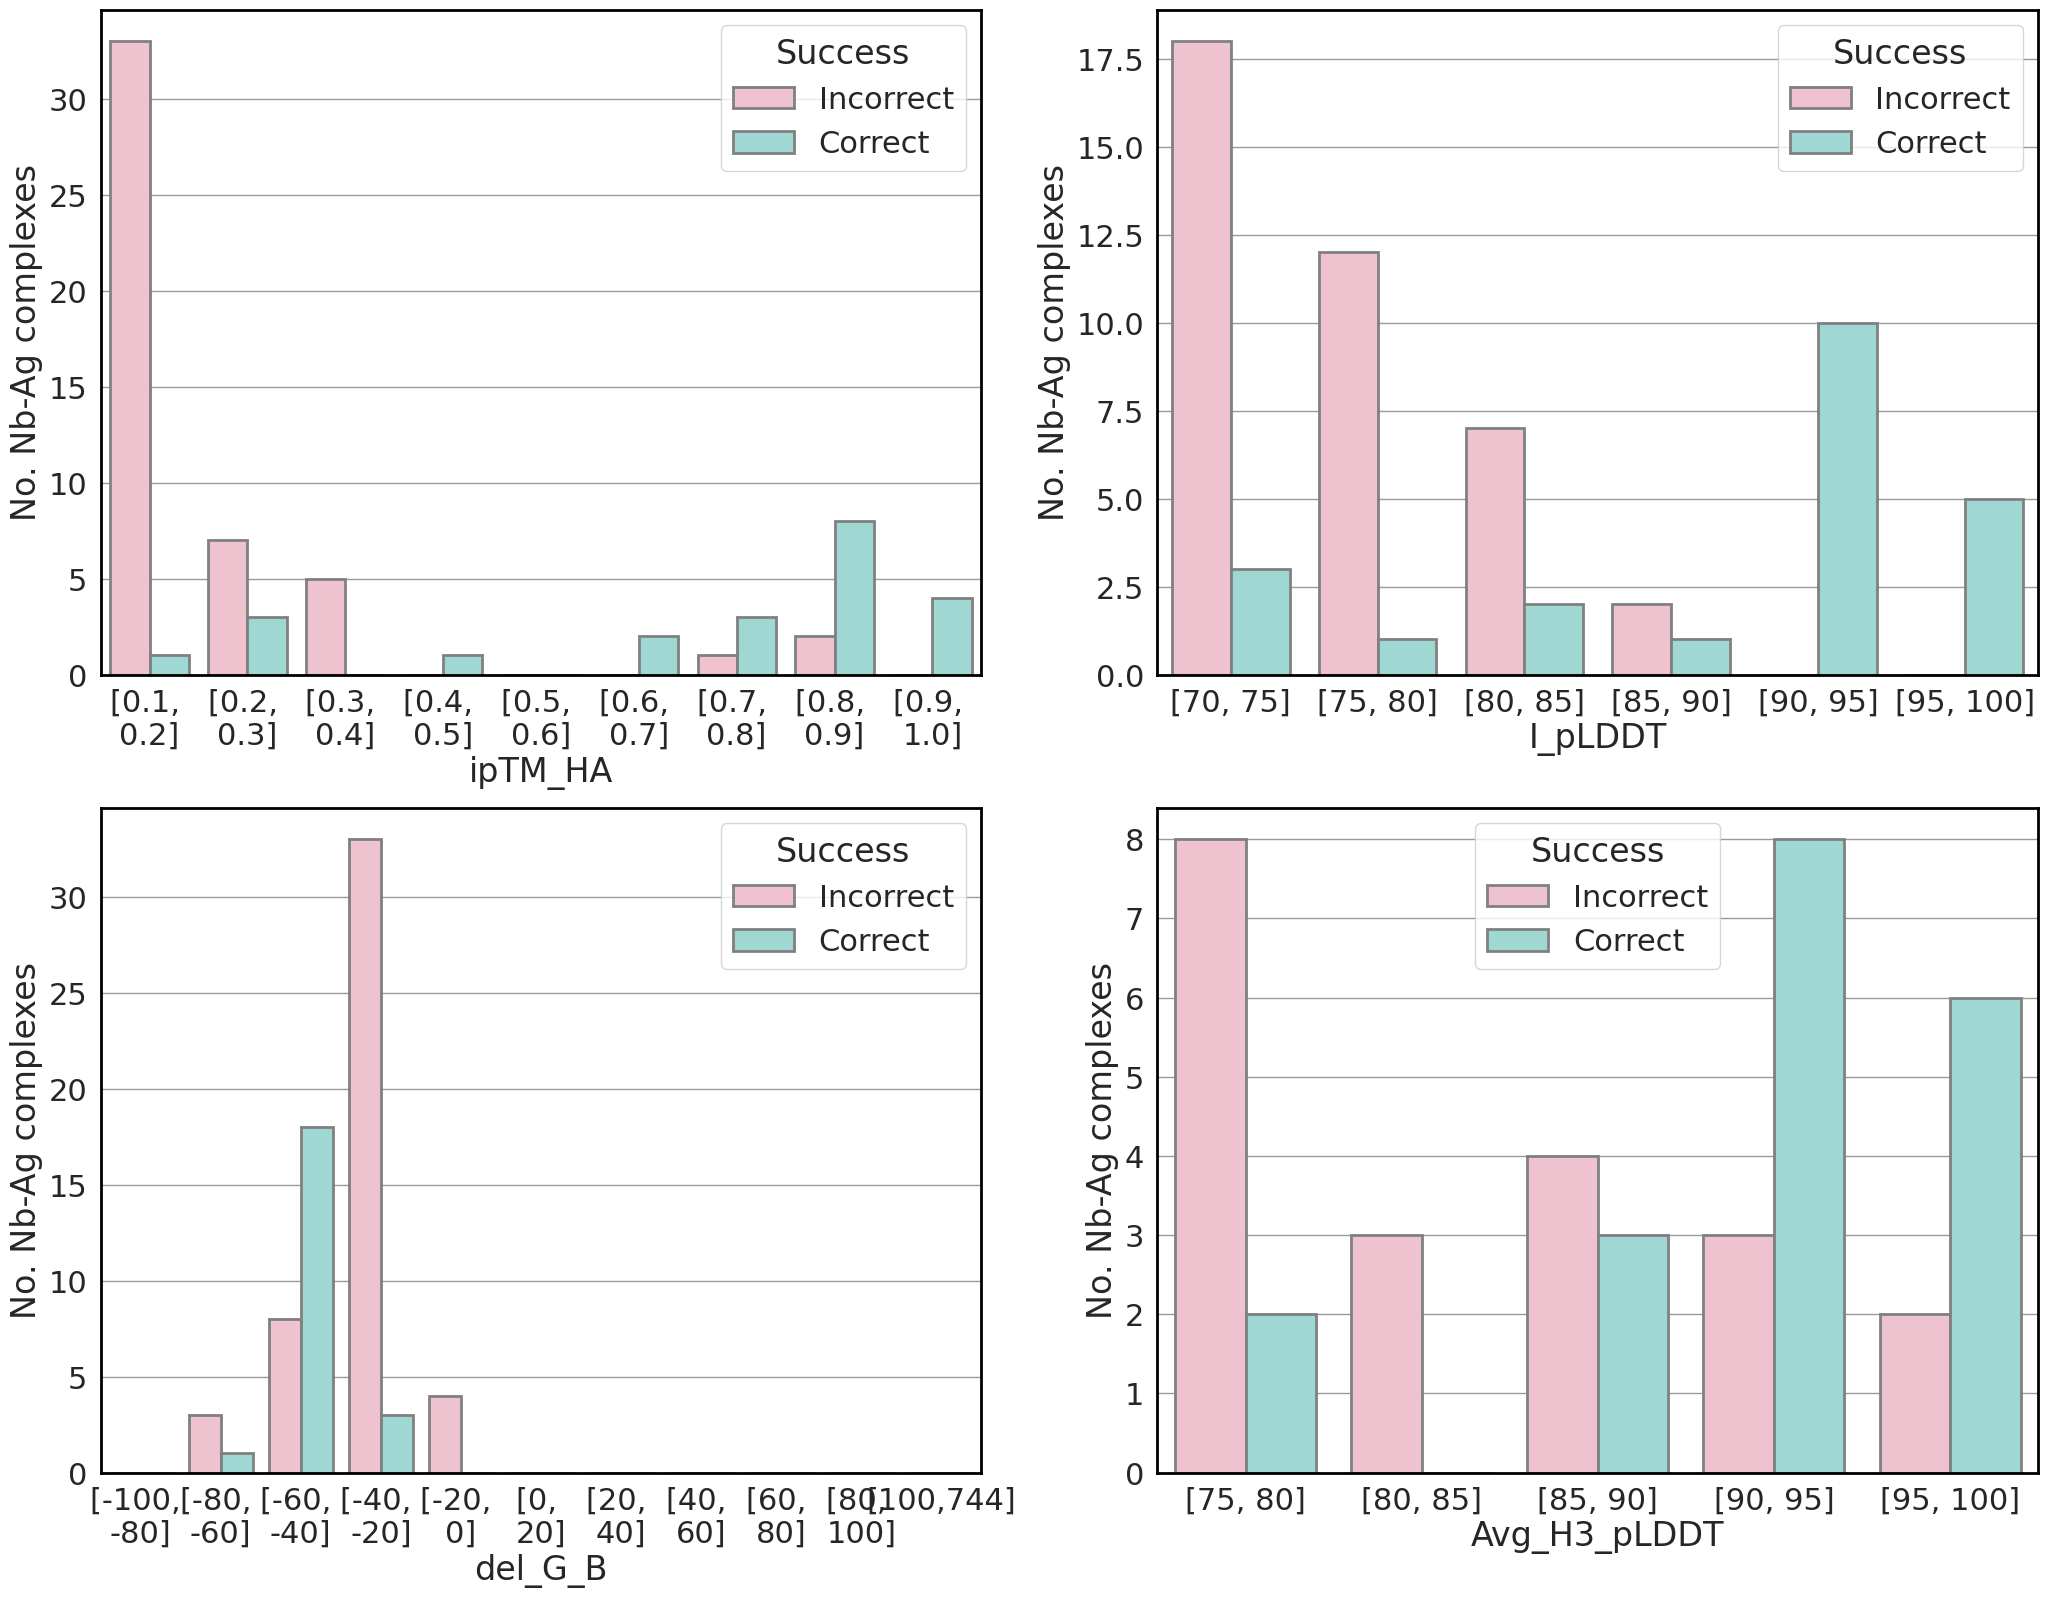

In [128]:

iptm_range = [list(np.array(list(range(i,i+2)))/10) for i in list(range(1,10))]
iplddt_range = [list(range(i,i+6,5)) for i in list(range(70,100,5))]
max_Nb_delGb = round(be_withothermetrics[be_withothermetrics['Protein_type']=='nanobody'].del_G_B.max())
be_range = [[-100,-80],[-80,-60],[-60,-40],[-40,-20],[-20,0],[0,20],[20,40],[40,60],[60,80],[80,100],[100,max_Nb_delGb]]
dockQ_range = [0.8,0.49,0.23]
h3_rms_range = [1,1.5,2]
h3plddt_range = [[75,80],[80,85],[85,90],[90,95],[95,100]]
l3plddt_range = [75,85,95]
sns.set_style("whitegrid",{"grid.color":"0.6"})
fig, axes = plt.subplots(2, 2, figsize=(25,19), sharey=False)

ranges_all = [iptm_range,iplddt_range,be_range,h3plddt_range]
metric_correct_functions = [p_dockq_iptm,p_dockq_iplddt,p_dockq_bE,p_dockq_h3plddt]
metric_incorrect_functions = [p_inc_iptm,p_inc_iplddt,p_inc_bE,p_inc_h3plddt]
all_metric_names = ['ipTM_HA','I_pLDDT','del_G_B','Avg_H3_pLDDT']
metric_dfs = []
counter = 0
for i in all_metric_names:
    print(counter)
    if counter <2:
        k =int(0)
    else:
        k = int(1)
    if counter%2 ==0:
        j = int(0)
    else:
        j = int(1)
    
    ab_iptm_metric_ranges_correct,ab_iptm_metric_ranges_incorrect = n_cases_wrapper(relaxbe_withothermetrics,i,ranges_all[counter],n_cases,'nanobody')
    inciptms_, incdockqs_,inciptm_dockq_ps = p_x_wrapper(metric_incorrect_functions[counter],relaxbe_withothermetrics,'nanobody',[0.23],ranges_all[counter])
    iptms_, dockqs_,iptm_dockq_ps = p_x_wrapper(metric_correct_functions[counter],relaxbe_withothermetrics,'nanobody',[0.23],ranges_all[counter])
    iptm_ab_dockq_df = pd.DataFrame({f"p(DockQ|{i})":iptm_dockq_ps,'DockQ':dockqs_,f'{i}':iptms_,'Correct':ab_iptm_metric_ranges_correct})
    inciptm_ab_dockq_df = pd.DataFrame({f"p(DockQ|{i})":inciptm_dockq_ps,'DockQ':incdockqs_,f'{i}':inciptms_,'Incorrect':ab_iptm_metric_ranges_incorrect})
    inciptm_ab_dockq_df[f'{i}']=inciptm_ab_dockq_df[f'{i}'].astype('string')
    iptm_ab_dockq_df[f'{i}']=iptm_ab_dockq_df[f'{i}'].astype('string')
    iptm_ab_dockq = iptm_ab_dockq_df.merge(inciptm_ab_dockq_df,on=['DockQ',f'{i}'],suffixes=('_correct','_incorrect'))
    iptm_ab_dockq = pd.melt(iptm_ab_dockq,id_vars=['DockQ',i],value_vars = ['Correct','Incorrect'],var_name = 'Success',value_name='No. Nb-Ag complexes')
    iptm_ab_dockq[f'p(DockQ|{i})'] = iptm_dockq_ps+inciptm_dockq_ps
    ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Nb-Ag complexes',hue='Success',\
                     hue_order=['Incorrect','Correct'],edgecolor='gray',dodge=True,palette=pastel_palette2,linewidth=2)
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    counter+=1
    metric_dfs.append(iptm_ab_dockq)
all_metrics_dfwithall = pd.concat(metric_dfs)
sns.set(font_scale=2)
axes[0,0].set_xticklabels(['[0.1, \n0.2]','[0.2, \n0.3]','[0.3, \n0.4]',\
                              '[0.4, \n0.5]','[0.5, \n0.6]','[0.6, \n0.7]',\
                                '[0.7, \n0.8]','[0.8, \n0.9]','[0.9, \n1.0]']) 
axes[1,0].set_xticklabels(['[-100, \n-80]','[-80, \n-60]','[-60, \n-40]',\
                              '[-40, \n-20]','[-20, \n0]','[0, \n20]',\
                                '[20, \n40]','[40, \n60]','[60, \n80]',\
                                    '[80, \n100]',f'[100,{str(max_Nb_delGb)}]'])
plt.savefig(f"{filepath}Topranked_Nb_confidencemetricopt_relaxed.svg",format='svg',dpi=700,transparent=True)

0


/tmp/ipykernel_654915/1785301490.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Nb-Ag complexes',hue='Success',\


1


/tmp/ipykernel_654915/1785301490.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Nb-Ag complexes',hue='Success',\


2


/tmp/ipykernel_654915/1785301490.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Nb-Ag complexes',hue='Success',\


3


/tmp/ipykernel_654915/1785301490.py:43: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Nb-Ag complexes',hue='Success',\
/tmp/ipykernel_654915/1785301490.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(['[0.1, \n0.2]','[0.2, \n0.3]','[0.3, \n0.4]',\
/tmp/ipykernel_654915/1785301490.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(['[-100, \n-80]','[-80, \n-60]','[-60, \n-40]',\


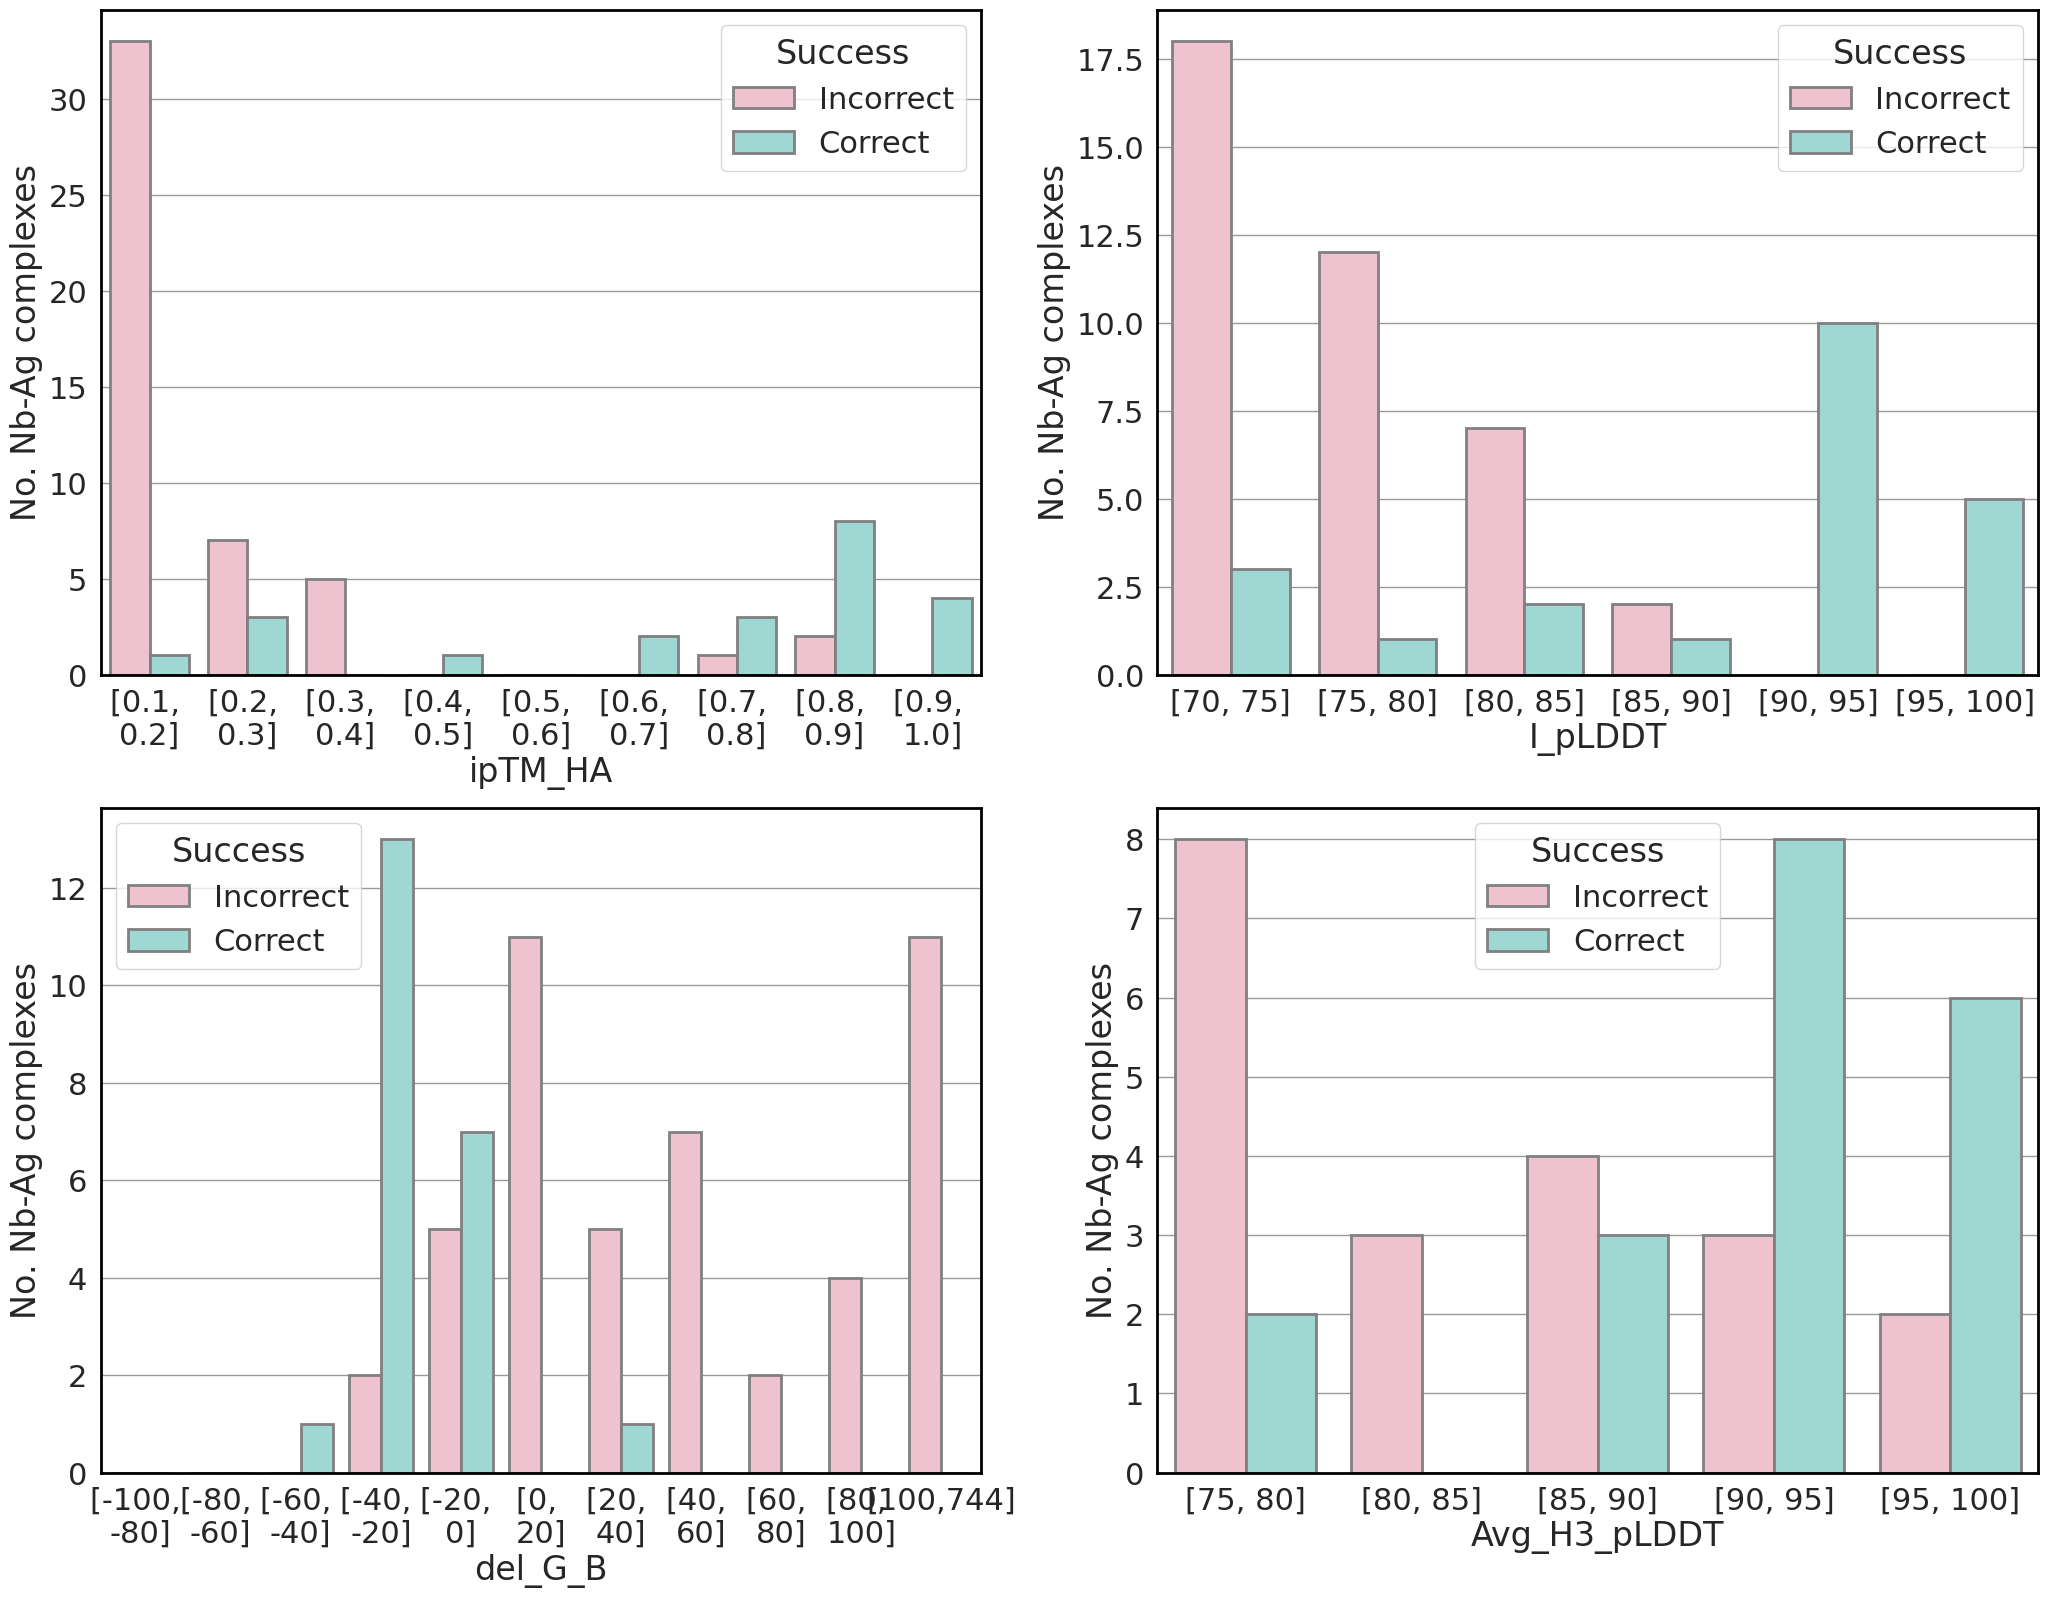

In [127]:
iptm_range = [list(np.array(list(range(i,i+2)))/10) for i in list(range(1,10))]
# iplddt_range = list(np.array(range(70,105,5)))
iplddt_range = [list(range(i,i+6,5)) for i in list(range(70,100,5))]
max_Nb_delGb = round(be_withothermetrics[be_withothermetrics['Protein_type']=='nanobody'].del_G_B.max())
be_range = [[-100,-80],[-80,-60],[-60,-40],[-40,-20],[-20,0],[0,20],[20,40],[40,60],[60,80],[80,100],[100,max_Nb_delGb]]
dockQ_range = [0.8,0.49,0.23]
h3_rms_range = [1,1.5,2]
h3plddt_range = [[75,80],[80,85],[85,90],[90,95],[95,100]]
l3plddt_range = [75,85,95]
sns.set_style("whitegrid",{"grid.color":"0.6"})
fig, axes = plt.subplots(2, 2, figsize=(25,19), sharey=False)

ranges_all = [iptm_range,iplddt_range,be_range,h3plddt_range]
metric_correct_functions = [p_dockq_iptm,p_dockq_iplddt,p_dockq_bE,p_dockq_h3plddt]
metric_incorrect_functions = [p_inc_iptm,p_inc_iplddt,p_inc_bE,p_inc_h3plddt]
all_metric_names = ['ipTM_HA','I_pLDDT','del_G_B','Avg_H3_pLDDT']
metric_dfs = []
counter = 0
for i in all_metric_names:
    print(counter)
    if counter <2:
        k =int(0)
    else:
        k = int(1)
    if counter%2 ==0:
        j = int(0)
    else:
        j = int(1)
    
    ab_iptm_metric_ranges_correct,ab_iptm_metric_ranges_incorrect = n_cases_wrapper(be_withothermetrics,i,ranges_all[counter],n_cases,'nanobody')
    inciptms_, incdockqs_,inciptm_dockq_ps = p_x_wrapper(metric_incorrect_functions[counter],be_withothermetrics,'nanobody',[0.23],ranges_all[counter])
    iptms_, dockqs_,iptm_dockq_ps = p_x_wrapper(metric_correct_functions[counter],be_withothermetrics,'nanobody',[0.23],ranges_all[counter])
    iptm_ab_dockq_df = pd.DataFrame({f"p(DockQ|{i})":iptm_dockq_ps,'DockQ':dockqs_,f'{i}':iptms_,'Correct':ab_iptm_metric_ranges_correct})
    inciptm_ab_dockq_df = pd.DataFrame({f"p(DockQ|{i})":inciptm_dockq_ps,'DockQ':incdockqs_,f'{i}':inciptms_,'Incorrect':ab_iptm_metric_ranges_incorrect})
    inciptm_ab_dockq_df[f'{i}']=inciptm_ab_dockq_df[f'{i}'].astype('string')
    iptm_ab_dockq_df[f'{i}']=iptm_ab_dockq_df[f'{i}'].astype('string')
    # iptm_ab_dockq = pd.concat([iptm_ab_dockq_df,inciptm_ab_dockq_df],axis=1)
    iptm_ab_dockq = iptm_ab_dockq_df.merge(inciptm_ab_dockq_df,on=['DockQ',f'{i}'],suffixes=('_correct','_incorrect'))
    iptm_ab_dockq = pd.melt(iptm_ab_dockq,id_vars=['DockQ',i],value_vars = ['Correct','Incorrect'],var_name = 'Success',value_name='No. Nb-Ag complexes')
    iptm_ab_dockq[f'p(DockQ|{i})'] = iptm_dockq_ps+inciptm_dockq_ps
    ax = sns.barplot(ax=axes[k,j],data=iptm_ab_dockq,x=i,y='No. Nb-Ag complexes',hue='Success',\
                     hue_order=['Incorrect','Correct'],edgecolor='gray',dodge=True,palette=pastel_palette2,linewidth=2)
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    counter+=1
    metric_dfs.append(iptm_ab_dockq)
all_metrics_dfwithall = pd.concat(metric_dfs)
sns.set(font_scale=2)
axes[0,0].set_xticklabels(['[0.1, \n0.2]','[0.2, \n0.3]','[0.3, \n0.4]',\
                              '[0.4, \n0.5]','[0.5, \n0.6]','[0.6, \n0.7]',\
                                '[0.7, \n0.8]','[0.8, \n0.9]','[0.9, \n1.0]'])
axes[1,0].set_xticklabels(['[-100, \n-80]','[-80, \n-60]','[-60, \n-40]',\
                              '[-40, \n-20]','[-20, \n0]','[0, \n20]',\
                                '[20, \n40]','[40, \n60]','[60, \n80]',\
                                    '[80, \n100]',f'[100,{str(max_Nb_delGb)}]'])
plt.savefig(f"{filepath}Topranked_Nb_confidencemetricopt_barplots.svg",format='svg',dpi=700,transparent=True)

In [126]:
all_metrics_dfwithall.to_csv("results/round_6/datafiles/uncapped_topranked_correct_v_incorrect_AbAgmetrics.csv")

In [90]:
def perc_wrapper(df,metric):
    corr_percs = []
    incorr_percs = []
    for i in df[metric].unique().dropna().tolist():
        correct_abs = df[(df[metric]==i)&(df['Success']=='Correct')]['No. Ab-Ag complexes'].item()
        incorrect_abs = df[(df[metric]==i)&(df['Success']=='Incorrect')]['No. Ab-Ag complexes'].item()
        total = correct_abs + incorrect_abs
        try:
            corr_percent = correct_abs/total
        except:
            corr_percent = 0
        try:
            incorr_percent = incorrect_abs/total
        except:
            incorr_percent = 0
        corr_percs.append(corr_percent*100)
        incorr_percs.append(incorr_percent*100)
    percentages_nb = pd.DataFrame({metric:df[metric].unique().dropna().tolist(),metric+"Correct_%":corr_percs,metric+"_Incorrect_%":incorr_percs})
    return percentages_nb

### iptm vs iplddt AUROC

In [29]:
def tpr_calc(df,ptype,metric,threshold_range):
    tprs = []
    for i in threshold_range:
        tp = df[(df['Protein_type']==ptype)&(df[metric]>=i)&(df['DockQ']>=0.23)].shape[0]
        fn = df[(df['Protein_type']==ptype)&(df[metric]<i)&(df['DockQ']>=0.23)].shape[0]
        tpr = tp / (tp+fn)
        tprs.append(tpr)
    return tprs

def fpr_calc(df,ptype,metric,threshold_range):
    fprs = []
    for i in threshold_range:
        fp = df[(df['Protein_type']==ptype)&(df[metric]>=i)&(df['DockQ']<0.23)].shape[0]
        tn = df[(df['Protein_type']==ptype)&(df[metric]<i)&(df['DockQ']<0.23)].shape[0]
        fpr = fp / (fp+tn)
        fprs.append(fpr)
    return fprs

def tpr_energies_calc(df,ptype,metric,threshold_range):
    tprs = []
    for i in threshold_range:
        tp = df[(df['Protein_type']==ptype)&(df[metric]<=i)&(df['DockQ']>=0.23)].shape[0]
        fn = df[(df['Protein_type']==ptype)&(df[metric]>i)&(df['DockQ']>=0.23)].shape[0]
        tpr = tp / (tp+fn)
        tprs.append(tpr)
    return tprs

def fpr_energies_calc(df,ptype,metric,threshold_range):
    fprs = []
    for i in threshold_range:
        fp = df[(df['Protein_type']==ptype)&(df[metric]<=i)&(df['DockQ']<0.23)].shape[0]
        tn = df[(df['Protein_type']==ptype)&(df[metric]>i)&(df['DockQ']<0.23)].shape[0]
        fpr = fp / (fp+tn)
        fprs.append(fpr)
    return fprs

def double_metric_tpr_old(df,ptype,metric1,metric1_cutoff,metric2,metric2_range):
    tprs = []
    for i in metric2_range:
        if metric2!='del_G_B':
            tp = df[(df['Protein_type']==ptype)&(df[metric1]>metric1_cutoff)&(df[metric2]>=i)&(df['DockQ']>=0.23)].shape[0]
            fn = df[(df['Protein_type']==ptype)&(df[metric1]<metric1_cutoff)&(df[metric2]<i)&(df['DockQ']>=0.23)].shape[0]
            tpr = tp / (tp+fn)
            tprs.append(tpr)
        else:
            tp = df[(df['Protein_type']==ptype)&(df[metric1]>metric1_cutoff)&(df[metric2]<i)&(df['DockQ']>=0.23)].shape[0]
            fn = df[(df['Protein_type']==ptype)&(df[metric1]<metric1_cutoff)&(df[metric2]>=i)&(df['DockQ']>=0.23)].shape[0]
            tpr = tp / (tp+fn)
            tprs.append(tpr)
    return tprs

def double_metric_tpr(df,ptype,metric1,metric1_range,metric2,metric2_range):
    tprs = []
    for i in metric1_range:
        for j in metric2_range:
            if metric1=='del_G_B':
                if metric2!='del_G_B':
                    tp = df[(df['Protein_type']==ptype)&(df[metric1]<=i)&(df[metric2]>=j)&(df['DockQ']>=0.23)].shape[0]
                    fn = df[(df['Protein_type']==ptype)&(df[metric1]>i)&(df[metric2]<j)&(df['DockQ']>=0.23)].shape[0]
                    tpr = tp / (tp+fn)
                    tprs.append(tpr)
                else:
                    tp = df[(df['Protein_type']==ptype)&(df[metric1]<i)&(df[metric2]<j)&(df['DockQ']>=0.23)].shape[0]
                    fn = df[(df['Protein_type']==ptype)&(df[metric1]>=i)&(df[metric2]>=j)&(df['DockQ']>=0.23)].shape[0]
                    # print(f"{i}")
                    # print(f"{j}")
                    # print(f"tp: {tp}")
                    # print(f"fn: {fn}")
                    tpr = tp / (tp+fn)
                    tprs.append(tpr)
            else:
                if metric2!='del_G_B':
                    tp = df[(df['Protein_type']==ptype)&(df[metric1]>=i)&(df[metric2]>=j)&(df['DockQ']>=0.23)].shape[0]
                    fn = df[(df['Protein_type']==ptype)&(df[metric1]<i)&(df[metric2]<j)&(df['DockQ']>=0.23)].shape[0]
                    tpr = tp / (tp+fn)
                    tprs.append(tpr)
                else:
                    tp = df[(df['Protein_type']==ptype)&(df[metric1]>i)&(df[metric2]<j)&(df['DockQ']>=0.23)].shape[0]
                    fn = df[(df['Protein_type']==ptype)&(df[metric1]<=i)&(df[metric2]>=j)&(df['DockQ']>=0.23)].shape[0]
                    # print(f"{i}")
                    # print(f"{j}")
                    # print(f"tp: {tp}")
                    # print(f"fn: {fn}")
                    tpr = tp / (tp+fn)
                    tprs.append(tpr)
    return tprs

def double_metric_fpr(df,ptype,metric1,metric1_range,metric2,metric2_range):
    fprs = []
    for i in metric1_range:
        for j in metric2_range:
            if metric1=='del_G_B':
                if metric2!='del_G_B':
                    fp = df[(df['Protein_type']==ptype)&(df[metric1]<=i)&(df[metric2]>=j)&(df['DockQ']<0.23)].shape[0]
                    tn = df[(df['Protein_type']==ptype)&(df[metric1]>i)&(df[metric2]<j)&(df['DockQ']<0.23)].shape[0]
                    # print(f"{i}")
                    # print(f"{j}")
                    # print(f"tp: {fp}")
                    # print(f"fn: {tn}")
                    fpr = fp / (fp+tn)
                    fprs.append(fpr)
                else:
                    fp = df[(df['Protein_type']==ptype)&(df[metric1]<i)&(df[metric2]<j)&(df['DockQ']<0.23)].shape[0]
                    tn = df[(df['Protein_type']==ptype)&(df[metric1]>=i)&(df[metric2]>=j)&(df['DockQ']<0.23)].shape[0]
                    # print(f"{i}")
                    # print(f"{j}")
                    # print(f"tp: {fp}")
                    # print(f"fn: {tn}")
                    fpr = fp / (fp+tn)
                    fprs.append(fpr)
            else:
                if metric2!='del_G_B':
                    fp = df[(df['Protein_type']==ptype)&(df[metric1]>=i)&(df[metric2]>=j)&(df['DockQ']<0.23)].shape[0]
                    tn = df[(df['Protein_type']==ptype)&(df[metric1]<i)&(df[metric2]<j)&(df['DockQ']<0.23)].shape[0]
                    # print(f"{i}")
                    # print(f"{j}")
                    # print(f"tp: {fp}")
                    # print(f"fn: {tn}")
                    fpr = fp / (fp+tn)
                    fprs.append(fpr)
                else:
                    fp = df[(df['Protein_type']==ptype)&(df[metric1]>i)&(df[metric2]<j)&(df['DockQ']<0.23)].shape[0]
                    tn = df[(df['Protein_type']==ptype)&(df[metric1]<=i)&(df[metric2]>=j)&(df['DockQ']<0.23)].shape[0]
                    # print(f"{i}")
                    # print(f"{j}")
                    # print(f"tp: {fp}")
                    # print(f"fn: {tn}")
                    fpr = fp / (fp+tn)
                    fprs.append(fpr)
    return fprs

In [39]:
# redoing AUC calcs, but using set optimized threshold of interface metrics and judging second metric with it

iplddt_range_abs = np.array(list(range(48,96,2)))
iplddt_range_nbs = np.array(list(range(63,96,1)))
iptm_range_abs = np.array(list(range(1,90,3)))/100
iptm_set_range_abs = [float(0.5)]
iplddt_set_range_abs = [float(85)]
iptmla_range_abs = np.array(list(range(0,101,1)))/100
iptm_range_nbs = np.array(list(range(11,93,1)))/100
iptm_set_range_nbs = [0.4]
iplddt_set_range_nbs = [float(85)]
h3_range_abs = np.array(list(range(62,95,3)))
h3_range_nbs = np.array(list(range(55,98,1)))
delgb_range_nbs = np.array(list(range(-40,100,2))+[98,round(be_withothermetrics[be_withothermetrics['Protein_type']=='nanobody'].del_G_B.max())])
delgb_range_abs = np.array(list(range(round(be_withothermetrics[be_withothermetrics['Protein_type']=='antibody'].del_G_B.min()),100,2))+[98,round(be_withothermetrics[be_withothermetrics['Protein_type']=='antibody'].del_G_B.max())])
ab_iplddt_tprs = tpr_calc(be_withothermetrics,'antibody','I_pLDDT',iplddt_range_abs)
ab_iptm_fprs = fpr_calc(be_withothermetrics,'antibody','ipTM_HA',iptm_range_abs)
ab_iptmla_fprs = fpr_calc(be_withothermetrics,'antibody','ipTM_LA',iptmla_range_abs)
ab_iptm_tprs = tpr_calc(be_withothermetrics,'antibody','ipTM_HA',iptm_range_abs)
ab_iptmla_tprs = tpr_calc(be_withothermetrics,'antibody','ipTM_LA',iptmla_range_abs)
ab_iplddt_fprs = fpr_calc(be_withothermetrics,'antibody','I_pLDDT',iplddt_range_abs)
ab_delgb_tprs = tpr_energies_calc(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_abs[-1]+50],'antibody','del_G_B',delgb_range_abs)
ab_delgb_fprs = fpr_energies_calc(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_abs[-1]+50],'antibody','del_G_B',delgb_range_abs)
ab_h3plddt_tprs = tpr_calc(be_withothermetrics,'antibody','Avg_H3_pLDDT',h3_range_abs)
ab_h3plddt_fprs = fpr_calc(be_withothermetrics,'antibody','Avg_H3_pLDDT',h3_range_abs)
ab_iptm_delgb_tprs = double_metric_tpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_abs[-1]+50],'antibody','ipTM_HA',iptm_set_range_abs,'del_G_B',delgb_range_abs)
ab_iptm_delgb_fprs = double_metric_fpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_abs[-1]+50],'antibody','ipTM_HA',iptm_set_range_abs,'del_G_B',delgb_range_abs)
ab_iptm_h3plddt_tprs = double_metric_tpr(be_withothermetrics,'antibody','ipTM_HA',iptm_set_range_abs,'Avg_H3_pLDDT',h3_range_abs)
ab_iptm_h3plddt_fprs = double_metric_fpr(be_withothermetrics,'antibody','ipTM_HA',iptm_set_range_abs,'Avg_H3_pLDDT',h3_range_abs)
ab_iplddt_delgb_tprs = double_metric_tpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_abs[-1]+50],'antibody','I_pLDDT',iplddt_set_range_abs,'del_G_B',delgb_range_abs)
ab_iplddt_delgb_fprs = double_metric_fpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_abs[-1]+50],'antibody','I_pLDDT',iplddt_set_range_abs,'del_G_B',delgb_range_abs)
ab_iplddt_h3plddt_tprs = double_metric_tpr(be_withothermetrics,'antibody','I_pLDDT',iplddt_set_range_abs,'Avg_H3_pLDDT',h3_range_abs)
ab_iplddt_h3plddt_fprs = double_metric_fpr(be_withothermetrics,'antibody','I_pLDDT',iplddt_set_range_abs,'Avg_H3_pLDDT',h3_range_abs)
ab_delgb_iplddt_tprs = double_metric_tpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_abs[-1]+10],'antibody','del_G_B',[-40.0],'I_pLDDT',iplddt_range_abs)
ab_delgb_iplddt_fprs = double_metric_fpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_abs[-1]+10],'antibody','del_G_B',[-40.0],'I_pLDDT',iplddt_range_abs)
print('antibodies done!')

nb_iplddt_tprs = tpr_calc(be_withothermetrics,'nanobody','I_pLDDT',iplddt_range_nbs)
nb_iplddt_fprs = fpr_calc(be_withothermetrics,'nanobody','I_pLDDT',iplddt_range_nbs)
nb_iptm_tprs = tpr_calc(be_withothermetrics,'nanobody','ipTM_HA',iptm_range_nbs)
nb_iptm_fprs = fpr_calc(be_withothermetrics,'nanobody','ipTM_HA',iptm_range_nbs)
nb_delgb_tprs = tpr_energies_calc(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_nbs[-1]+10],'nanobody','del_G_B',delgb_range_nbs)
nb_delgb_fprs = fpr_energies_calc(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_nbs[-1]+10],'nanobody','del_G_B',delgb_range_nbs)
nb_h3plddt_tprs = tpr_calc(be_withothermetrics,'nanobody','Avg_H3_pLDDT',h3_range_nbs)
nb_h3plddt_fprs = fpr_calc(be_withothermetrics,'nanobody','Avg_H3_pLDDT',h3_range_nbs)
nb_iptm_delgb_tprs = double_metric_tpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_nbs[-1]+10],'nanobody','ipTM_HA',iptm_set_range_nbs,'del_G_B',delgb_range_nbs)
nb_iptm_delgb_fprs = double_metric_fpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_nbs[-1]+10],'nanobody','ipTM_HA',iptm_set_range_nbs,'del_G_B',delgb_range_nbs)
nb_iptm_h3plddt_tprs = double_metric_tpr(be_withothermetrics,'nanobody','ipTM_HA',iptm_set_range_nbs,'Avg_H3_pLDDT',h3_range_nbs)
nb_iptm_h3plddt_fprs = double_metric_fpr(be_withothermetrics,'nanobody','ipTM_HA',iptm_set_range_nbs,'Avg_H3_pLDDT',h3_range_nbs)
nb_iplddt_delgb_tprs = double_metric_tpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_nbs[-1]+10],'nanobody','I_pLDDT',iplddt_set_range_nbs,'del_G_B',delgb_range_nbs)
nb_iplddt_delgb_fprs = double_metric_fpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_nbs[-1]+10],'nanobody','I_pLDDT',iplddt_set_range_nbs,'del_G_B',delgb_range_nbs)
nb_iplddt_h3plddt_tprs = double_metric_tpr(be_withothermetrics,'nanobody','I_pLDDT',iplddt_set_range_nbs,'Avg_H3_pLDDT',h3_range_nbs)
nb_iplddt_h3plddt_fprs = double_metric_fpr(be_withothermetrics,'nanobody','I_pLDDT',iplddt_set_range_nbs,'Avg_H3_pLDDT',h3_range_nbs)
nb_delgb_iplddt_tprs = double_metric_tpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_nbs[-1]+10],'nanobody','del_G_B',[0.0],'I_pLDDT',iplddt_range_nbs)
nb_delgb_iplddt_fprs = double_metric_fpr(be_withothermetrics[be_withothermetrics['del_G_B']<=delgb_range_nbs[-1]+10],'nanobody','del_G_B',[0.0],'I_pLDDT',iplddt_range_nbs)
print('nanobodies done!')

antibodies done!
nanobodies done!


In [42]:
ab_auroc = pd.DataFrame({"Metric":['I_plDDT']*len(ab_iplddt_tprs) \
    +['ipTM_HA']*len(ab_iptm_tprs)+['ipTM_LA']*len(ab_iptmla_tprs) \
        +['del_G_B']*len(ab_delgb_tprs) + ['Avg_H3_pLDDT']*len(ab_h3plddt_tprs)+['ipTM_HA & del_G_B']*len(ab_iptm_delgb_tprs)+\
            ['ipTM_HA & Avg_H3_pLDDT']*len(ab_iptm_h3plddt_tprs)+\
                ['I_pLDDT>85 & del_G_B']*len(ab_iplddt_delgb_tprs)\
                +['I_pLDDT & Avg_H3_pLDDT']*len(ab_iplddt_h3plddt_tprs)\
                +['del_G_B<-40 & I_pLDDT']*len(ab_delgb_iplddt_tprs),\
    'True positive rate':ab_iplddt_tprs+ab_iptm_tprs+ab_iptmla_tprs+ab_delgb_tprs+ab_h3plddt_tprs+ab_iptm_delgb_tprs+ab_iptm_h3plddt_tprs+ab_iplddt_delgb_tprs+ab_iplddt_h3plddt_tprs+ab_delgb_iplddt_tprs,\
        'False positive rate':ab_iplddt_fprs+ab_iptm_fprs+ab_iptmla_fprs+ab_delgb_fprs+ab_h3plddt_fprs\
            +ab_iptm_delgb_fprs+ab_iptm_h3plddt_fprs+ab_iplddt_delgb_fprs+ab_iplddt_h3plddt_fprs+ab_delgb_iplddt_fprs,\
                'Metric 1 Values':list(iplddt_range_abs)+list(iptm_range_abs)+list(iptmla_range_abs)+list(delgb_range_abs)+list(h3_range_abs)+iptm_set_range_abs*len(ab_iptm_delgb_tprs)+iptm_set_range_abs*len(ab_iptm_h3plddt_tprs)+iplddt_set_range_abs*len(ab_iplddt_delgb_tprs)+iplddt_set_range_abs*len(ab_iplddt_h3plddt_tprs)+[0.0]*len(ab_delgb_iplddt_tprs),\
                    'Metric 2 Values':[np.nan]*[len(ab_iplddt_tprs)+len(ab_iptm_tprs)+len(ab_iptmla_tprs)+len(ab_delgb_tprs)+len(ab_h3plddt_tprs)][0]+list(delgb_range_abs)+list(h3_range_abs)+list(delgb_range_abs)+list(h3_range_abs)+list(iplddt_range_abs)})

(488, 5)

In [43]:
nb_auroc = pd.DataFrame({"Metric":['I_plDDT']*len(nb_iplddt_tprs)+['ipTM_HA']*len(nb_iptm_tprs)\
    +['del_G_B']*len(nb_delgb_tprs) + ['Avg_H3_pLDDT']*len(nb_h3plddt_tprs)+['ipTM_HA & del_G_B']*len(nb_iptm_delgb_tprs)+\
            ['ipTM_HA & Avg_H3_pLDDT']*len(nb_iptm_h3plddt_tprs)+\
                ['I_pLDDT>85 & del_G_B']*len(nb_iplddt_delgb_tprs)\
                +['I_pLDDT & Avg_H3_pLDDT']*len(nb_iplddt_h3plddt_tprs)\
                +['del_G_B<0 & I_pLDDT']*len(nb_delgb_iplddt_tprs),\
    'True positive rate':nb_iplddt_tprs+nb_iptm_tprs+nb_delgb_tprs+nb_h3plddt_tprs+nb_iptm_delgb_tprs+nb_iptm_h3plddt_tprs+nb_iplddt_delgb_tprs+nb_iplddt_h3plddt_tprs+nb_delgb_iplddt_tprs,\
        'False positive rate':nb_iplddt_fprs+nb_iptm_fprs+nb_delgb_fprs+nb_h3plddt_fprs+nb_iptm_delgb_fprs+nb_iptm_h3plddt_fprs+nb_iplddt_delgb_fprs+nb_iplddt_h3plddt_fprs+nb_delgb_iplddt_fprs,\
            'Metric 1 Values':list(iplddt_range_nbs)+list(iptm_range_nbs)+list(delgb_range_nbs)+list(h3_range_nbs)+iptm_set_range_nbs*len(nb_iptm_delgb_tprs)+iptm_set_range_nbs*len(nb_iptm_h3plddt_tprs)+iplddt_set_range_nbs*len(nb_iplddt_delgb_tprs)+iplddt_set_range_nbs*len(nb_iplddt_h3plddt_tprs)+[0.0]*len(nb_delgb_iplddt_tprs),\
                    'Metric 2 Values':[np.nan]*[len(nb_iplddt_tprs)+len(nb_iptm_tprs)+len(nb_delgb_tprs)+len(nb_h3plddt_tprs)][0]+list(delgb_range_nbs)+list(h3_range_nbs)+list(delgb_range_nbs)+list(h3_range_nbs)+list(iplddt_range_nbs)})

auroc_df = pd.concat([ab_auroc,nb_auroc],keys=['antibody','nanobody']).reset_index().drop(columns=['level_1']).rename(columns={"level_0":"Protein_type"})

In [44]:
datadf = auroc_df[(auroc_df['Protein_type']=='antibody')&(auroc_df['Metric']=='del_G_B<-40 & I_pLDDT')].sort_values(by=['True positive rate','False positive rate'],ascending=True)
auc = np.trapz(datadf['True positive rate'].tolist(), datadf['False positive rate'].tolist())
print("AUC:", auc)
print("normalized AUC: ",auc/datadf['False positive rate'].tolist()[-1])

AUC: 0.9461980054417916
normalized AUC:  0.9461980054417916


In [104]:
datadf = auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric']=='I_pLDDT>85 & del_G_B')].sort_values(by=['True positive rate','False positive rate'],ascending=True)
auc = np.trapz(datadf['True positive rate'].tolist(), datadf['False positive rate'].tolist())
print("AUC:", auc)
print("normalized AUC: ",auc/datadf['False positive rate'].tolist()[-1])

AUC: 0.6571756216285066
normalized AUC:  0.98576343244276


In [105]:
datadf = auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric']=='ipTM_HA & del_G_B')].sort_values(by=['True positive rate','False positive rate'],ascending=True)
auc = np.trapz(datadf['True positive rate'].tolist(), datadf['False positive rate'].tolist())
print("AUC:", auc)
print("normalized AUC: ",auc/datadf['False positive rate'].tolist()[-1])
# datadf

AUC: 0.7226938479478769
normalized AUC:  0.9635917972638359


In [115]:
datadf = auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric']=='ipTM_HA & Avg_H3_pLDDT')].sort_values(by=['True positive rate','False positive rate'],ascending=True)
auc = np.trapz(datadf['True positive rate'].tolist(), datadf['False positive rate'].tolist())
print("AUC:", auc)
print("normalized AUC: ",auc/datadf['False positive rate'].tolist()[-1])

AUC: 0.6848211184411981
normalized AUC:  0.9130948245882641


In [116]:
datadf = auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric']=='I_pLDDT & Avg_H3_pLDDT')].sort_values(by=['True positive rate','False positive rate'],ascending=True)
auc = np.trapz(datadf['True positive rate'].tolist(), datadf['False positive rate'].tolist())
print("AUC:", auc)
print("normalized AUC: ",auc/datadf['False positive rate'].tolist()[-1])

AUC: 0.607872081594997
normalized AUC:  0.9118081223924954


In [117]:
datadf = auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric']=='del_G_B')].sort_values(by=['True positive rate','False positive rate'],ascending=True)
auc = np.trapz(datadf['True positive rate'].tolist(), datadf['False positive rate'].tolist())
print("AUC:", auc)
# datadf
print("normalized AUC: ",auc/datadf['False positive rate'].tolist()[-1])

AUC: 0.9171401515151515
normalized AUC:  0.9366537717601547


In [118]:
datadf = auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric']=='Avg_H3_pLDDT')].sort_values(by=['True positive rate','False positive rate'],ascending=True)
auc = np.trapz(datadf['True positive rate'].tolist(), datadf['False positive rate'].tolist())
print("AUC:", auc)
print("normalized AUC: ",auc/datadf['False positive rate'].tolist()[-1])

AUC: 0.796875
normalized AUC:  0.8138297872340425


In [110]:
datadf = auroc_df[(auroc_df['Protein_type']=='antibody')&(auroc_df['Metric']=='ipTM_LA')].sort_values(by='False positive rate',ascending=True)
auc = np.trapz(datadf['True positive rate'].tolist(), datadf['False positive rate'].tolist())
print("AUC:", auc)
# datadf
print("normalized AUC: ",auc/datadf['False positive rate'].tolist()[-1])

AUC: 0.39893455098934555
normalized AUC:  0.39893455098934555


In [119]:
datadf = auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric']=='ipTM_HA')].sort_values(by=['True positive rate','False positive rate'],ascending=True)
auc = np.trapz(datadf['True positive rate'].tolist(), datadf['False positive rate'].tolist())
print("AUC:", auc)
print("normalized AUC: ",auc/datadf['False positive rate'].tolist()[-1])

AUC: 0.8461174242424242
normalized AUC:  0.9025252525252525


In [120]:
datadf = auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric']=='I_plDDT')].sort_values(by=['True positive rate','False positive rate'],ascending=True)
auc = np.trapz(datadf['True positive rate'].tolist(), datadf['False positive rate'].tolist())
print("AUC:", auc)
print("normalized AUC: ",auc/datadf['False positive rate'].tolist()[-1])

AUC: 0.8707386363636362
normalized AUC:  0.88926499032882


/tmp/ipykernel_1645262/2705965539.py:5: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')&(auroc_df['Metric'].isin(['I_pLDDT','ipTM_HA','ipTM_LA','del_G_B','Avg_H3_pLDDT','I_pLDDT>85 & del_G_B']))],x='False positive rate',y='True positive rate',\


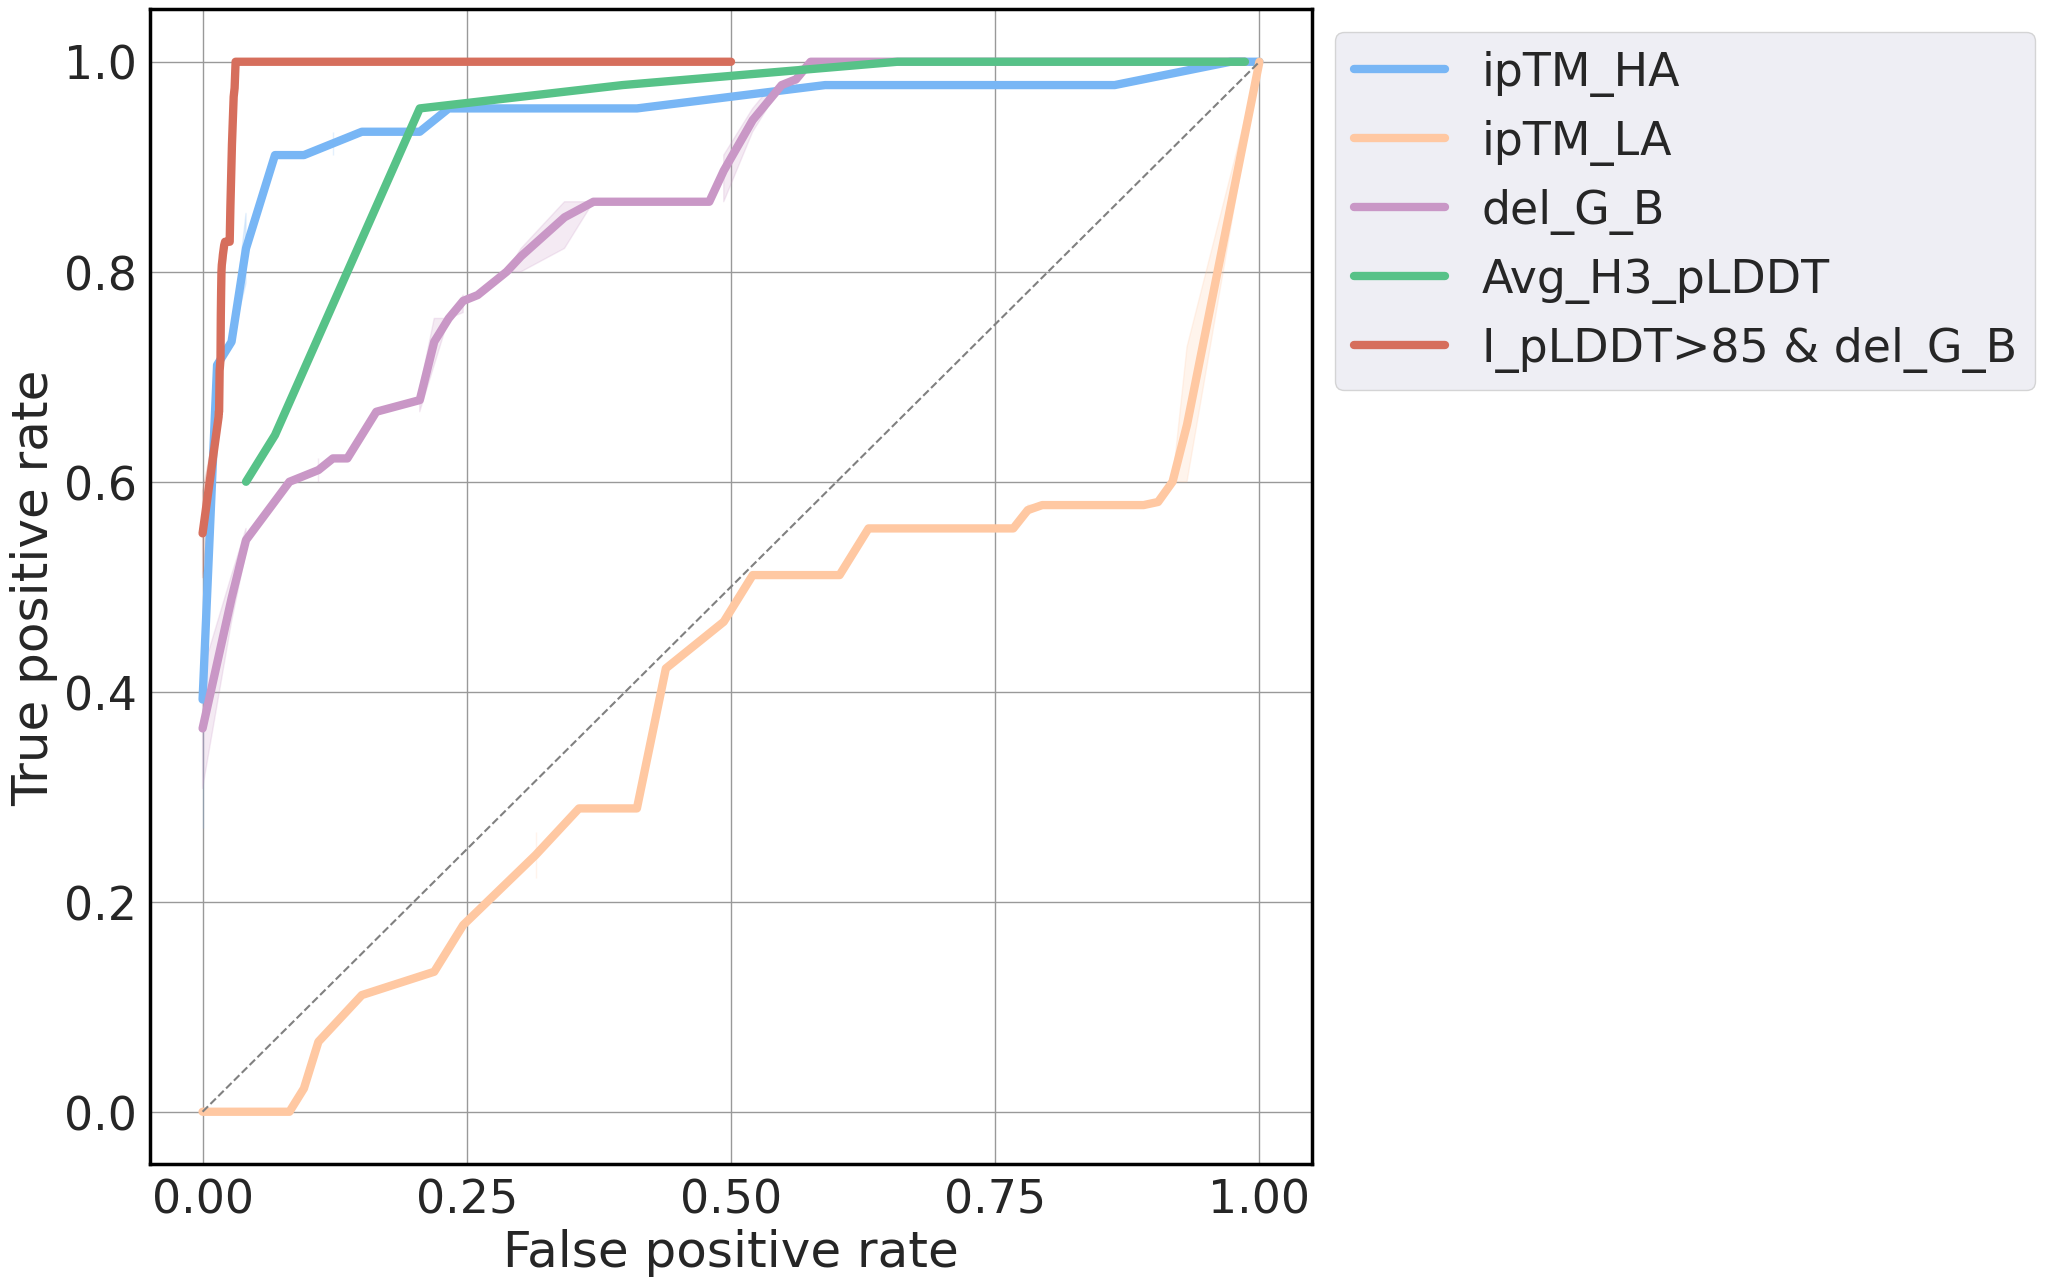

In [122]:
sns.set_style("whitegrid",{"grid.color":"0.6"})
plt.figure(figsize=(15,15))
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(rc=custom_params,font_scale=1.5)
ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')&(auroc_df['Metric'].isin(['I_pLDDT','ipTM_HA','ipTM_LA','del_G_B','Avg_H3_pLDDT','I_pLDDT>85 & del_G_B']))],x='False positive rate',y='True positive rate',\
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')],x='False positive rate',y='True positive rate',\
                  hue='Metric',palette=extended_pastel_palette[3:],linewidth=6,legend=True)
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')&(auroc_df['Metric'].isin(['I_pLDDT & Avg_H3_pLDDT']))],x='False positive rate',y='True positive rate',\
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')],x='False positive rate',y='True positive rate',\
                # color='purple',linewidth=8,legend=True)
sns.lineplot(x=np.array(list(range(0,11,1)))/10,y=np.array(list(range(0,11,1)))/10,ls='--',color='gray')
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
    spine.set_color('black')
sns.set(font_scale=3)
ax.set(xticks=[0,0.25,0.50,0.75,1.0]) 
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
plt.savefig(f'{filepath}Topranked_Ab_AUROC_withallmetrics_UNcappeddelGB_singlesandbest.svg',format='svg',dpi=700,transparent=True,bbox_inches='tight')

/tmp/ipykernel_2142446/3140810882.py:5: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')&(auroc_df['Metric'].str.contains('&'))&(~auroc_df['Metric'].isin(['I_pLDDT','ipTM_HA','ipTM_LA','del_G_B','Avg_H3_pLDDT','I_pLDDT>85 & del_G_B']))],x='False positive rate',y='True positive rate',\


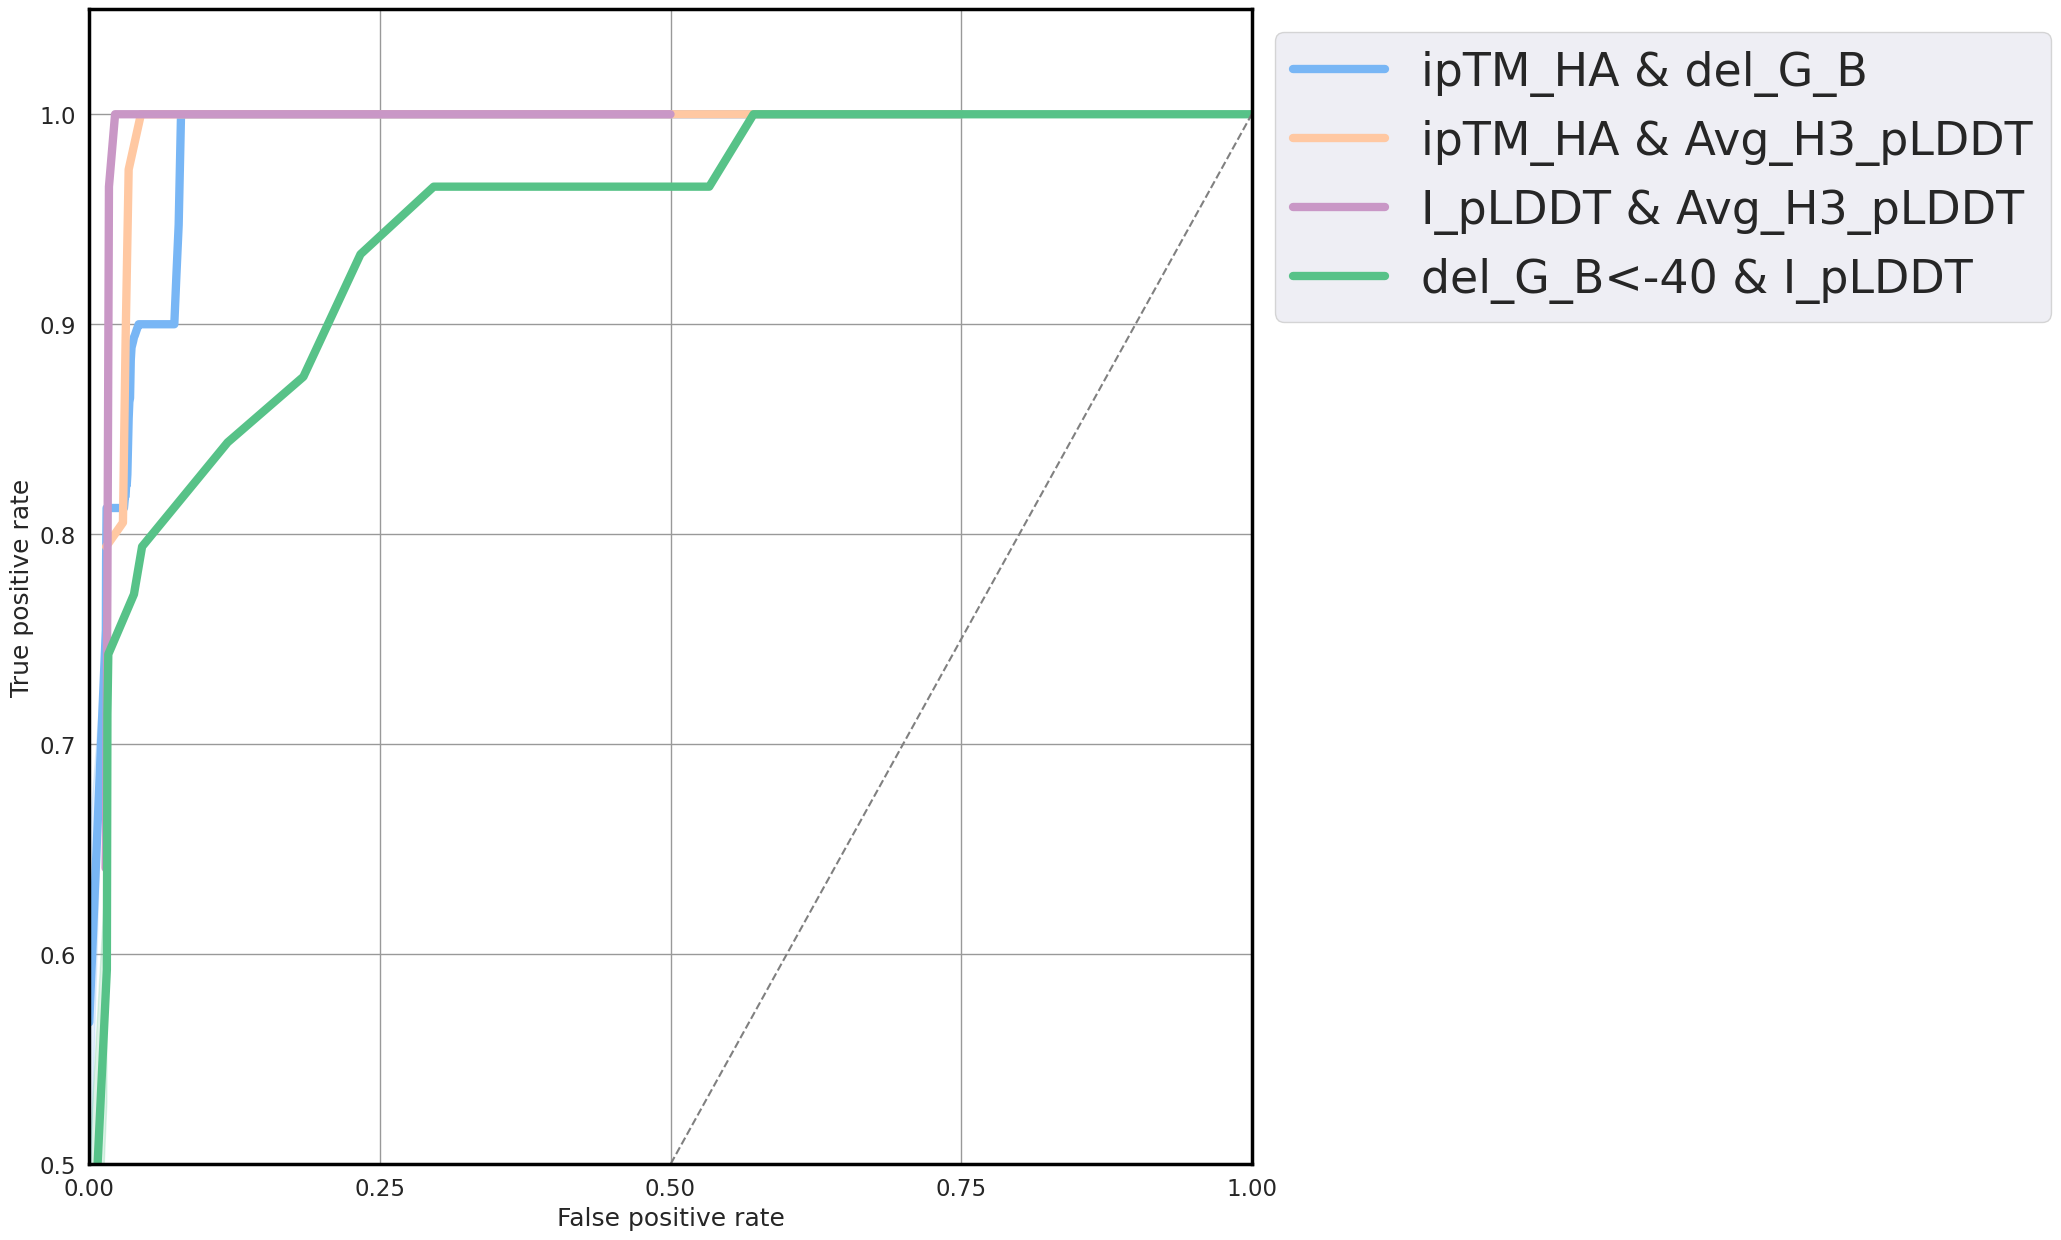

In [45]:
sns.set_style("whitegrid",{"grid.color":"0.6"})
plt.figure(figsize=(15,15))
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(rc=custom_params,font_scale=1.5)
ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')&(auroc_df['Metric'].str.contains('&'))&(~auroc_df['Metric'].isin(['I_pLDDT','ipTM_HA','ipTM_LA','del_G_B','Avg_H3_pLDDT','I_pLDDT>85 & del_G_B']))],x='False positive rate',y='True positive rate',\
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')],x='False positive rate',y='True positive rate',\
                  hue='Metric',palette=extended_pastel_palette[3:],linewidth=6,legend=True)
ax.set(xlim=(0,0.8),ylim=(0.5,1.05))
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')&(auroc_df['Metric'].isin(['I_pLDDT & del_G_B']))],x='False positive rate',y='True positive rate',\
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')],x='False positive rate',y='True positive rate',\
                # color='purple',linewidth=8,legend=True)
sns.lineplot(x=np.array(list(range(0,11,1)))/10,y=np.array(list(range(0,11,1)))/10,ls='--',color='gray')
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
    spine.set_color('black')
sns.set(font_scale=3)
ax.set(xticks=[0,0.25,0.50,0.75,1.0])
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
plt.savefig(f'{filepath}Topranked_Ab_AUROC_withallmetrics_UNcappeddelGB_nonbestcombos.svg',format='svg',dpi=700,transparent=True,bbox_inches='tight')

In [109]:
sns.set_style("whitegrid",{"grid.color":"0.6"})
plt.figure(figsize=(15,15))
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(rc=custom_params,font_scale=1.5)
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')&(~auroc_df['Metric'].str.contains('I_pLDDT &'))],x='False positive rate',y='True positive rate',\
ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')],x='False positive rate',y='True positive rate',\
                  hue='Metric',palette=extended_pastel_palette[3:],linewidth=6,legend=True)
sns.lineplot(x=np.array(list(range(0,11,1)))/10,y=np.array(list(range(0,11,1)))/10,ls='--',color='gray')
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
    spine.set_color('black')
sns.set(font_scale=3)
ax.set(xticks=[0,0.25,0.50,0.75,1.0])
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
plt.savefig(f'{filepath}Topranked_Ab_AUROC_withallmetrics_cappeddelGB.png',dpi=500,transparent=True,bbox_inches='tight')

/tmp/ipykernel_3821784/2307026376.py:6: UserWarning: 
The palette list has fewer values (6) than needed (9) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')],x='False positive rate',y='True positive rate',\


Error in callback <function flush_figures at 0x1553e52d11b0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

/tmp/ipykernel_654915/77022985.py:5: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric'].isin(['I_pLDDT','ipTM_HA','del_G_B','Avg_H3_pLDDT','del_G_B<0 & I_pLDDT']))],x='False positive rate',y='True positive rate',\


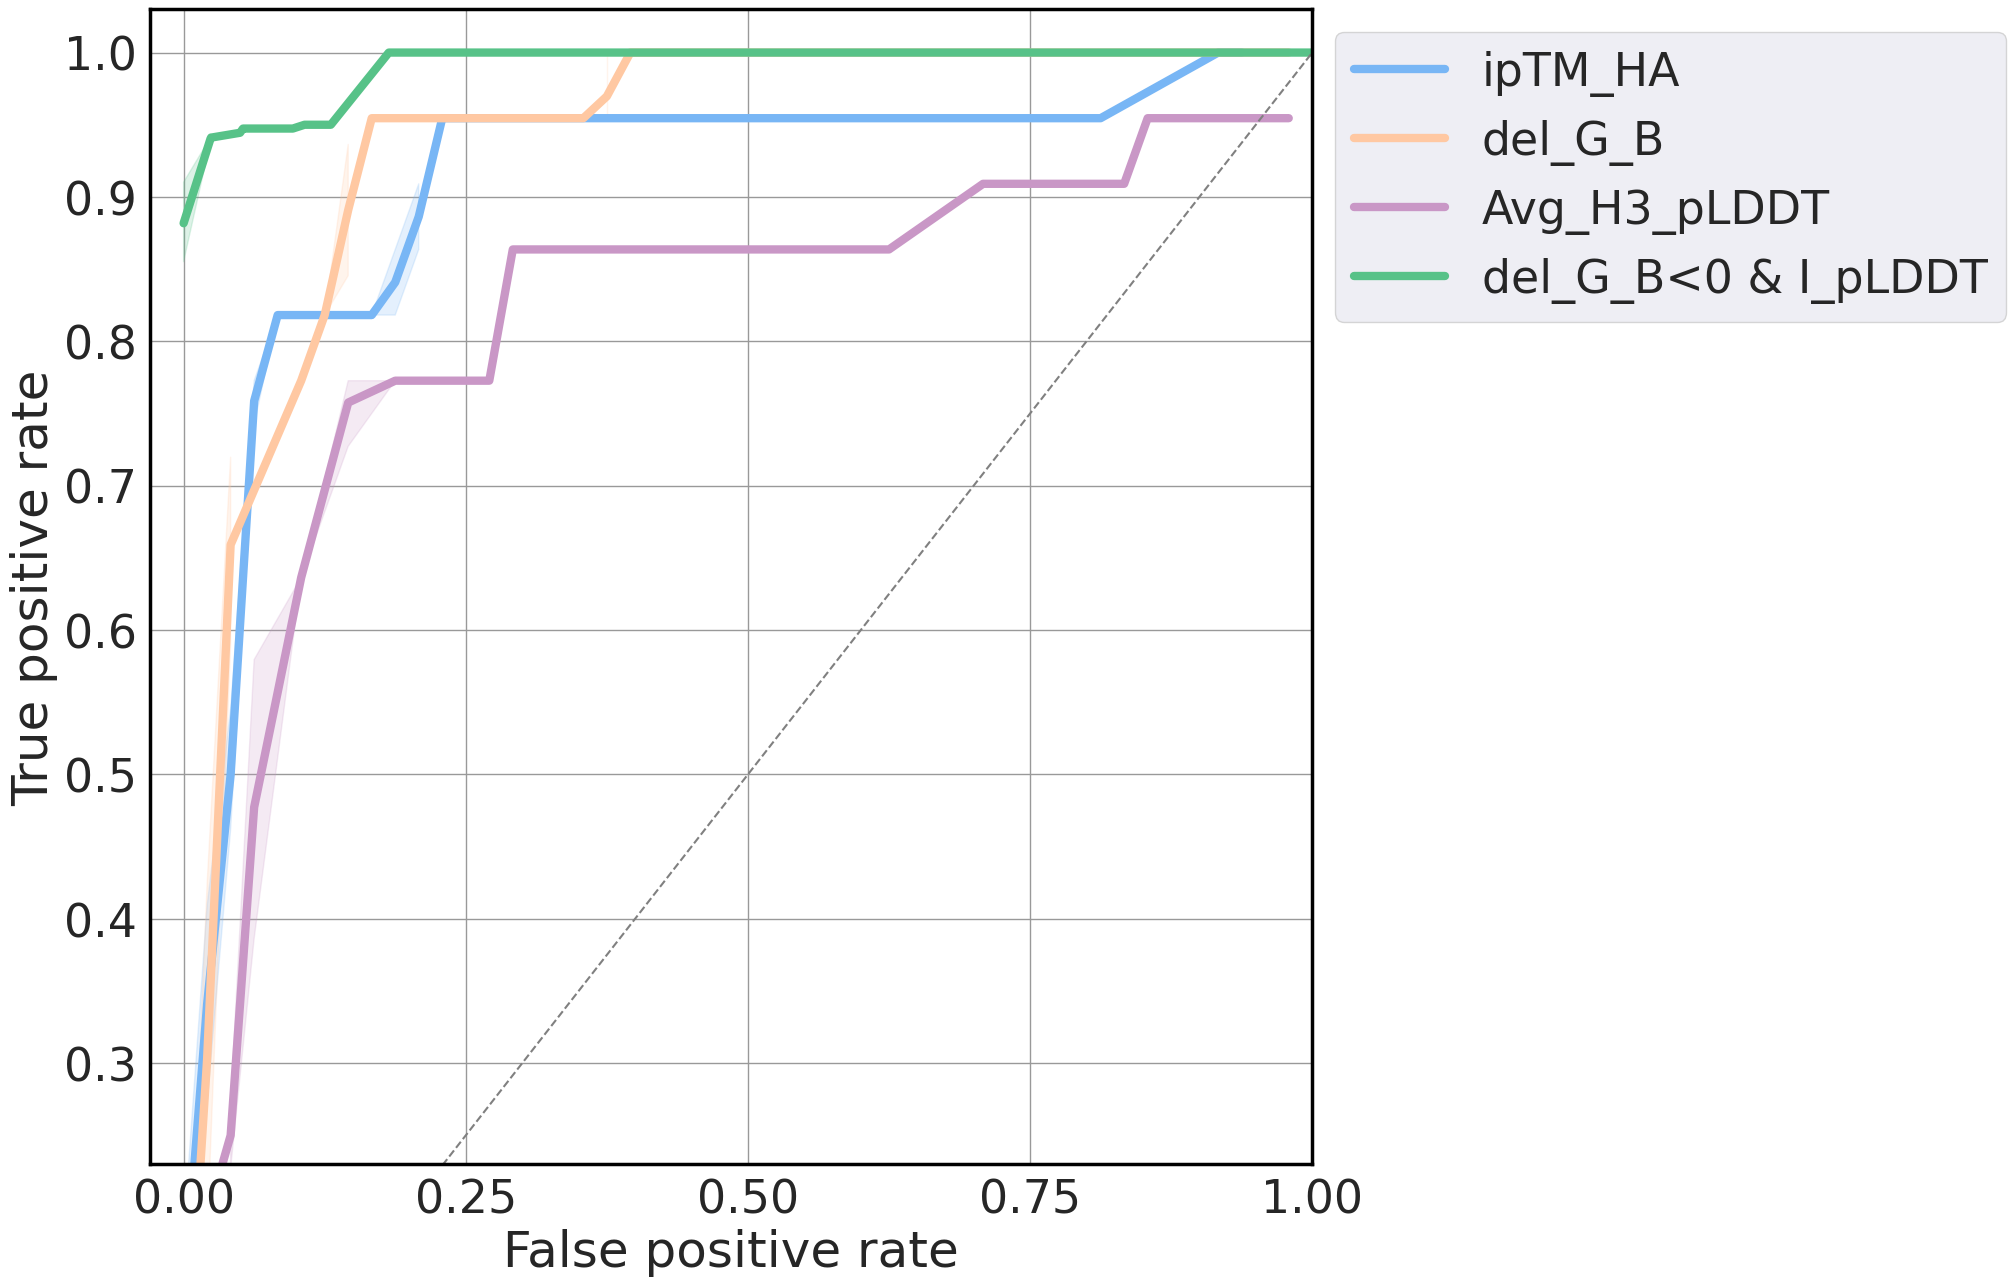

In [100]:
sns.set_style("whitegrid",{"grid.color":"0.6"})
plt.figure(figsize=(15,15))
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(rc=custom_params,font_scale=1.5)
ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric'].isin(['I_pLDDT','ipTM_HA','del_G_B','Avg_H3_pLDDT','del_G_B<0 & I_pLDDT']))],x='False positive rate',y='True positive rate',\
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')],x='False positive rate',y='True positive rate',\
                  hue='Metric',palette=extended_pastel_palette[3:],linewidth=6,legend=True)
ax.set(xlim=(-0.03,0.8),ylim=(0.23,1.03))
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric'].isin(['I_pLDDT & del_G_B']))],x='False positive rate',y='True positive rate',\
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')],x='False positive rate',y='True positive rate',\
                #   color='purple',linewidth=8,legend=True)

sns.lineplot(x=np.array(list(range(0,11,1)))/10,y=np.array(list(range(0,11,1)))/10,ls='--',color='gray')
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
    spine.set_color('black')
sns.set(font_scale=3)
ax.set(xticks=[0,0.25,0.50,0.75,1.0])
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
plt.savefig(f'{filepath}Topranked_Nb_AUROC_withallmetrics_UNcappeddelGB_singlesandbest.svg',format='svg',dpi=700,transparent=True,bbox_inches='tight')

/tmp/ipykernel_654915/1526683554.py:5: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric'].str.contains('&'))&(~auroc_df['Metric'].isin(['I_pLDDT','ipTM_HA','del_G_B','Avg_H3_pLDDT','del_G_B<0 & I_pLDDT']))],x='False positive rate',y='True positive rate',\


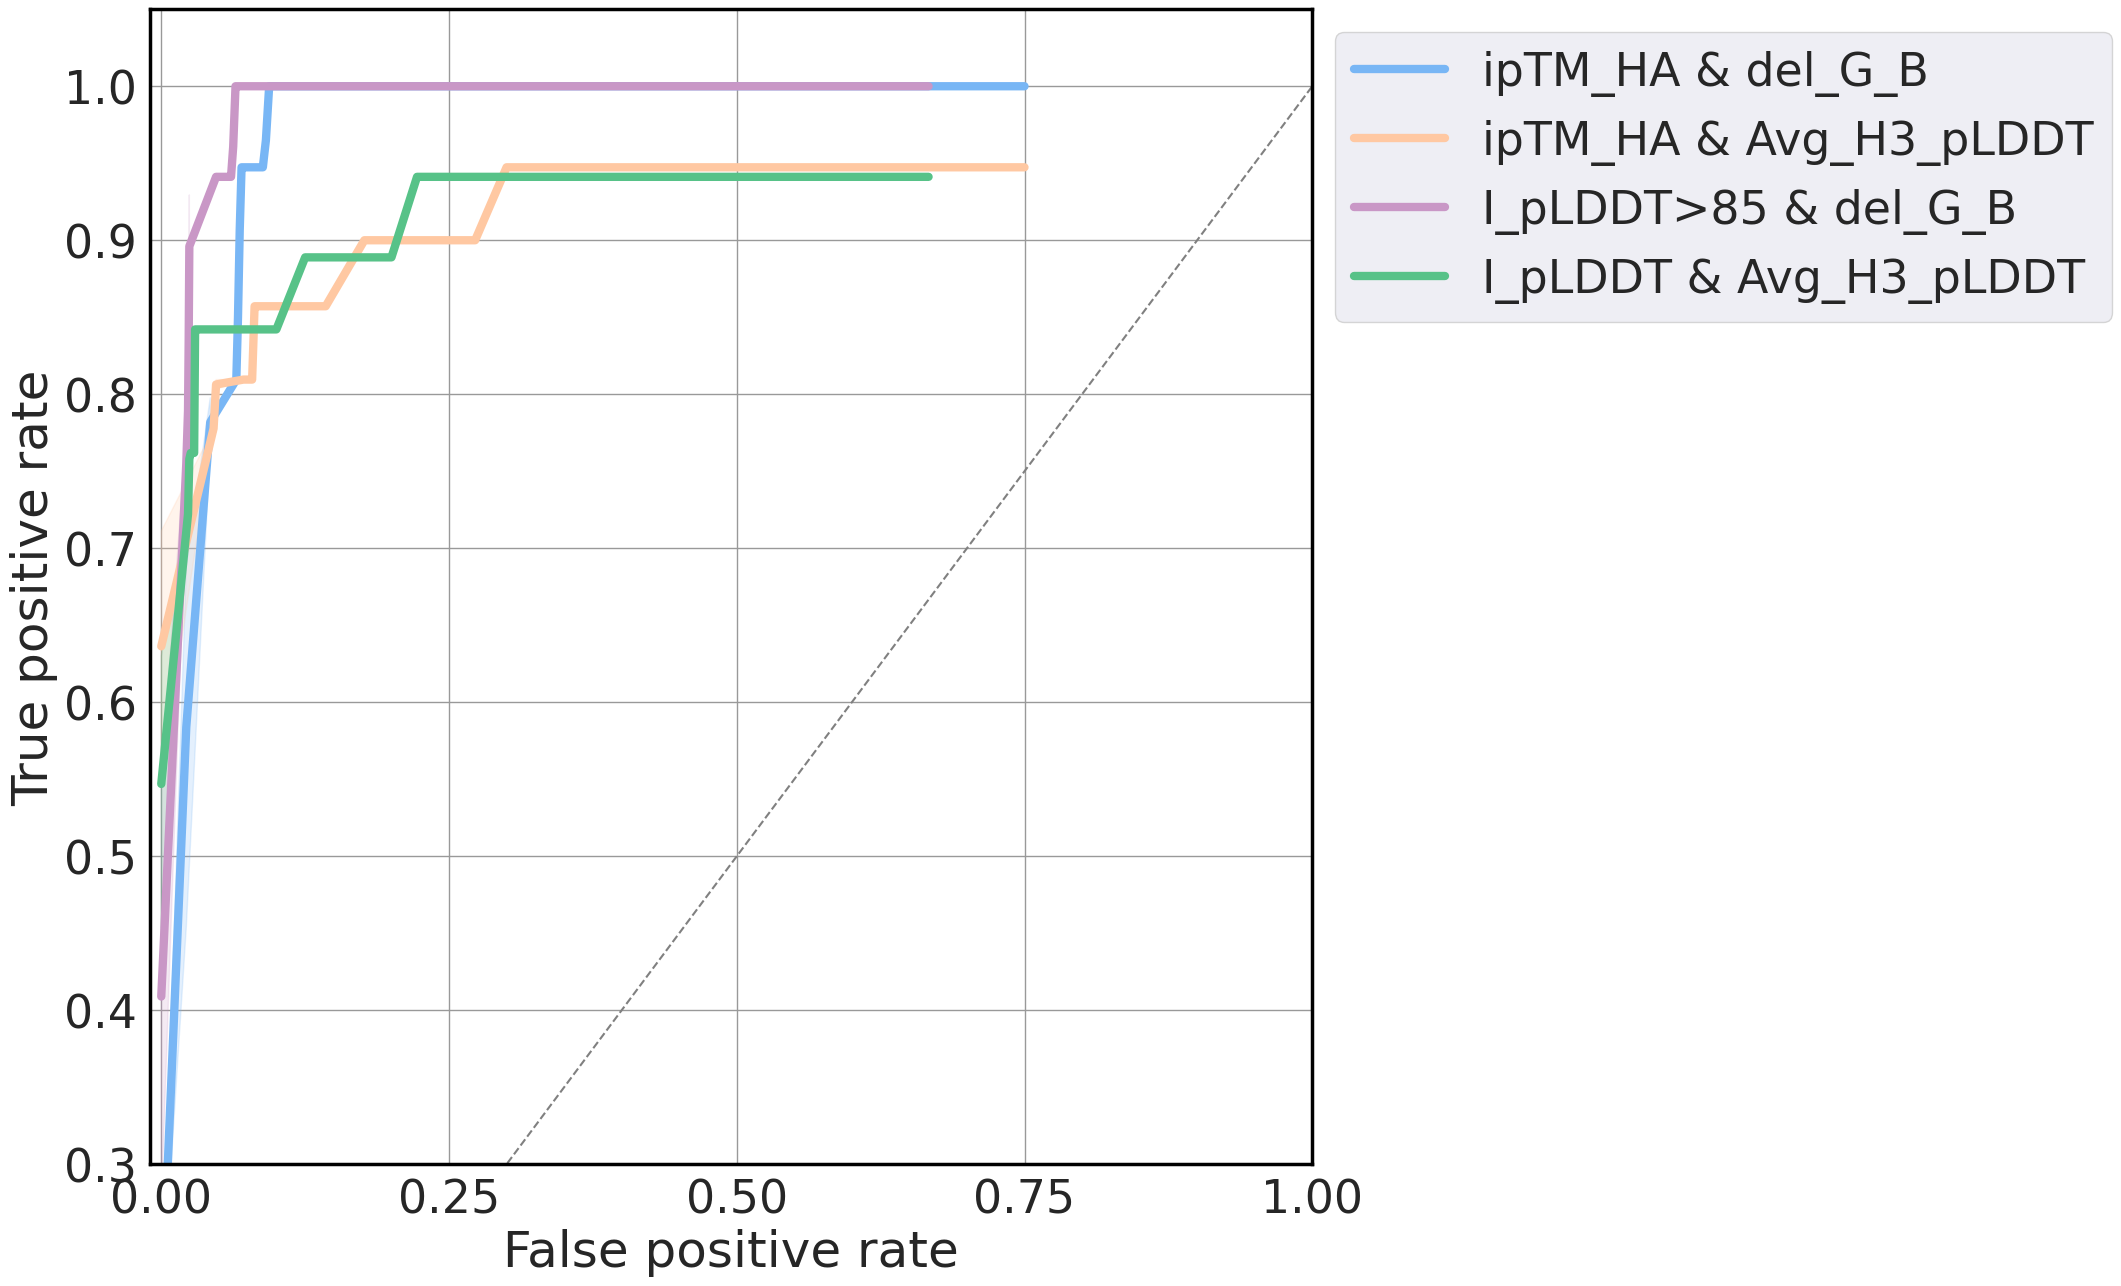

In [101]:
sns.set_style("whitegrid",{"grid.color":"0.6"})
plt.figure(figsize=(15,15))
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(rc=custom_params,font_scale=1.5)
ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric'].str.contains('&'))&(~auroc_df['Metric'].isin(['I_pLDDT','ipTM_HA','del_G_B','Avg_H3_pLDDT','del_G_B<0 & I_pLDDT']))],x='False positive rate',y='True positive rate',\
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')],x='False positive rate',y='True positive rate',\
                  hue='Metric',palette=extended_pastel_palette[3:],linewidth=6,legend=True)
ax.set(xlim=(-0.01,0.8),ylim=(0.3,1.05))
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='nanobody')&(auroc_df['Metric'].isin(['I_pLDDT & del_G_B']))],x='False positive rate',y='True positive rate',\
# ax = sns.lineplot(data=auroc_df[(auroc_df['Protein_type']=='antibody')],x='False positive rate',y='True positive rate',\
                #   color='purple',linewidth=8,legend=True)
sns.lineplot(x=np.array(list(range(0,11,1)))/10,y=np.array(list(range(0,11,1)))/10,ls='--',color='gray')
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
    spine.set_color('black')
sns.set(font_scale=3)
ax.set(xticks=[0,0.25,0.50,0.75,1.0])
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
plt.savefig(f'{filepath}Topranked_Nb_AUROC_withallmetrics_UNcappeddelGB_nonbestcombos.svg',format='svg',dpi=700,transparent=True,bbox_inches='tight')

## Panel 6: Overall Benchmark

In [ ]:
top_df_perseed['H3_local_RMSD'] = top_df_perseed['H3_local_RMSD'].astype(float)

/tmp/ipykernel_3821784/4199526609.py:3: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  ax = sns.boxplot(data=melted_Af3_benchmark[(melted_Af3_benchmark['Protein_type']=='nanobody')&(melted_Af3_benchmark['Bound_Unbound']=='unbound')\
/tmp/ipykernel_3821784/4199526609.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['FRH','H1','H2','H3','local H3'])


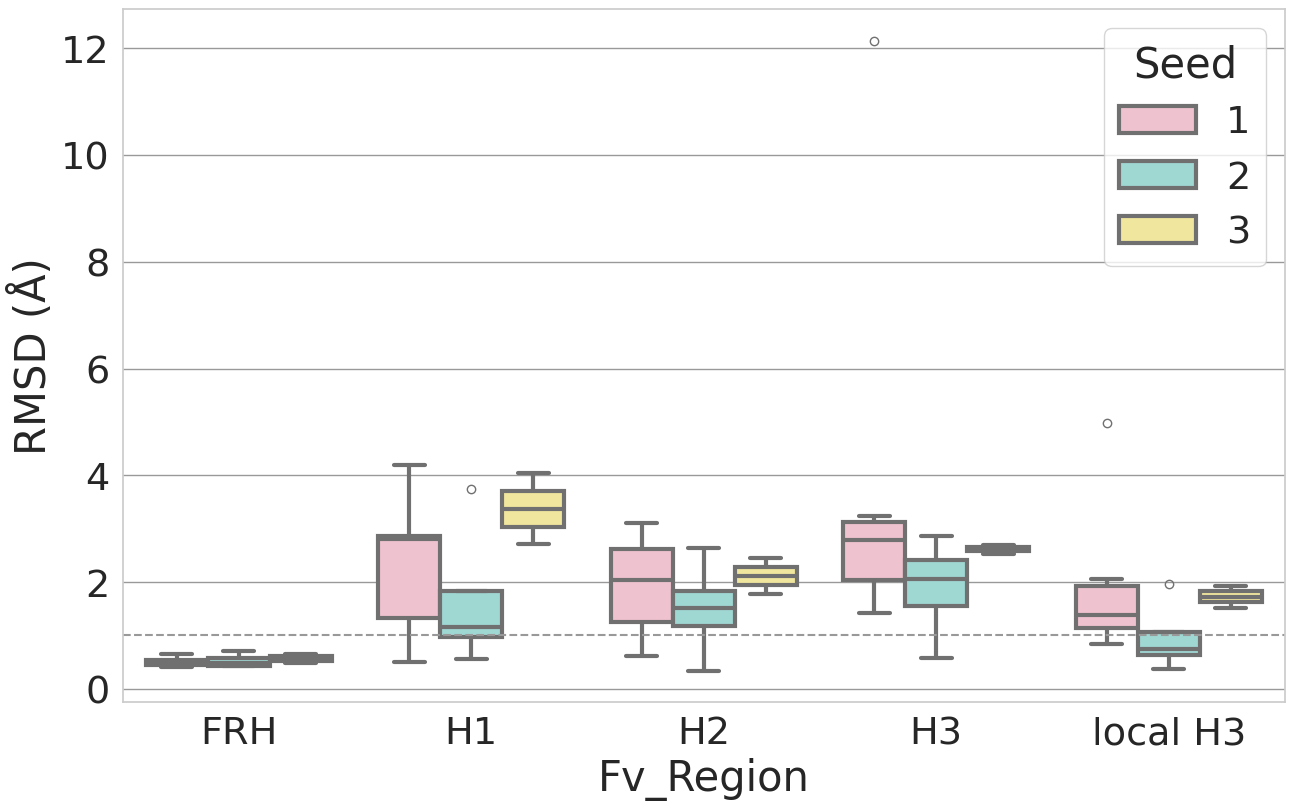

In [99]:
plt.figure(figsize=(15,9))
sns.set_style("whitegrid",{"grid.color":"0.6"})
ax = sns.boxplot(data=melted_Af3_benchmark[(melted_Af3_benchmark['Protein_type']=='nanobody')&(melted_Af3_benchmark['Bound_Unbound']=='unbound')\
                                           &(melted_Af3_benchmark['Fv_Region']!='ocd')&(melted_Af3_benchmark['Model']==0)],\
            x='Fv_Region',y='RMSD (Å)',hue='Seed',palette=pastel_palette,linewidth=3,\
                order= ['frh_rms', 'h1_rms', 'h2_rms', 'h3_rms','H3_local_RMSD']) #,'frl_rms', 'l1_rms',
    #    'l2_rms', 'l3_rms'])
sns.set(font_scale=2.5)
ax.set(xticklabels=['FRH','H1','H2','H3','local H3'])
plt.savefig(f"{filepath}topranked_unbound_Nb_benchmarkAF3.svg",format='svg',dpi=700,transparent=True,bbox_inches='tight')
ax.axhline(y=1,ls='--',color='0.6')

/tmp/ipykernel_3821784/1325623490.py:3: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  ax = sns.boxplot(data=melted_Af3_benchmark[(melted_Af3_benchmark['Protein_type']=='antibody')&(melted_Af3_benchmark['Bound_Unbound']=='bound')\
/tmp/ipykernel_3821784/1325623490.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['FRH','H1','H2','H3','local H3','FRL','L1','L2','L3'])


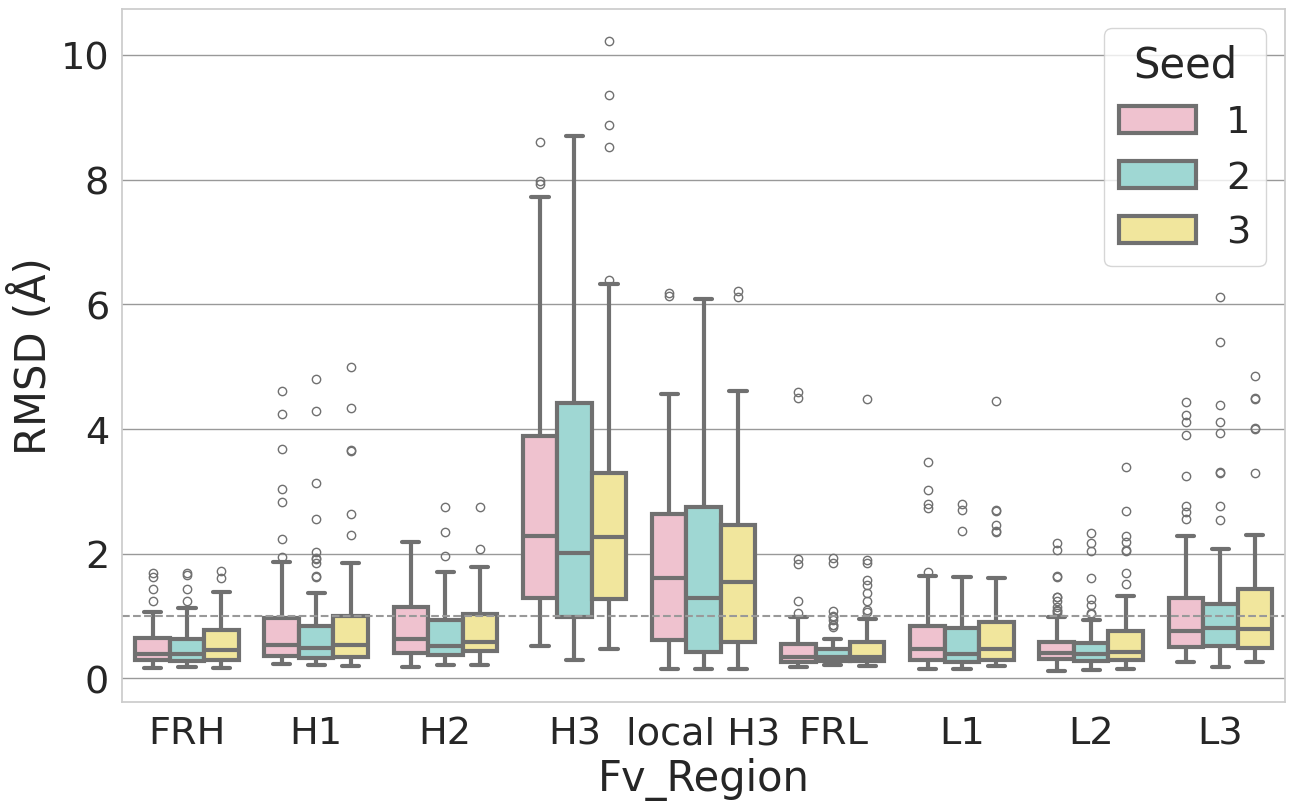

In [100]:
plt.figure(figsize=(15,9))
sns.set_style("whitegrid",{"grid.color":"0.6"})
ax = sns.boxplot(data=melted_Af3_benchmark[(melted_Af3_benchmark['Protein_type']=='antibody')&(melted_Af3_benchmark['Bound_Unbound']=='bound')\
                                           &(melted_Af3_benchmark['Fv_Region']!='ocd')&(melted_Af3_benchmark['Model']==0)],\
            x='Fv_Region',y='RMSD (Å)',hue='Seed',palette=pastel_palette,linewidth=3,\
                order= ['frh_rms', 'h1_rms', 'h2_rms', 'h3_rms','H3_local_RMSD','frl_rms', 'l1_rms',
       'l2_rms', 'l3_rms'])
sns.set(font_scale=2.5)
ax.set(xticklabels=['FRH','H1','H2','H3','local H3','FRL','L1','L2','L3'])
plt.savefig(f"{filepath}topranked_bound_Ab_benchmarkAF3.svg",format='svg',dpi=700,transparent=True,bbox_inches='tight')
ax.axhline(y=1,ls='--',color='0.6')

/tmp/ipykernel_3821784/1021239620.py:3: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  ax = sns.boxplot(data=melted_Af3_benchmark[(melted_Af3_benchmark['Protein_type']=='nanobody')&(melted_Af3_benchmark['Bound_Unbound']=='bound')\
/tmp/ipykernel_3821784/1021239620.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['FRH','H1','H2','H3','local H3'])


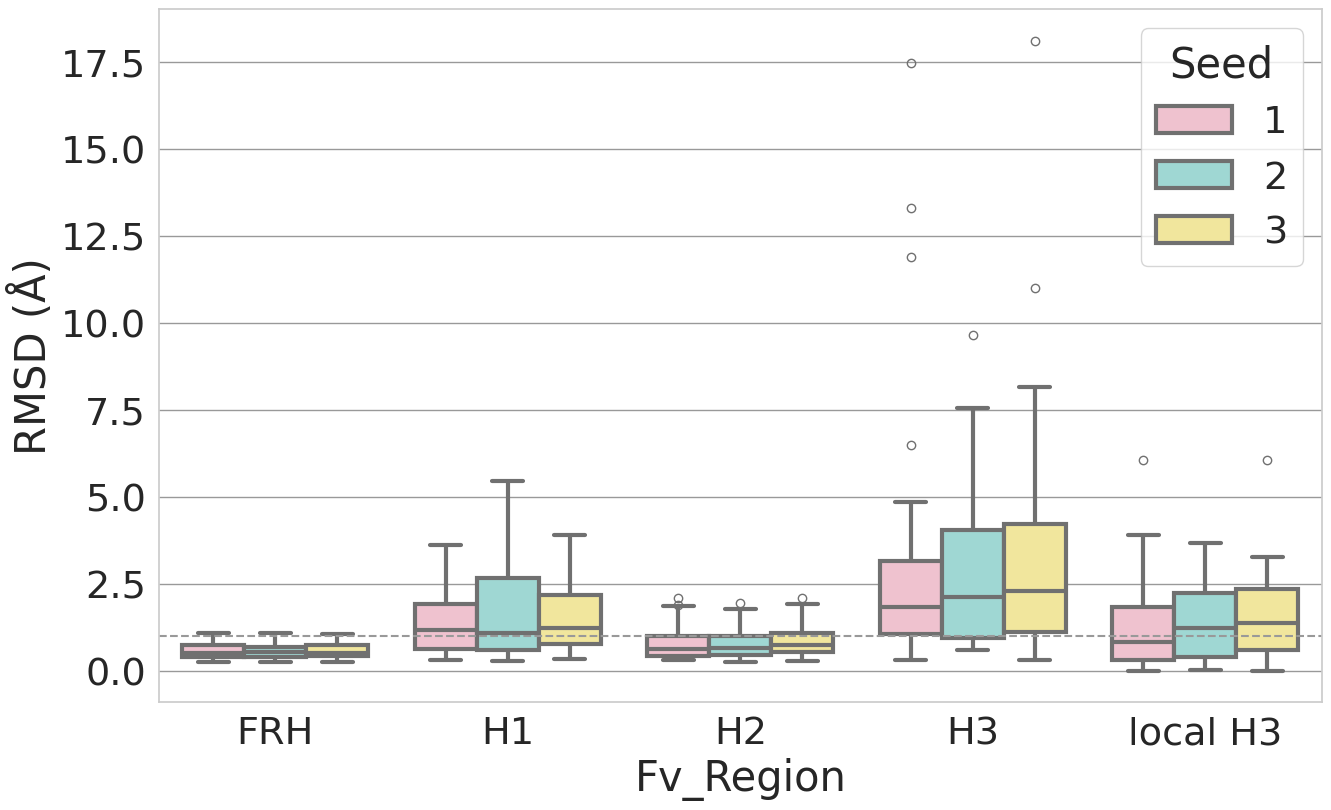

In [101]:
plt.figure(figsize=(15,9))
sns.set_style("whitegrid",{"grid.color":"0.6"})
ax = sns.boxplot(data=melted_Af3_benchmark[(melted_Af3_benchmark['Protein_type']=='nanobody')&(melted_Af3_benchmark['Bound_Unbound']=='bound')\
                                           &(melted_Af3_benchmark['Fv_Region']!='ocd')&(melted_Af3_benchmark['Model']==0)],\
            x='Fv_Region',y='RMSD (Å)',hue='Seed',palette=pastel_palette,linewidth=3,\
                order= ['frh_rms', 'h1_rms', 'h2_rms', 'h3_rms','H3_local_RMSD']) #,'frl_rms', 'l1_rms',
    #    'l2_rms', 'l3_rms'])
sns.set(font_scale=2.5)
ax.set(xticklabels=['FRH','H1','H2','H3','local H3'])
plt.savefig(f"{filepath}topranked_bound_Nb_benchmarkAF3.svg",format='svg',dpi=700,transparent=True,bbox_inches='tight')
ax.axhline(y=1,ls='--',color='0.6')

## Panel 7: DockQ v ipTM_HA

ab stats: PearsonRResult(statistic=0.9002094254863551, pvalue=5.601194864927892e-27)
nb stats: PearsonRResult(statistic=0.7346950900117946, pvalue=2.7730403212267117e-09)


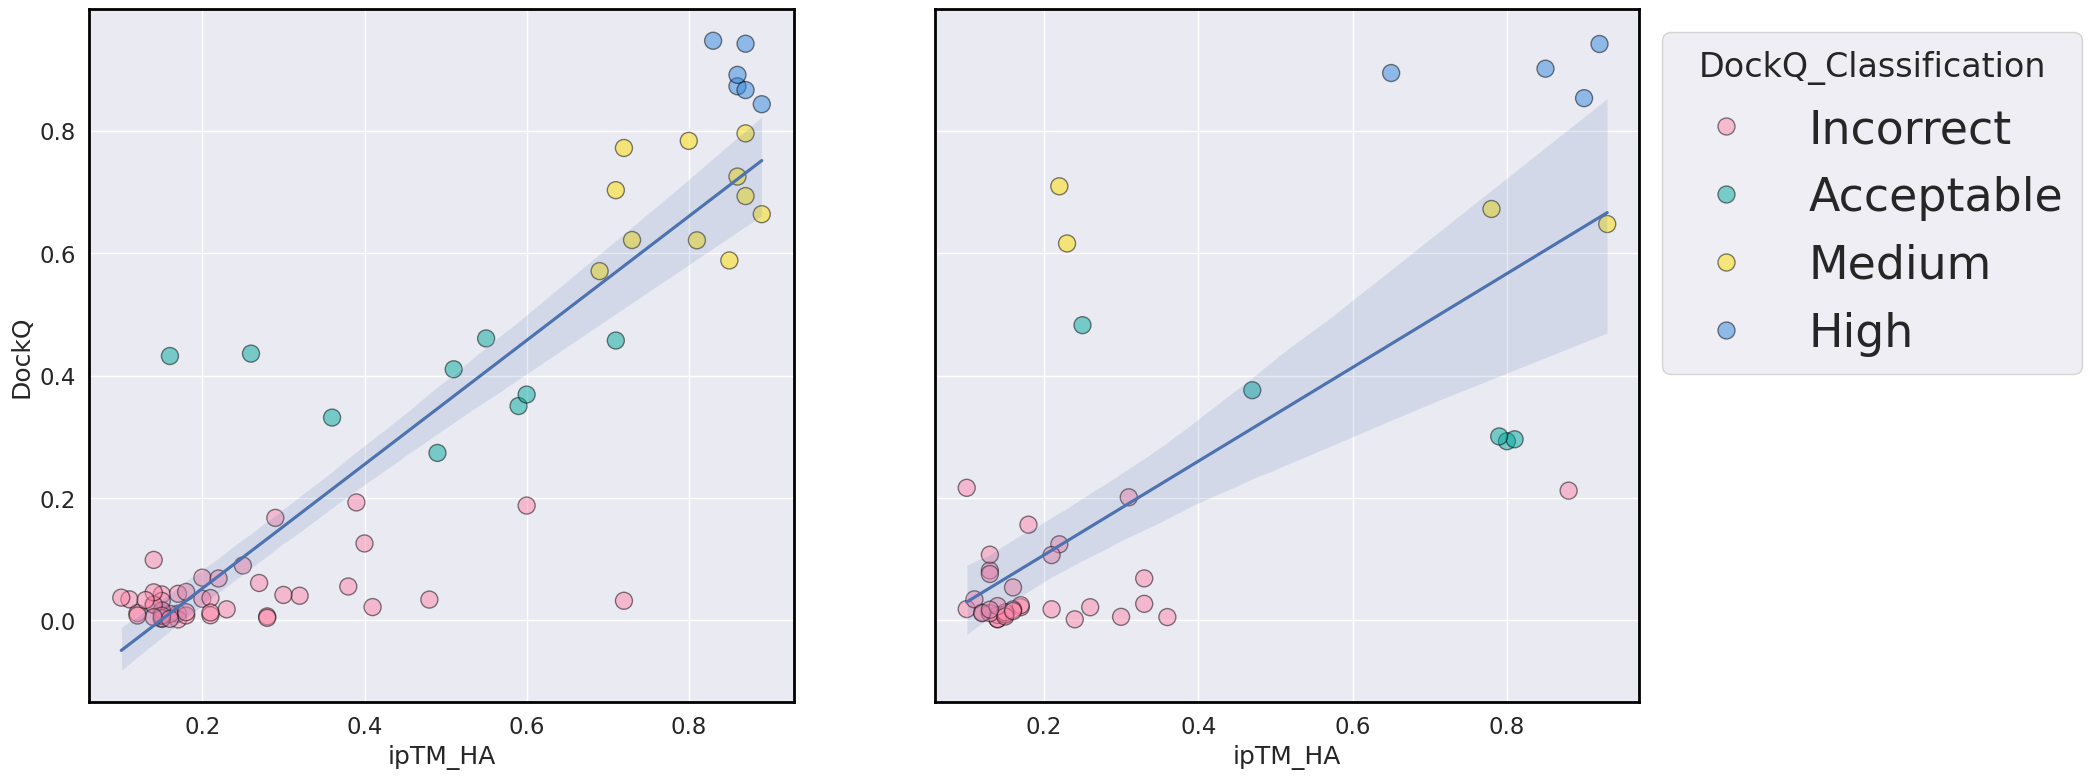

In [23]:
# plt.figure(figsize=(10,10))
fig, axes = plt.subplots(1,2, figsize=(20, 9), sharey=True)
custom_params = {"axes.spines.right": True, "axes.spines.top": True,"grid.color":"0.6"}
sns.set_theme(style='whitegrid', rc=custom_params,font_scale=3)
datadf = top_df[(top_df['Protein_type']=='antibody')&(top_df['AF3_PDB'].str.contains('model_0'))]
ax = sns.scatterplot(ax=axes[0],data=datadf,x='ipTM_HA',y='DockQ',hue='DockQ_Classification',hue_order=['Incorrect','Acceptable','Medium','High'],edgecolor='black',alpha=0.5,s=150,palette=palette,legend=False)
sns.set(font_scale=3)
# sns.set_style("whitegrid",{"grid.color":"0.6"})
sns.regplot(ax=axes[0],data=datadf,x='ipTM_HA',y='DockQ',scatter=False,order=1)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
# plt.figure(figsize=(10,10))
x = datadf.ipTM_HA.dropna().astype(float).tolist()
y = datadf.DockQ.dropna().astype(float).tolist()
res = stats.pearsonr(x, y)
print(f"ab stats: {res}")
custom_params = {"axes.spines.right": True, "axes.spines.top": True,"grid.color":"0.6"}
sns.set_theme(style='whitegrid', rc=custom_params,font_scale=2)
datadf = top_df[(top_df['Protein_type']=='nanobody')&(top_df['AF3_PDB'].str.contains('model_0'))]
ax = sns.scatterplot(ax=axes[1],data=datadf,x='ipTM_HA',y='DockQ',hue='DockQ_Classification',hue_order=['Incorrect','Acceptable','Medium','High'],edgecolor='black',alpha=0.5,s=150,palette=palette)
# sns.set_style("whitegrid",{"grid.color":"0.6"})
sns.set(font_scale=3)
sns.regplot(ax=axes[1],data=datadf,x='ipTM_HA',y='DockQ',scatter=False,order=1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')
x = datadf.ipTM_HA.dropna().astype(float).tolist()
y = datadf.DockQ.dropna().astype(float).tolist()
res = stats.pearsonr(x, y)
print(f"nb stats: {res}")
plt.savefig(f"{filepath}Top_ranked_ab_v_nb_dockqviptm.svg",format='svg',dpi=700,transparent=True,bbox_inches='tight')